# House sales in King County, Seattle

# 00. Introduction

### 1) 팀원 
- 홍준표     
- 윤강열  
- 윤현선
   
### 2) 목표: test data의 sales price(집값) 예측

### 3) 데이터 
- 위치: 미국 Washington주의 King County
- 총 data : 21,613개의 집값 데이터
    - [출처](https://www.kaggle.com/harlfoxem/housesalesprediction)
- Train Datasets: 70%
- Test Datasets: 30%

### 4) 평가기준
- R-squared
($ R^2 $)

### 5) 진행순서
- **데이터 탐색(EDA)**
    - load datasets
    - target data
    - independent variables
        - pairplot
        - heatmaps
        - histograms
        - target vs. X scatter plots
    - 다중공선성
    - 이상값제거
    - category변환<br><br>
    
- **Modeling**
    - train data 전처리
    - final model
        - performance
        - 부분회귀<br><br>
- **Prediction**
    - test data 전처리
    - test R-squared

# 0. Import Packages and Load Data

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import norm, skew 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter('ignore')

fs = (13, 7)

In [2]:
with open("data.pkl", "rb") as f:
    df = pickle.load(f)

In [3]:
# load csv

# df = pd.read_csv("data/kc_house_data.csv")

In [4]:
df.head().T

0                    1                    2  \
bathrooms                        1                 2.25                    1   
bedrooms                         3                    3                    2   
condition                        3                    3                    3   
date           2014-10-13 00:00:00  2014-12-09 00:00:00  2015-02-25 00:00:00   
date_ord                    735519               735576               735654   
floors                           1                    2                    1   
grade                            7                    7                    6   
lat                        47.5112               47.721              47.7379   
long                      -122.257             -122.319             -122.233   
sqft_above                    1180                 2170                  770   
sqft_basement                    0                  400                    0   
sqft_living                   1180                 2570                  770   
sqft_living15                 1340                 1690                 2720   
sqft_lot                      5650                 7242                10000   
sqft_lot15                    5650                 7639                 8062   
view                             0                    0                    0   
waterfront                       0                    0                    0   
yr_built                      1955                 1951                 1933   
yr_renovated                     0                 1991                    0   
zipcode                      98178                98125                98028   
price                       221900               538000               180000   

                                 3                    4  
bathrooms                        3                    2  
bedrooms                         4                    3  
condition                        5                    3  
date           2014-12-09 00:00:00  2015-02-18 00:00:00  
date_ord                    735576               735647  
floors                           1                    1  
grade                            7                    8  
lat                        47.5208              47.6168  
long                      -122.393             -122.045  
sqft_above                    1050                 1680  
sqft_basement                  910                    0  
sqft_living                   1960                 1680  
sqft_living15                 1360                 1800  
sqft_lot                      5000                 8080  
sqft_lot15                    5000                 7503  
view                             0                    0  
waterfront                       0                    0  
yr_built                      1965                 1987  
yr_renovated                     0                    0  
zipcode                      98136                98074  
price                       604000               510000

In [5]:
df.dtypes

bathrooms               float64
bedrooms                  int64
condition                 int64
date             datetime64[ns]
date_ord                  int64
floors                  float64
grade                     int64
lat                     float64
long                    float64
sqft_above                int64
sqft_basement             int64
sqft_living               int64
sqft_living15             int64
sqft_lot                  int64
sqft_lot15                int64
view                      int64
waterfront                int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
price                   float64
dtype: object

# 1. Preprocessing

**Columns**

    - id: a notation for a house
    - date: Date house was sold
    - price: Price is prediction target
    - bedrooms: Number of Bedrooms/House
    - bathrooms: Number of bathrooms/House
    - sqft_living: square footage of the home
    - sqft_lot: square footage of the lot
    - floors: Total floors (levels) in house
    - waterfront: House which has a view to a waterfront
    - view: Has been viewed
    - condition: How good the condition is ( Overall )
    - grade: overall grade given to the housing unit, based on King County grading system
    - sqft_above: square footage of house apart from basement
    - sqft_basement: square footage of the basement
    - yr_built: Built Year
    - yr_renovated: Year when house was renovated
    - zipcode: zip
    - lat: Latitude coordinate
    - long: Longitude coordinate
    - sqft_living15: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
    - sqft_lot15: lotSize area in 2015(implies-- some renovations)

| Y  | Dependent variables   |<center>Type</center>         | <center>Description</center>               | <center> Minimun, Mean, Max</center>
|-----|-----------------------|------------------------------|--------------------------------------------|------------------------------
|  1  | price                 | numerical                    | Target for prediction                      | 75000, 540088, 7700000

|  X  | Independent variables |<center>Type</center>         | <center>Description</center>               | <center> Minimun, Mean, Max</center> 
|-----|-----------------------|------------------------------|--------------------------------------------|------------------------------
|  -  | Id                    | -             | a notation for a house                   | 
|  1  | date                  | -             | date house was sold(May 2014 - May 2015) | 735355, 735535, 735745(ordinal)
|  2  | bedrooms              | numerical   | number of bedrooms                       | 0, 3.37, 33
|  3  | bathrooms             | numerical   | number of bathrooms                      | 0, 2.12, 8
|  4  | floors                | categorical   | total floors (levels) in house           | 1, 1.5, 3.5
|  5  | waterfront            | categorical   | house which has a view to a waterfront   | 0, 0.08, 1
|  6  | sqft_living           | numerical     | square footage of the home               | 290, 2079.9, 13540
|  7  | sqft_living15         | numerical     | living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area | 399, 1986.55, 6210
|  8  | sqft_above            | numerical             | square footage of house apart from basement | 0, 1.06, 28
|  9  | sqft_basement         | numerical             | square footage of the basement  | 0, 117.32, 2490
| 10  | sqft_lot              | numerical     | square footage of the lot | 520, 15107, 1651359
| 11  | sqft_lot15            | numerical     | lotSize area in 2015(implies-- some renovations) | 651, 12768.46, 871200
| 12  | view                  | categorical             | has been viewed | 0, 0.23, 4
| 13  | condition             | categorical             | how good the condition is (Overall) | 1, 3.41, 5
| 14  | grade                 | categorical     | overall grade given to the housing unit, based on King County grading system | 1, 7.66, 13
| 15  | yr_built              | numerical     | built Year  | 1900, 1971, 2015
| 16  | yr_renovated          | numerical   | Year when house was renovated | 0, 84.4, 2015
| 17  | zipcode               | categorical   | zipcode | 98001, 98077.94, 98199(70 types)
| 18  | lat                   | -             | latitude coordinate  | 47.16, 47.56, 47.78
| 19  | long                  | -             | longitude coordinate | -122.52, -122.21, -121.32


In [6]:
df.describe()

bathrooms      bedrooms     condition       date_ord        floors  \
count  21613.000000  21613.000000  21613.000000   21613.000000  21613.000000   
mean       2.114757      3.370842      3.409430  735535.193078      1.494309   
std        0.770163      0.930062      0.650743     113.048011      0.539989   
min        0.000000      0.000000      1.000000  735355.000000      1.000000   
25%        1.750000      3.000000      3.000000  735436.000000      1.000000   
50%        2.250000      3.000000      3.000000  735522.000000      1.500000   
75%        2.500000      4.000000      4.000000  735646.000000      2.000000   
max        8.000000     33.000000      5.000000  735745.000000      3.500000   

              grade           lat          long    sqft_above  sqft_basement  \
count  21613.000000  21613.000000  21613.000000  21613.000000   21613.000000   
mean       7.656873     47.560053   -122.213896   1788.390691     291.509045   
std        1.175459      0.138564      0.140828    828.090978     442.575043   
min        1.000000     47.155900   -122.519000    290.000000       0.000000   
25%        7.000000     47.471000   -122.328000   1190.000000       0.000000   
50%        7.000000     47.571800   -122.230000   1560.000000       0.000000   
75%        8.000000     47.678000   -122.125000   2210.000000     560.000000   
max       13.000000     47.777600   -121.315000   9410.000000    4820.000000   

        sqft_living  sqft_living15      sqft_lot     sqft_lot15          view  \
count  21613.000000   21613.000000  2.161300e+04   21613.000000  21613.000000   
mean    2079.899736    1986.552492  1.510697e+04   12768.455652      0.234303   
std      918.440897     685.391304  4.142051e+04   27304.179631      0.766318   
min      290.000000     399.000000  5.200000e+02     651.000000      0.000000   
25%     1427.000000    1490.000000  5.040000e+03    5100.000000      0.000000   
50%     1910.000000    1840.000000  7.618000e+03    7620.000000      0.000000   
75%     2550.000000    2360.000000  1.068800e+04   10083.000000      0.000000   
max    13540.000000    6210.000000  1.651359e+06  871200.000000      4.000000   

         waterfront      yr_built  yr_renovated       zipcode         price  
count  21613.000000  21613.000000  21613.000000  21613.000000  2.161300e+04  
mean       0.007542   1971.005136     84.402258  98077.939805  5.400881e+05  
std        0.086517     29.373411    401.679240     53.505026  3.671272e+05  
min        0.000000   1900.000000      0.000000  98001.000000  7.500000e+04  
25%        0.000000   1951.000000      0.000000  98033.000000  3.219500e+05  
50%        0.000000   1975.000000      0.000000  98065.000000  4.500000e+05  
75%        0.000000   1997.000000      0.000000  98118.000000  6.450000e+05  
max        1.000000   2015.000000   2015.000000  98199.000000  7.700000e+06

- Comments
    - Count값 동일, is null 확인: missig data 없음
    - Mean vs. Median(50%) 몇몇 데이터의 치우침이 있음 ex) sqft_living


#### Convert date to datetime64 and add column date_ord (ordinal)

In [7]:
df.date = df.date.astype("datetime64")
df["date_ord"] = df.date.apply(lambda x: x.toordinal())

In [8]:
# sort columns and move 'price' (y) to the last position

# cols = list(df.columns)
# cols.sort()
# cols.remove("price")
# cols.append("price")
# df = df[cols]

In [9]:
# check for any null values

# before = len(df)
# df = df.dropna()
# after = len(df)
# before, after, before == after

In [10]:
# drop column id

# df = df.drop("id", axis=1)

In [11]:
# save as binary file
# with open("data/data.pkl", "wb") as f:
#     pickle.dump(df, f)

# 2. EDA

## 2.1 Heatmap

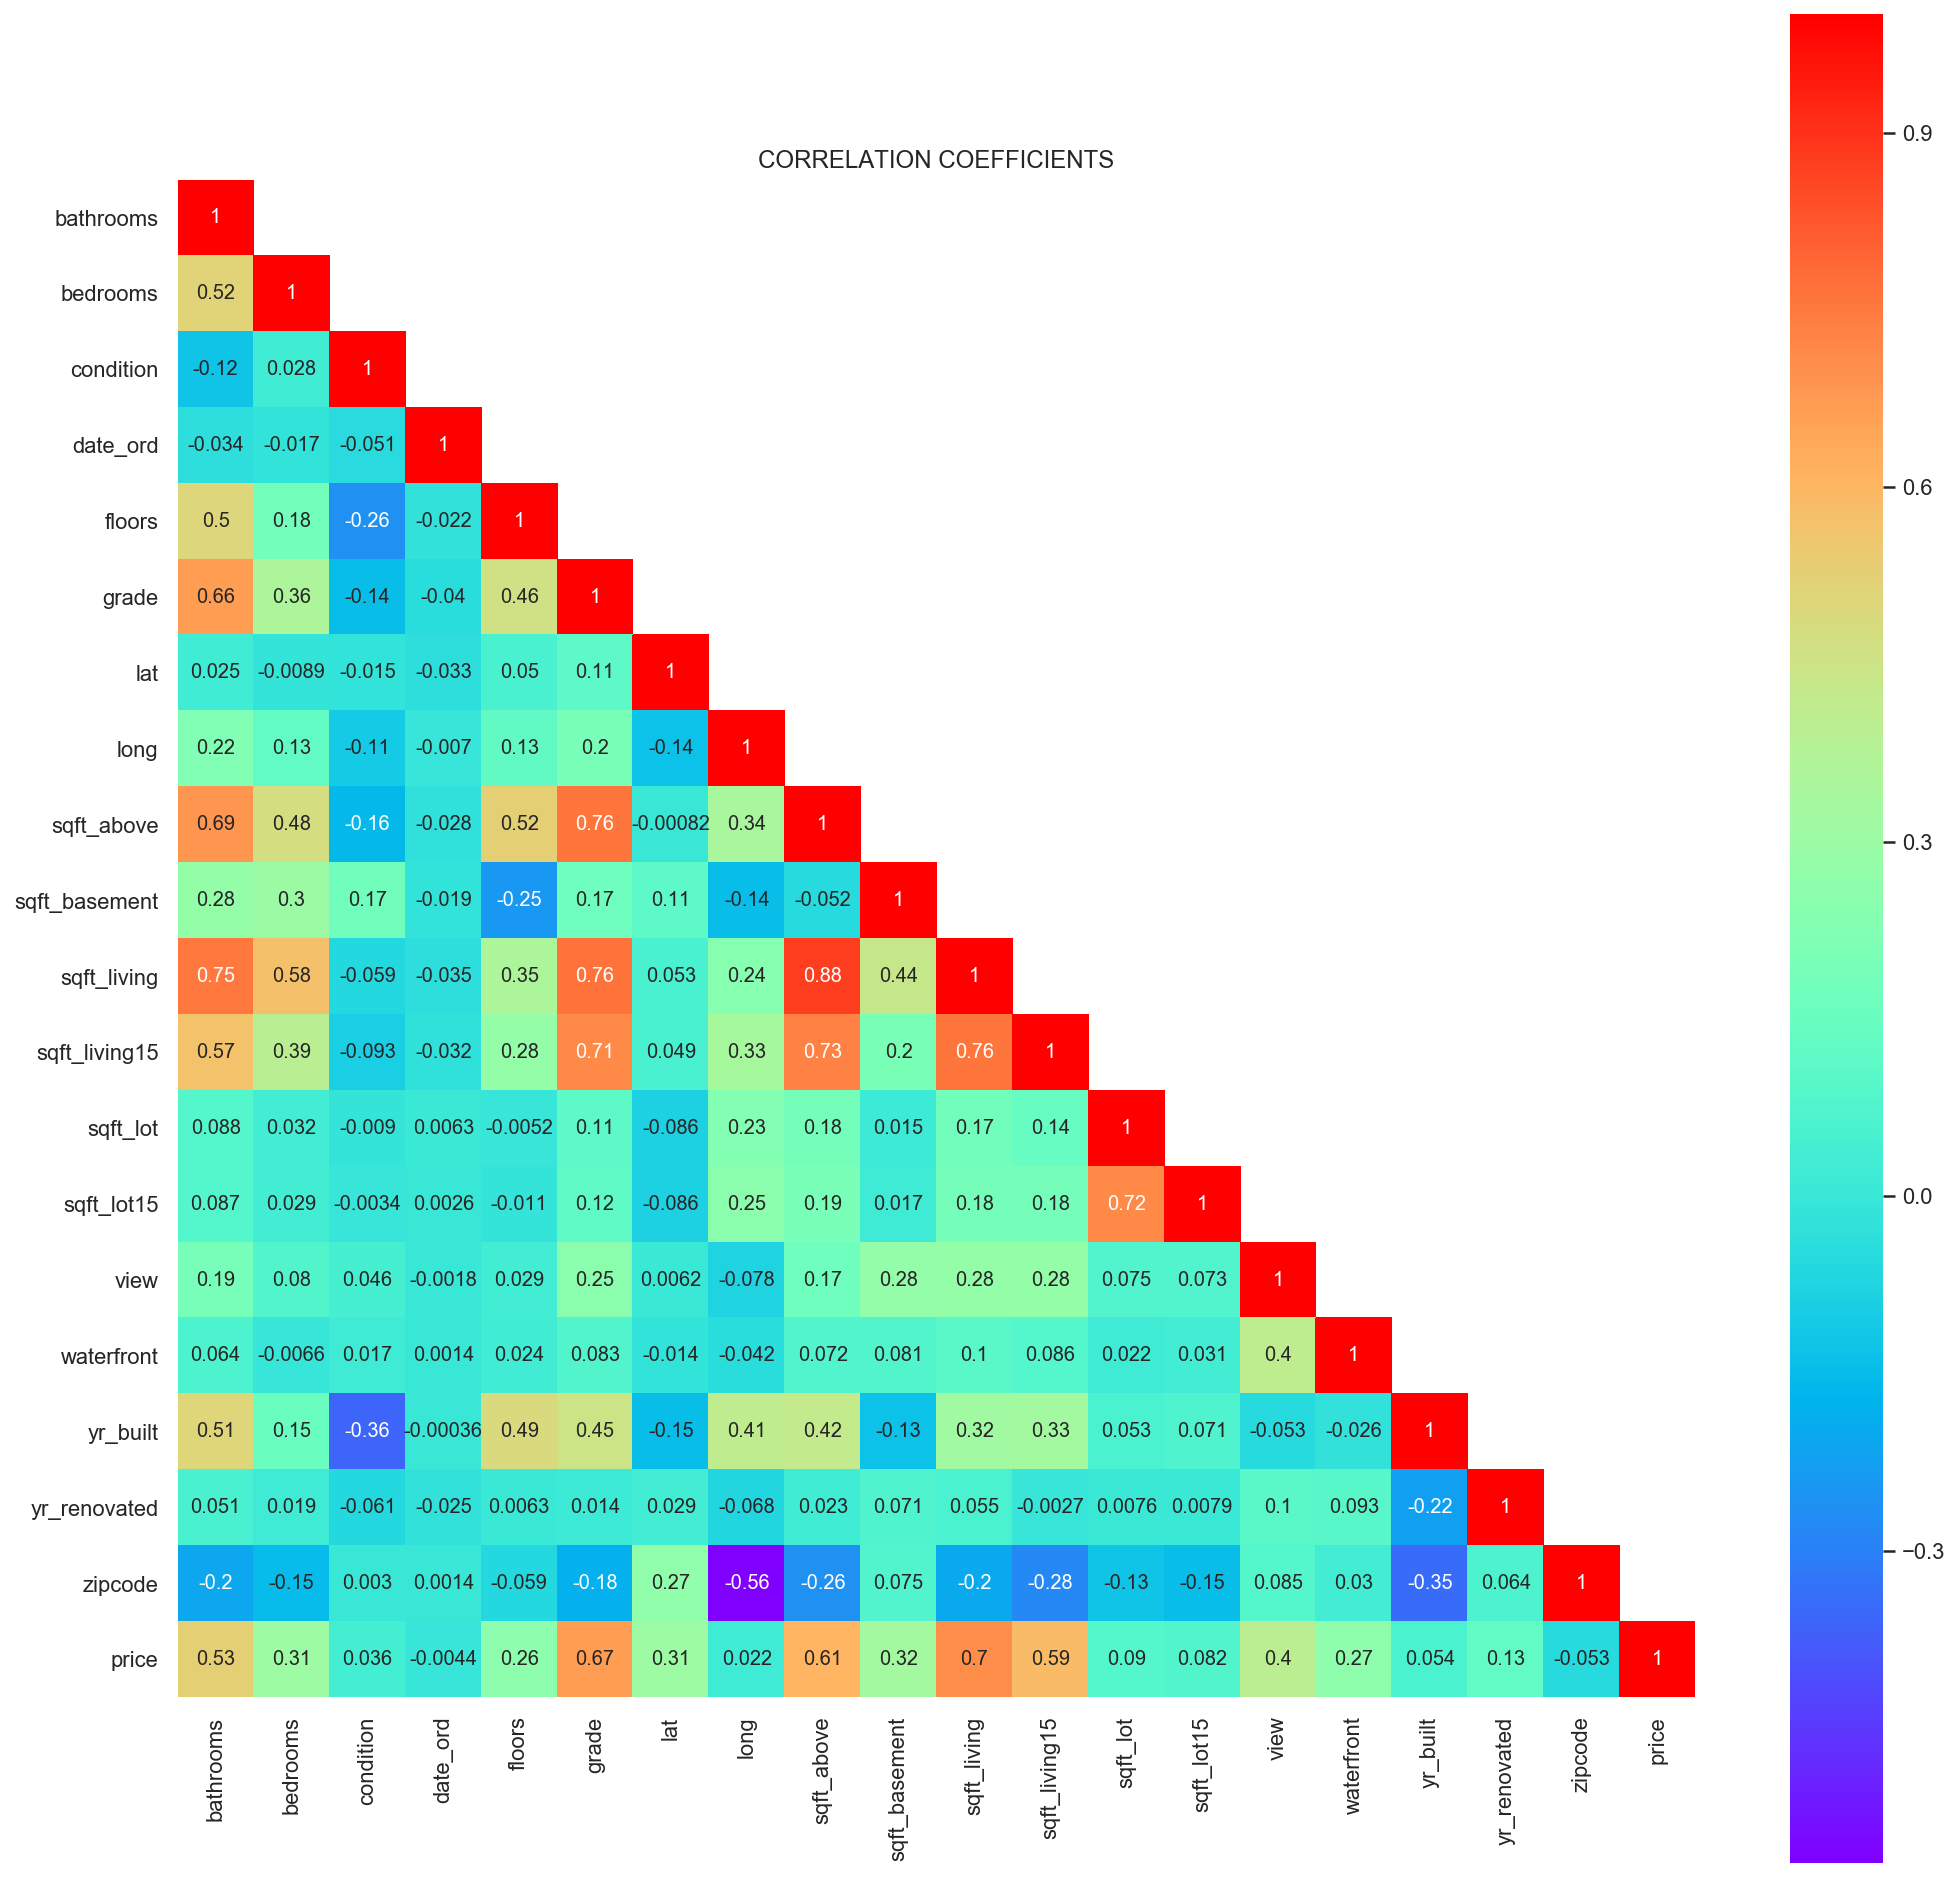

In [12]:
r = df.corr()
r_sq = r.apply(lambda x: x ** 2)
mask = np.zeros_like(r, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False 

# heatmap of R between columns
plt.figure(figsize=(17, 17))
sns.heatmap(r, annot=True, cmap="rainbow", square=True, mask=mask).set_title("CORRELATION COEFFICIENTS")
plt.savefig("figures/heatmap_r.png")
plt.show()

## 2.1 Pairplot

In [13]:
# pairplot
sns.pairplot(df)
plt.savefig("figures/pairplot.png")
plt.show()

KeyboardInterrupt: 

In [13]:
col_cat = [
    "condition",
    "floors",
    "waterfront",
    "zipcode",
    "grade"
]

col_num = [
    "bedrooms",
    "bathrooms",
    "sqft_above",
    "sqft_living",
    "sqft_living15",
    "sqft_lot",
    "sqft_lot15",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
]

#### (1) Numerical 변수와  Price과의 상관그래프

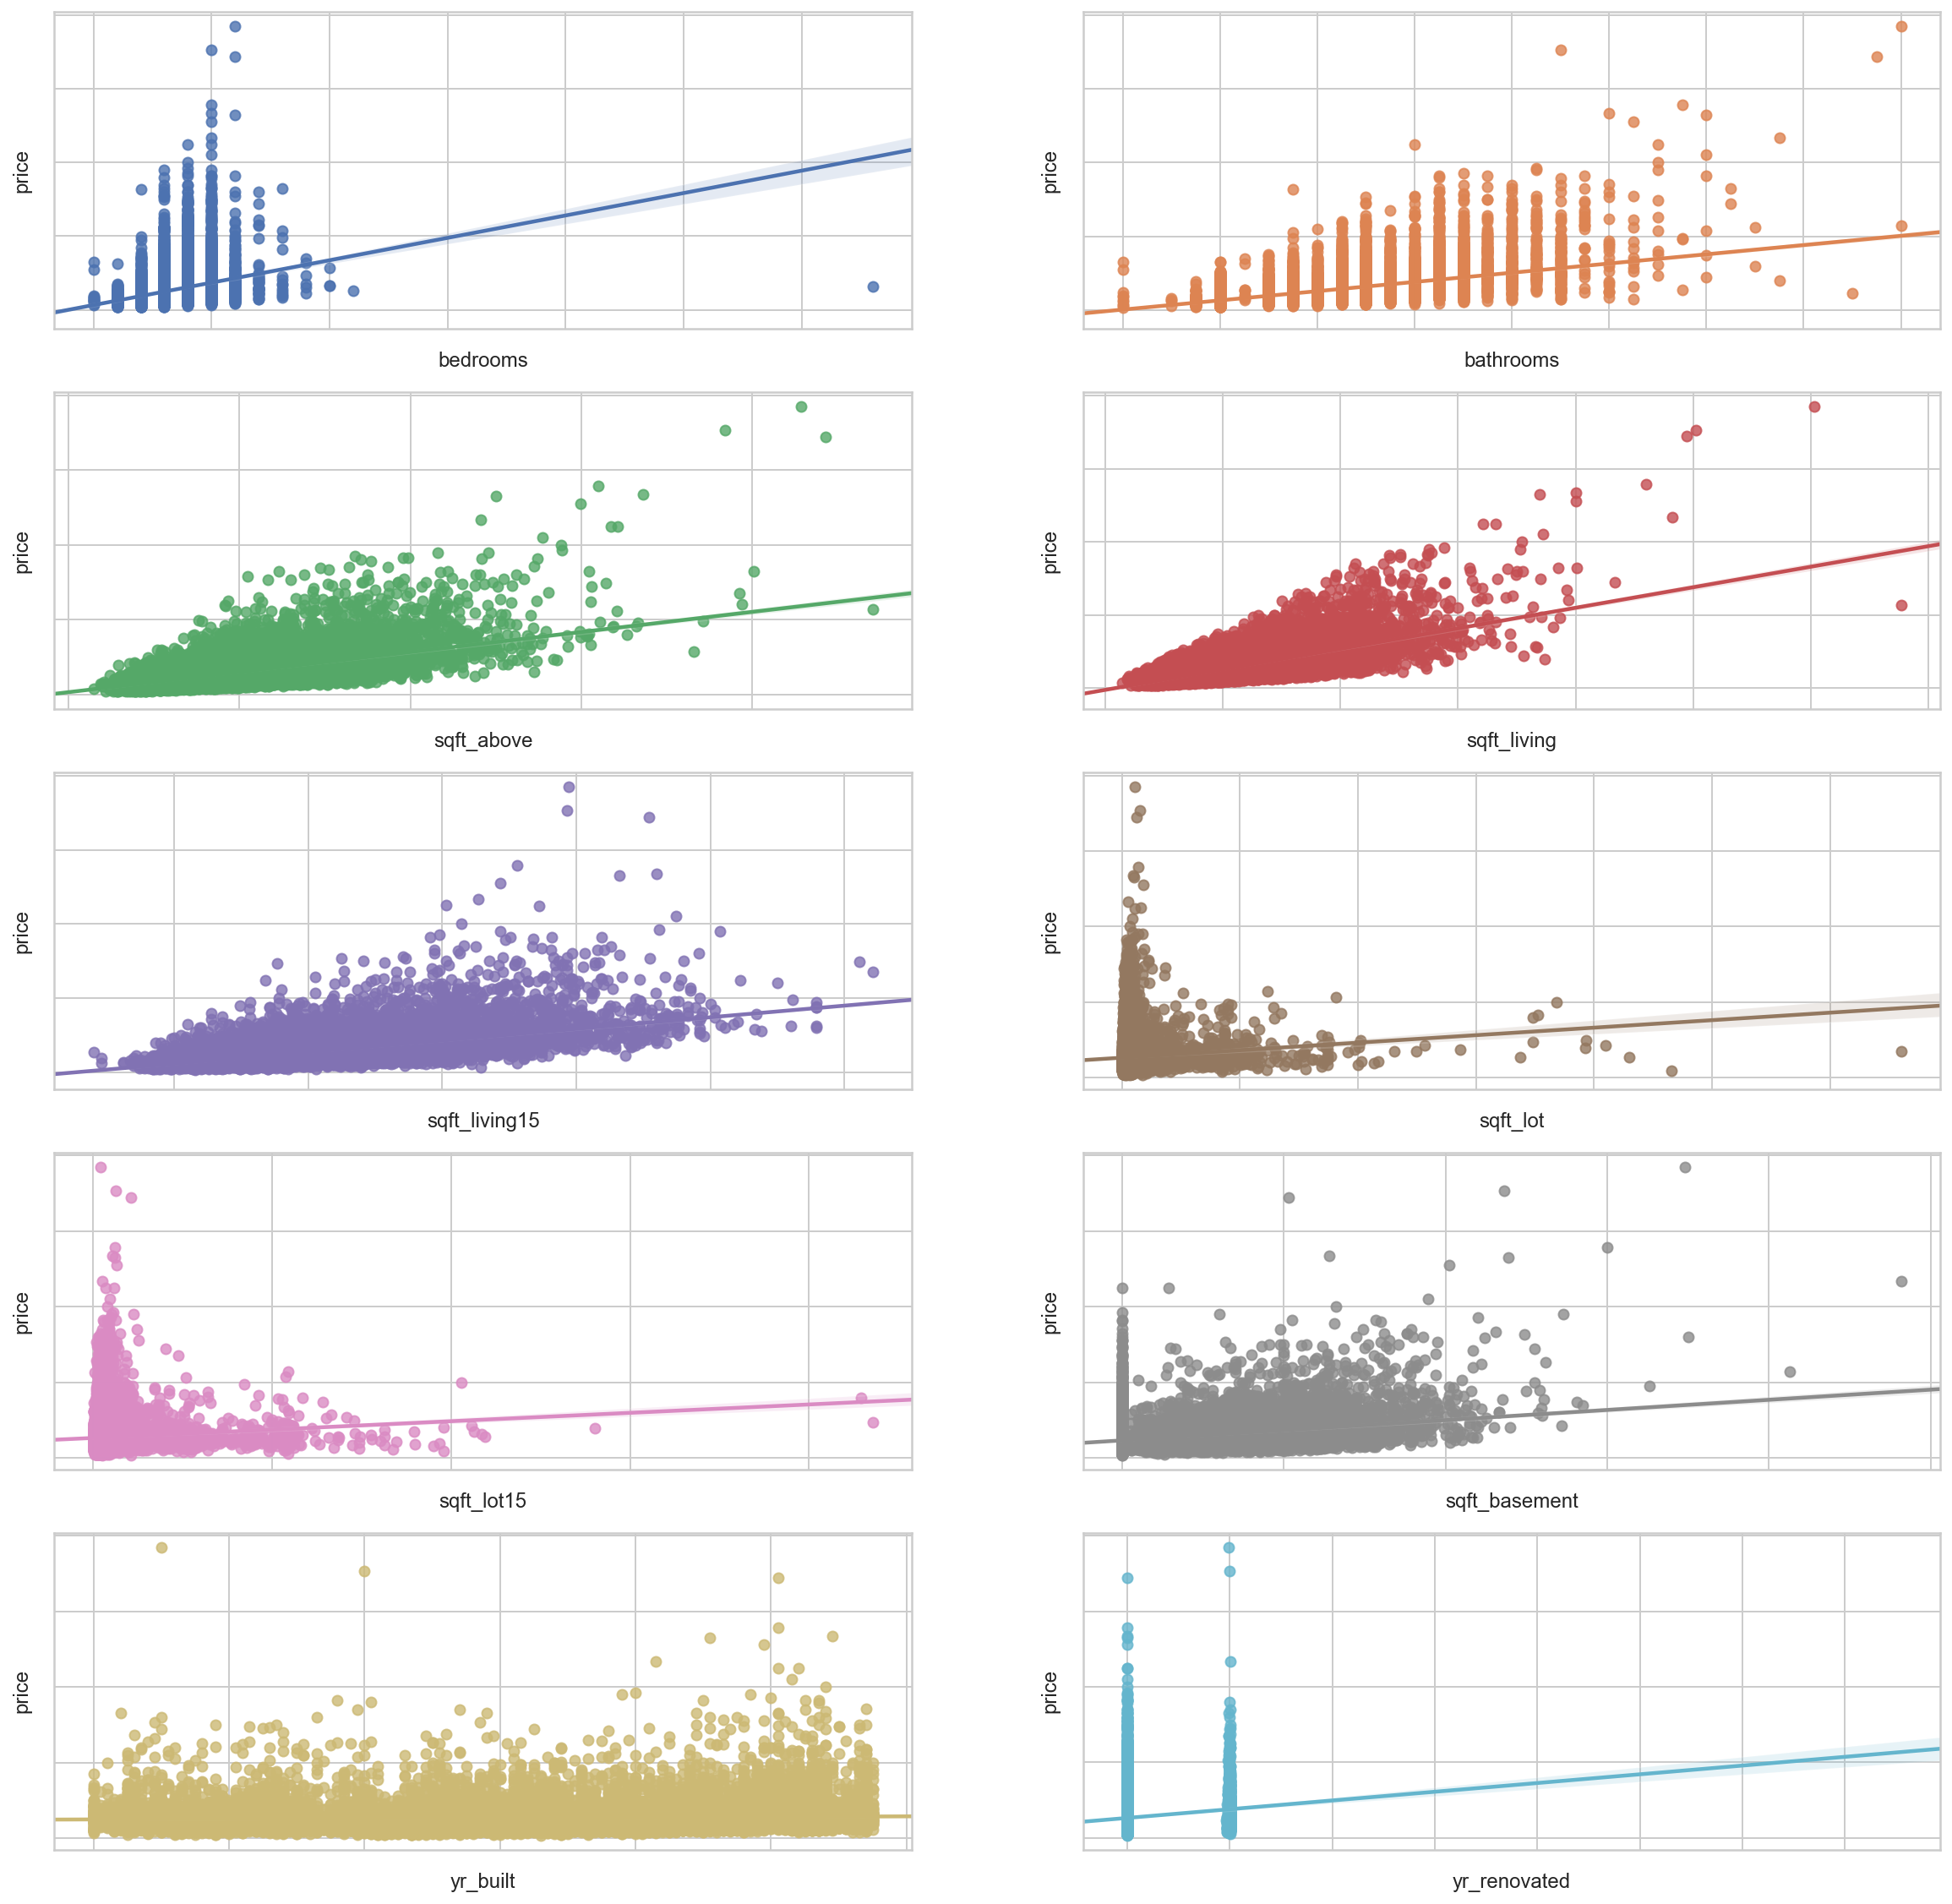

In [14]:
fig, ax = plt.subplots(5,2, figsize = (20,20))

for idx, n in enumerate(col_num):
    if n == 'price':
        continue
    sns.regplot(x=n, y='price', data=df, ax = ax[idx//2,idx%2])
    ax[idx//2, idx % 2].set(yticklabels=[])
    ax[idx//2, idx % 2].set(xticklabels=[])
    
    continue

#### (2) Categorical 변수의 그래프

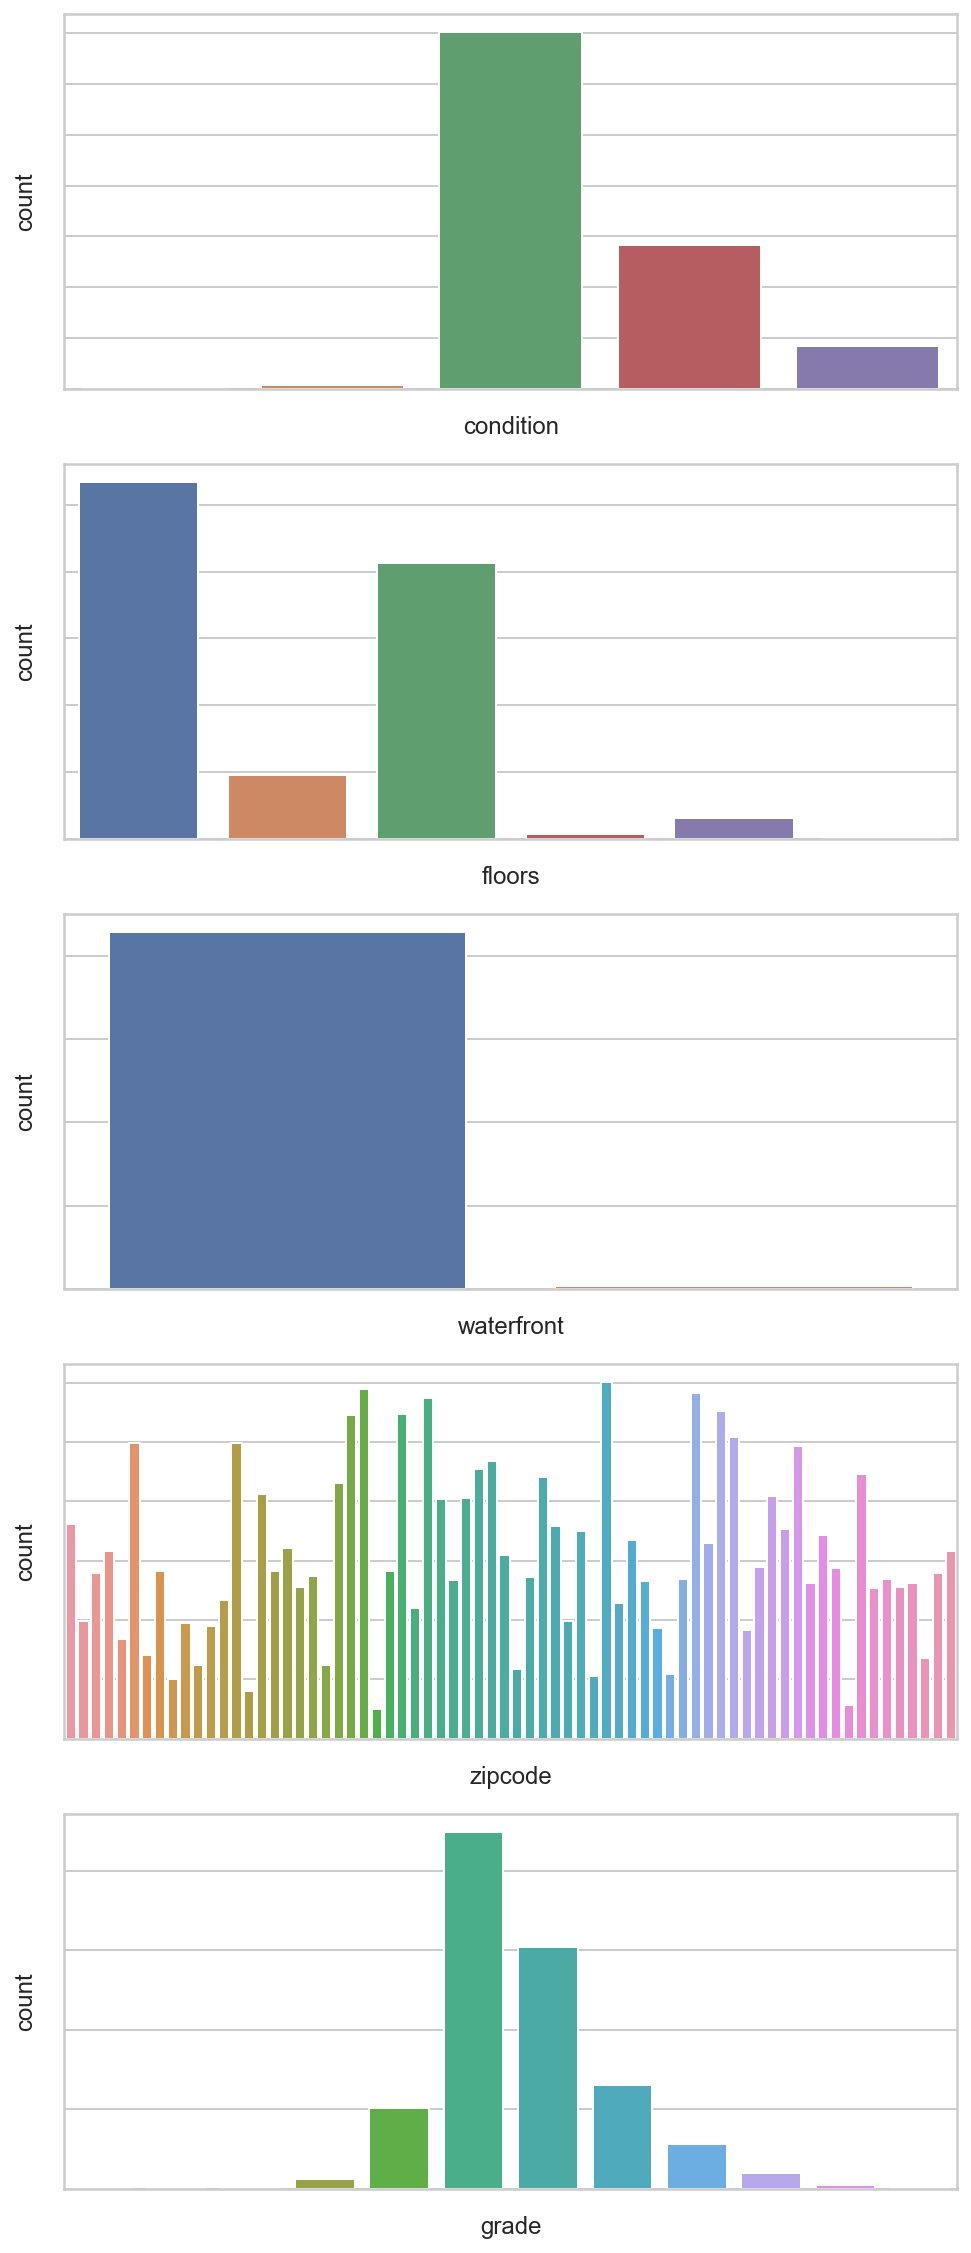

In [15]:
fig, ax = plt.subplots(5, figsize = (8,20))

for idx, n in enumerate(col_cat):
    if n == 'price':
        continue
    sns.countplot(x=n, data=df, ax = ax[idx])
    ax[idx].set(yticklabels=[])
    ax[idx].set(xticklabels=[])
    
    continue

## 2.3 Histograms

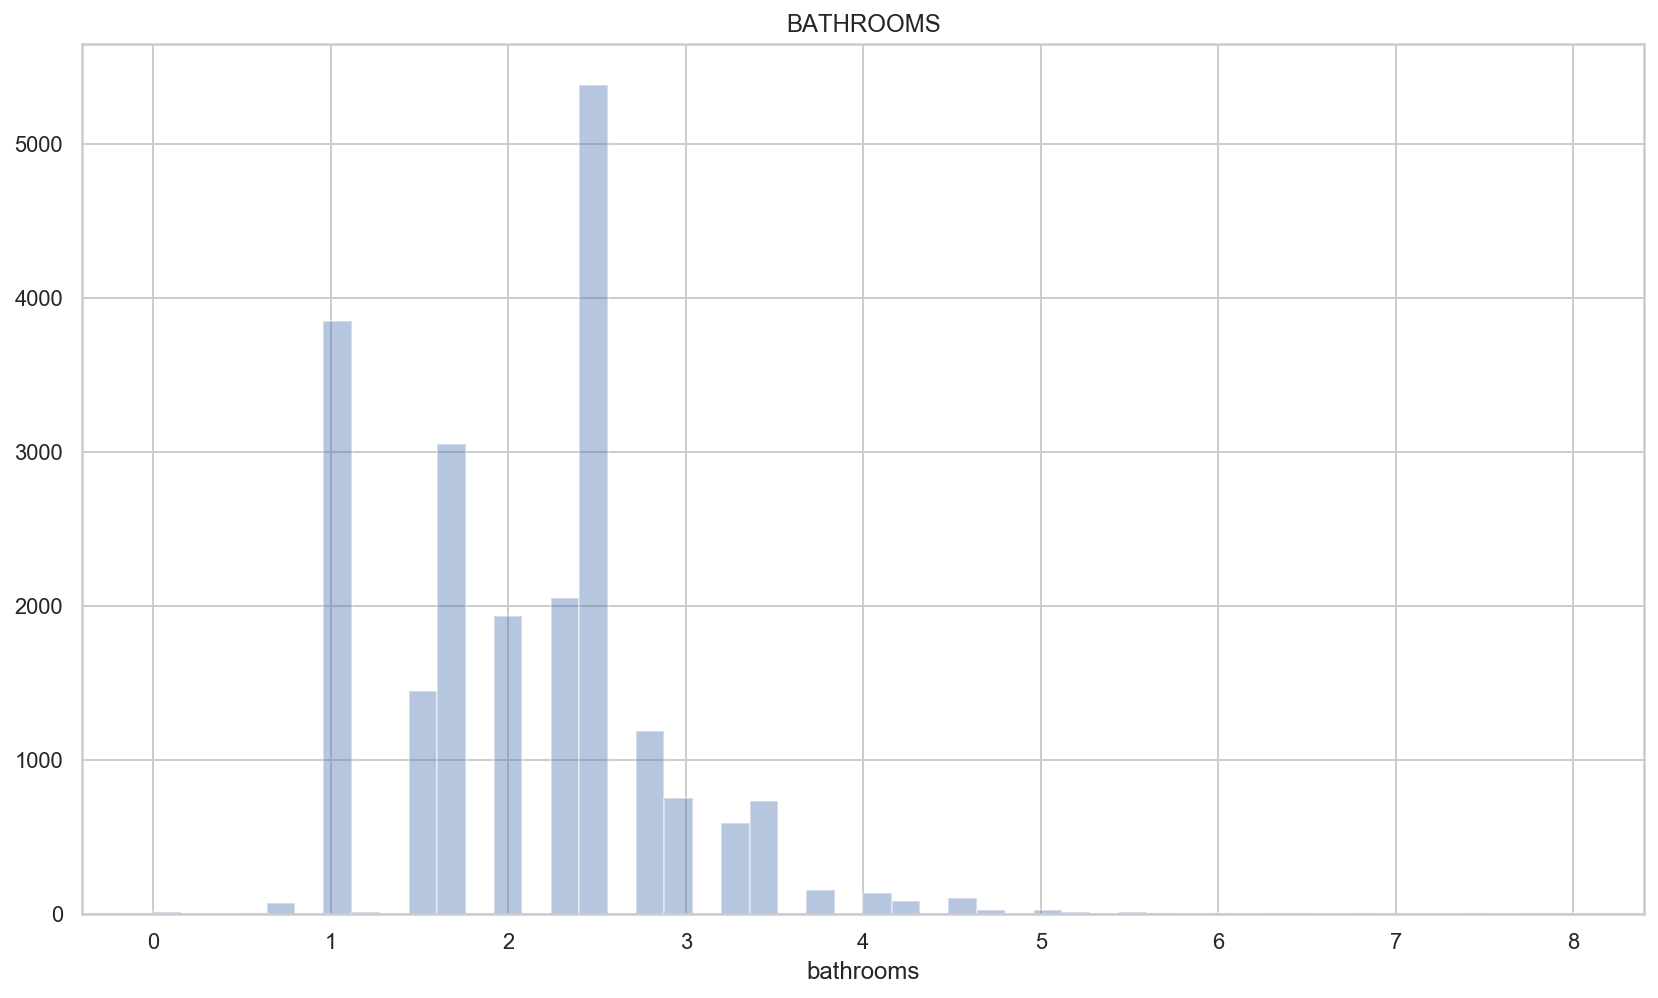

count    21613.000000
mean         2.114757
std          0.770163
min          0.000000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64


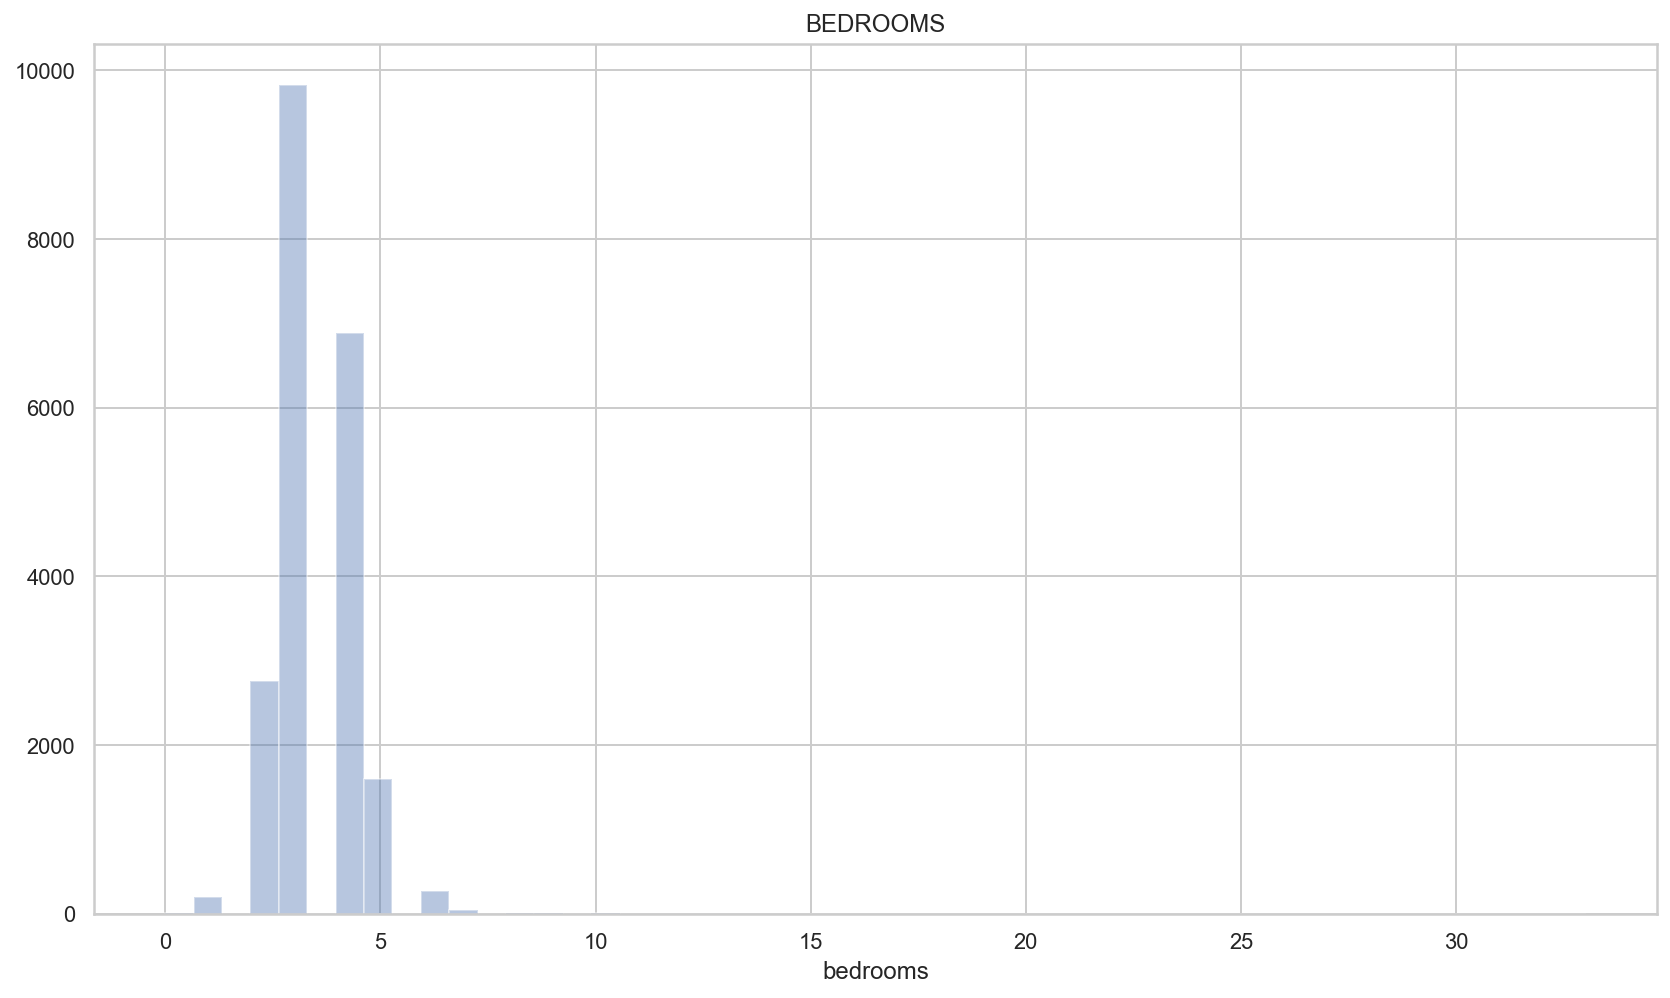

count    21613.000000
mean         3.370842
std          0.930062
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64


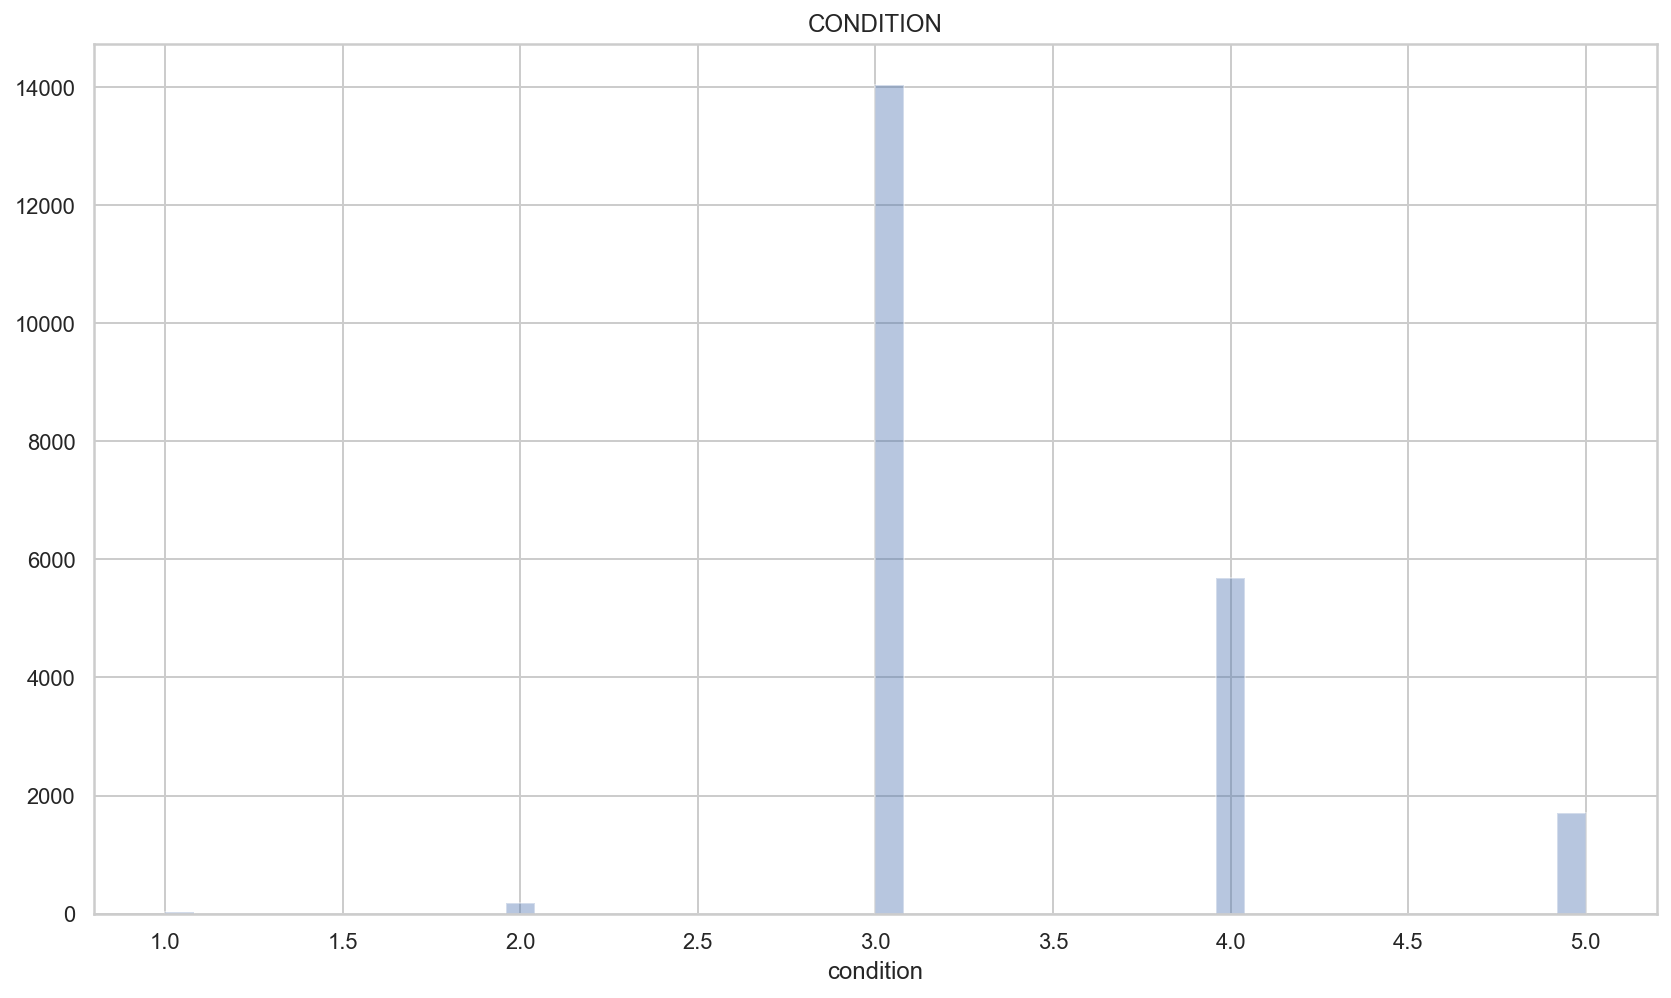

count    21613.000000
mean         3.409430
std          0.650743
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64


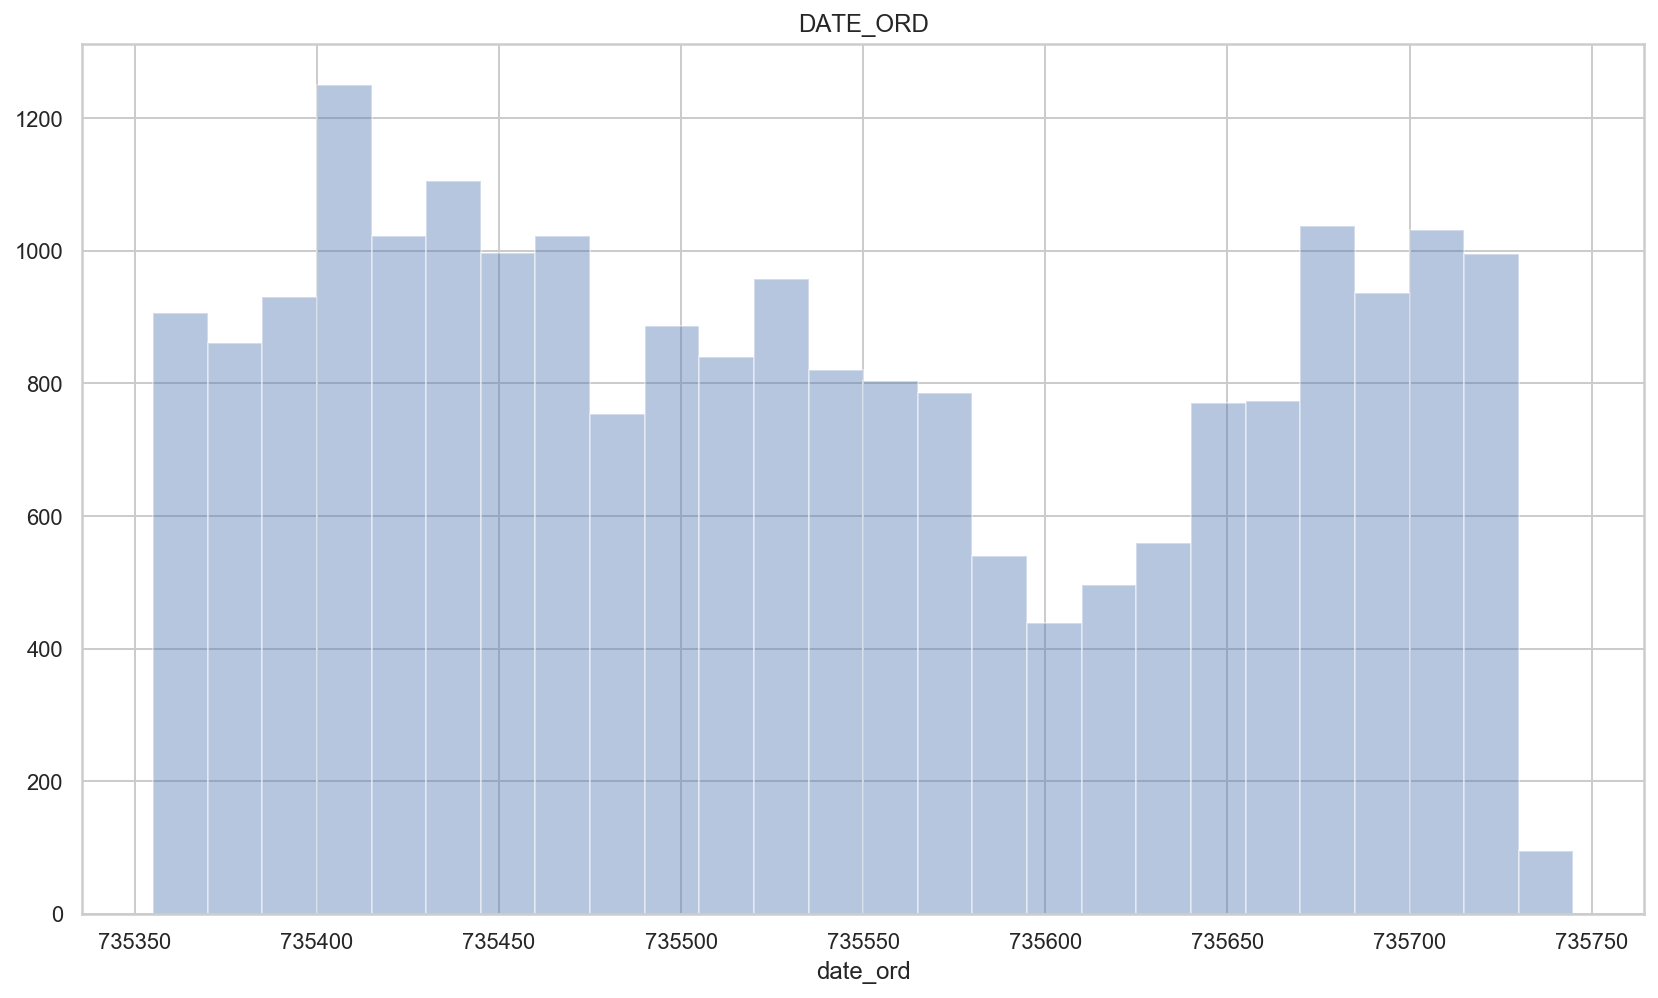

count     21613.000000
mean     735535.193078
std         113.048011
min      735355.000000
25%      735436.000000
50%      735522.000000
75%      735646.000000
max      735745.000000
Name: date_ord, dtype: float64


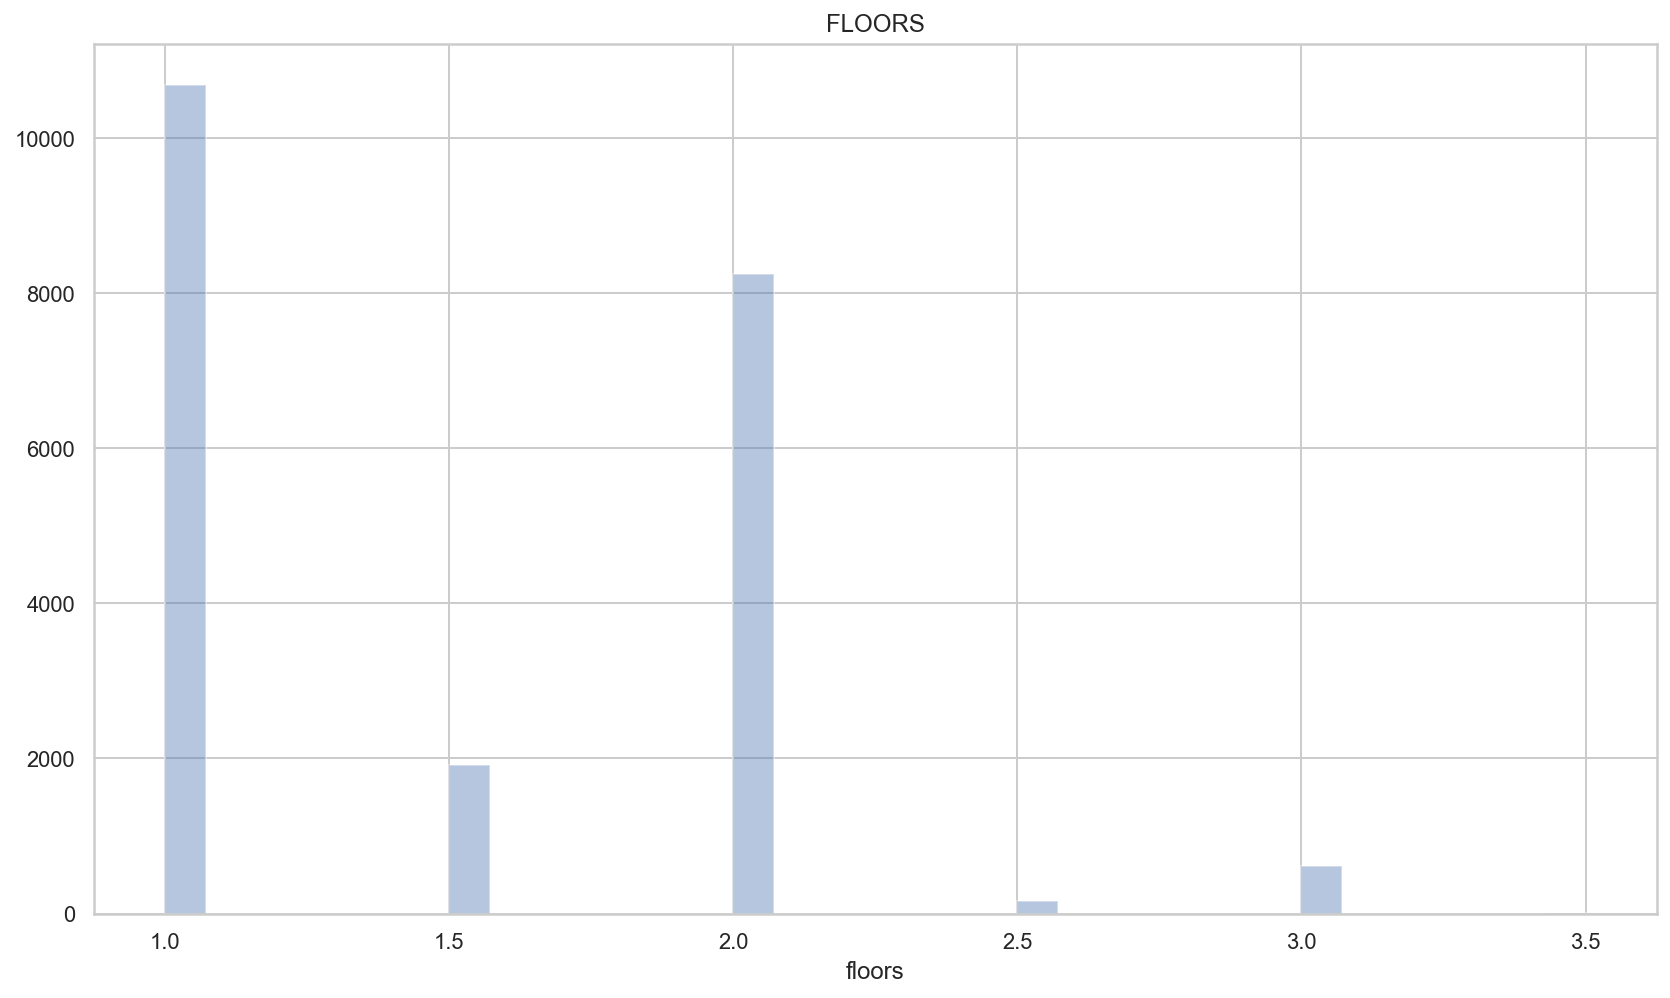

count    21613.000000
mean         1.494309
std          0.539989
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64


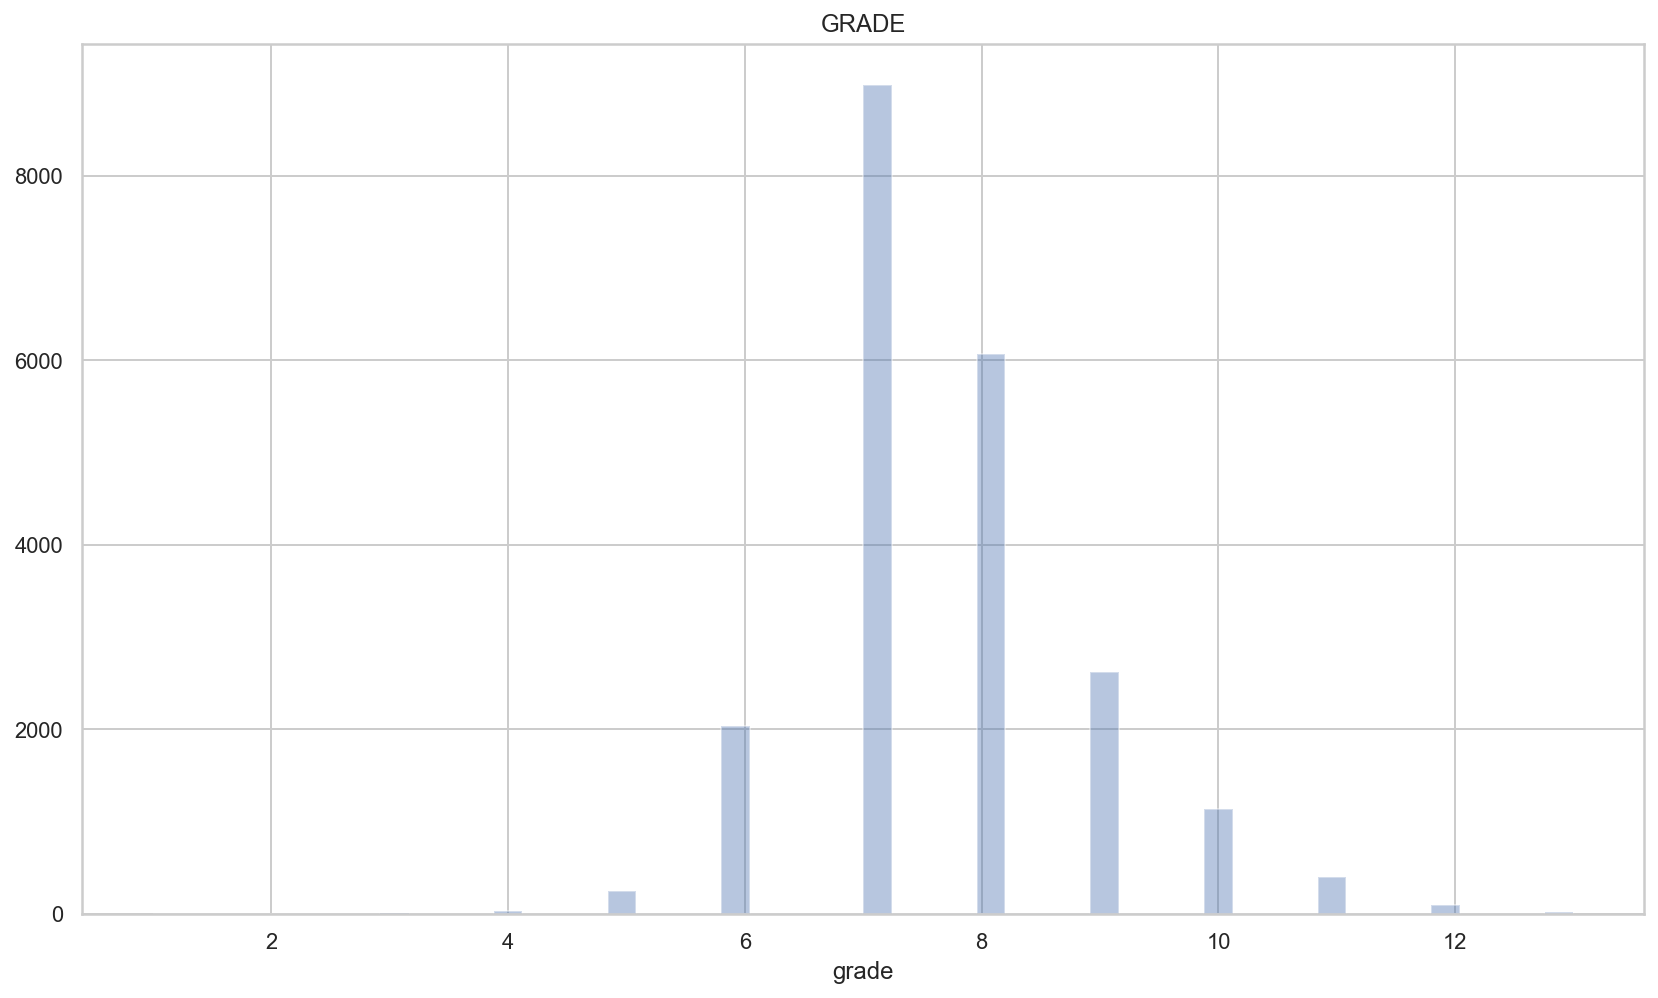

count    21613.000000
mean         7.656873
std          1.175459
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64


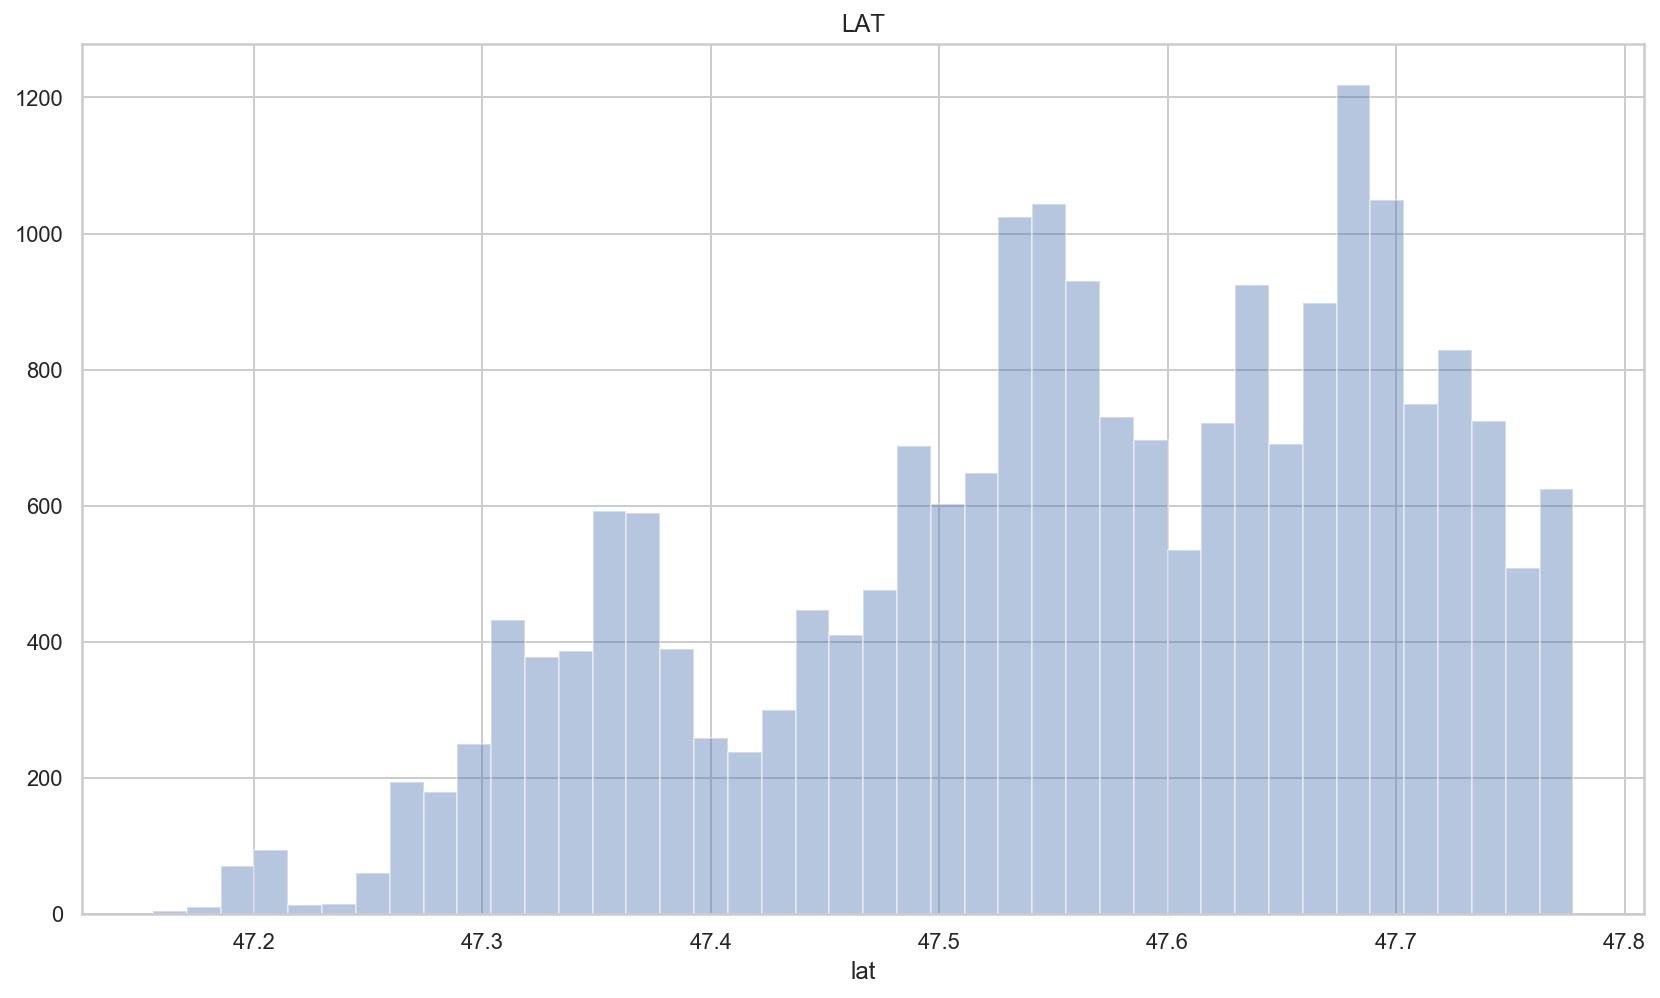

count    21613.000000
mean        47.560053
std          0.138564
min         47.155900
25%         47.471000
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64


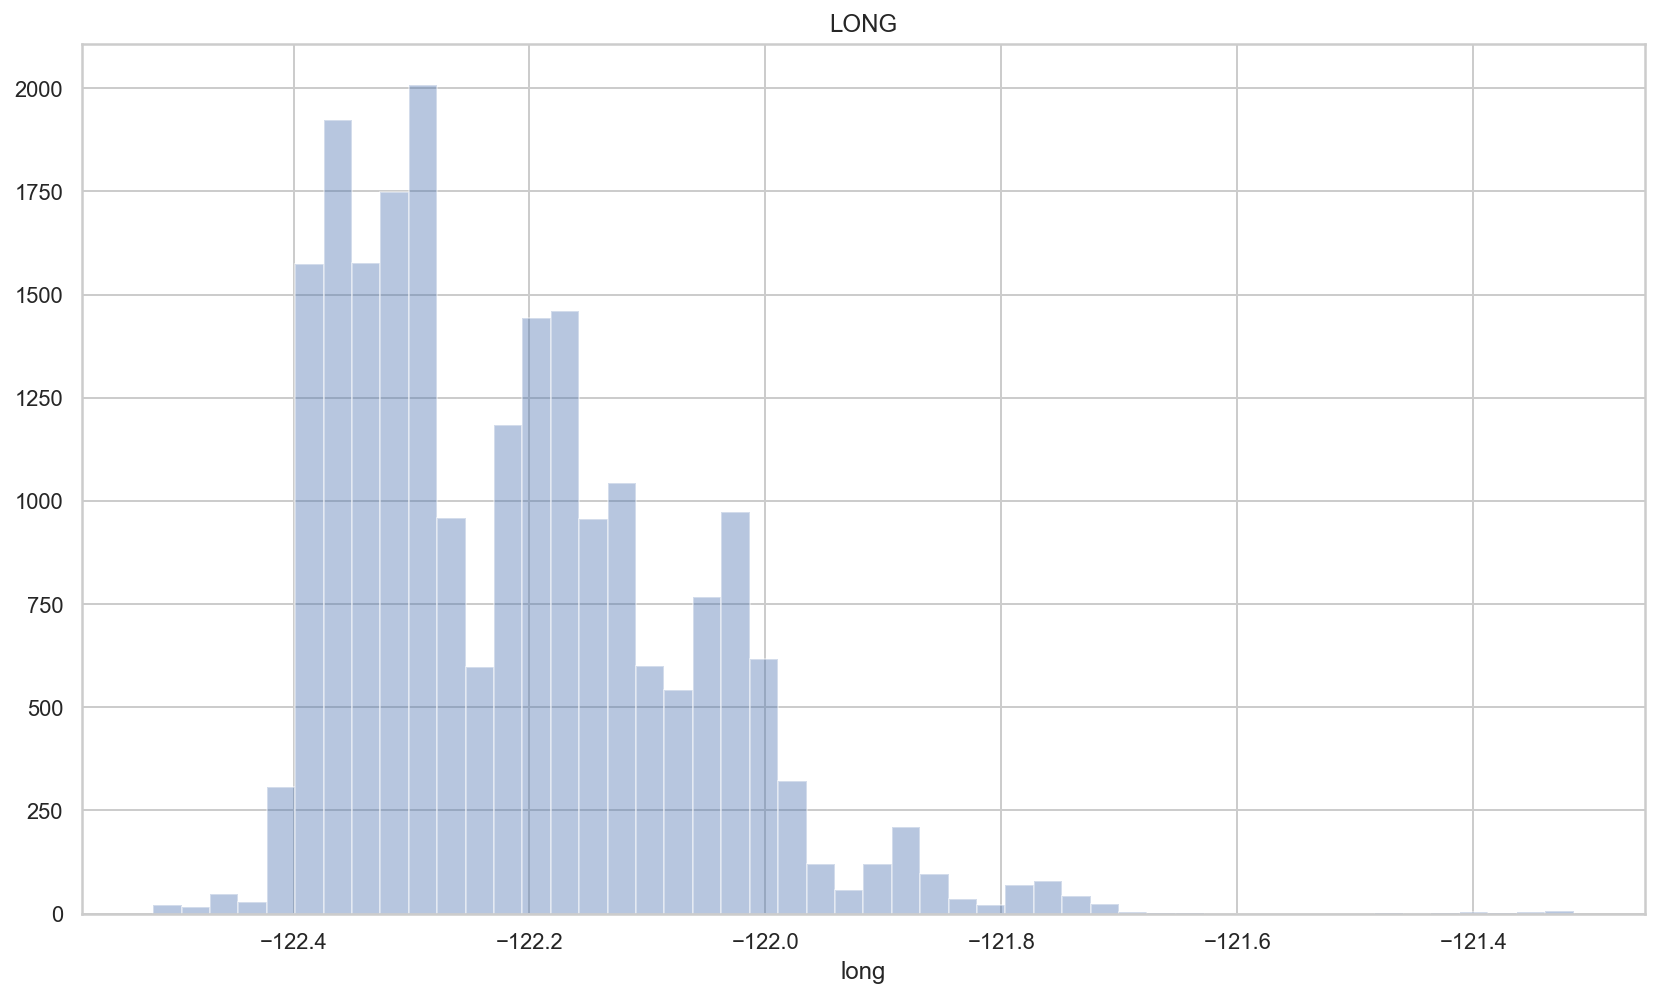

count    21613.000000
mean      -122.213896
std          0.140828
min       -122.519000
25%       -122.328000
50%       -122.230000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64


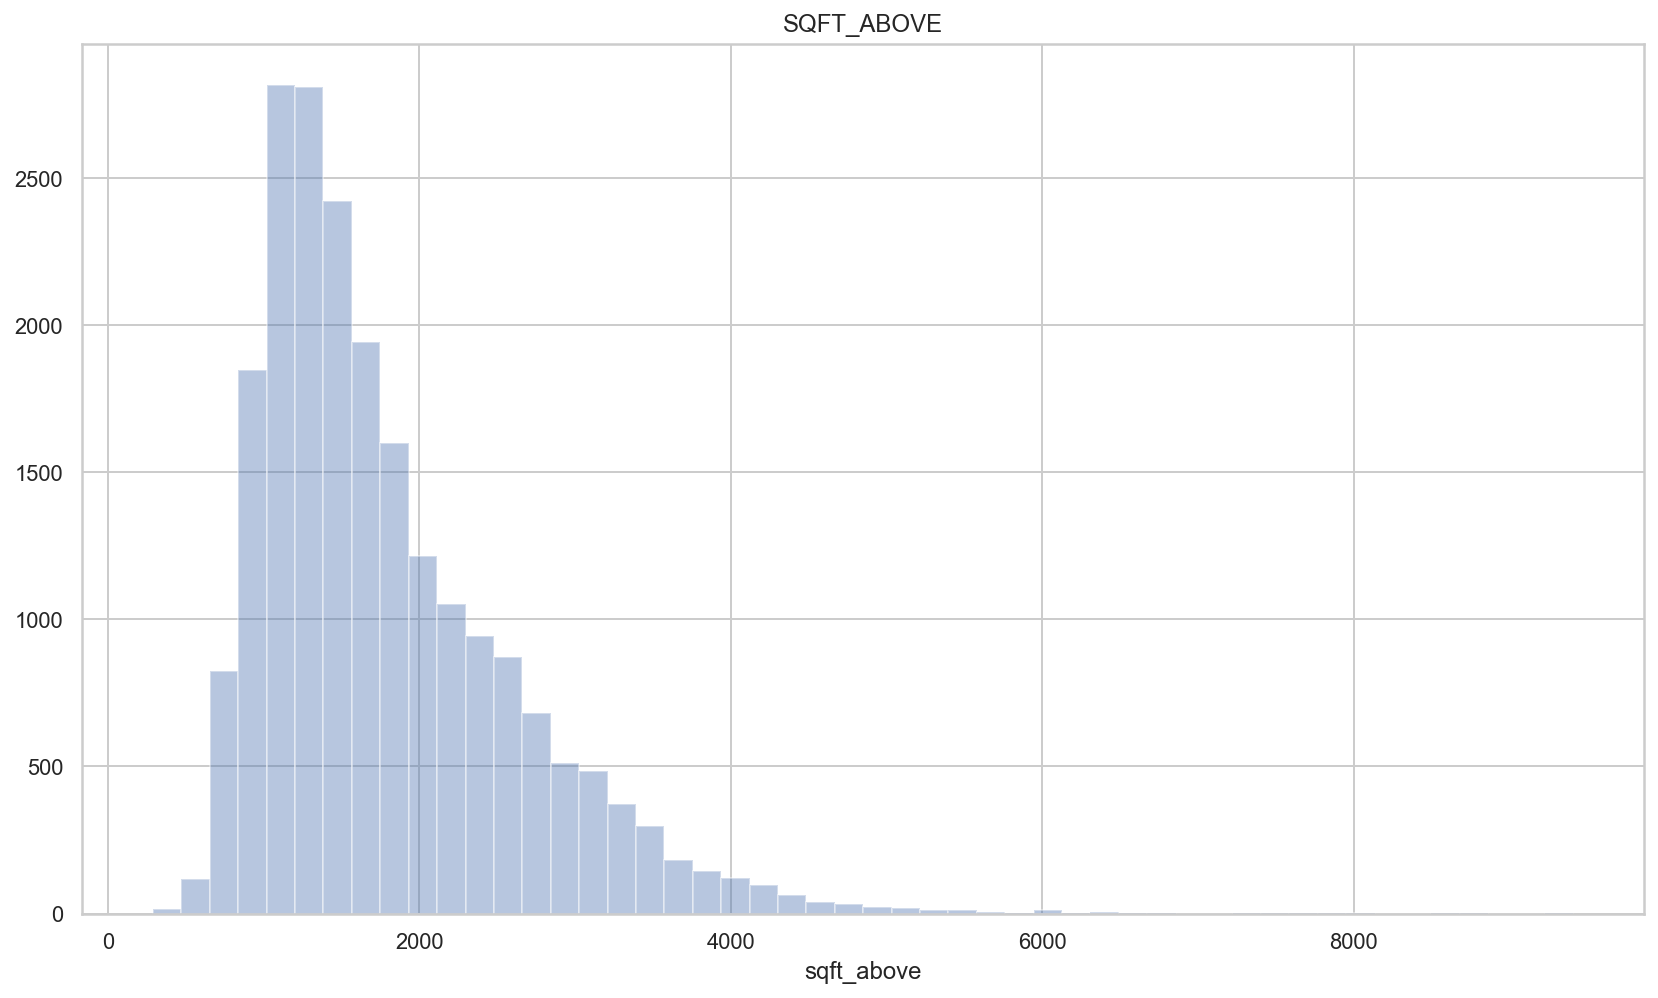

count    21613.000000
mean      1788.390691
std        828.090978
min        290.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64


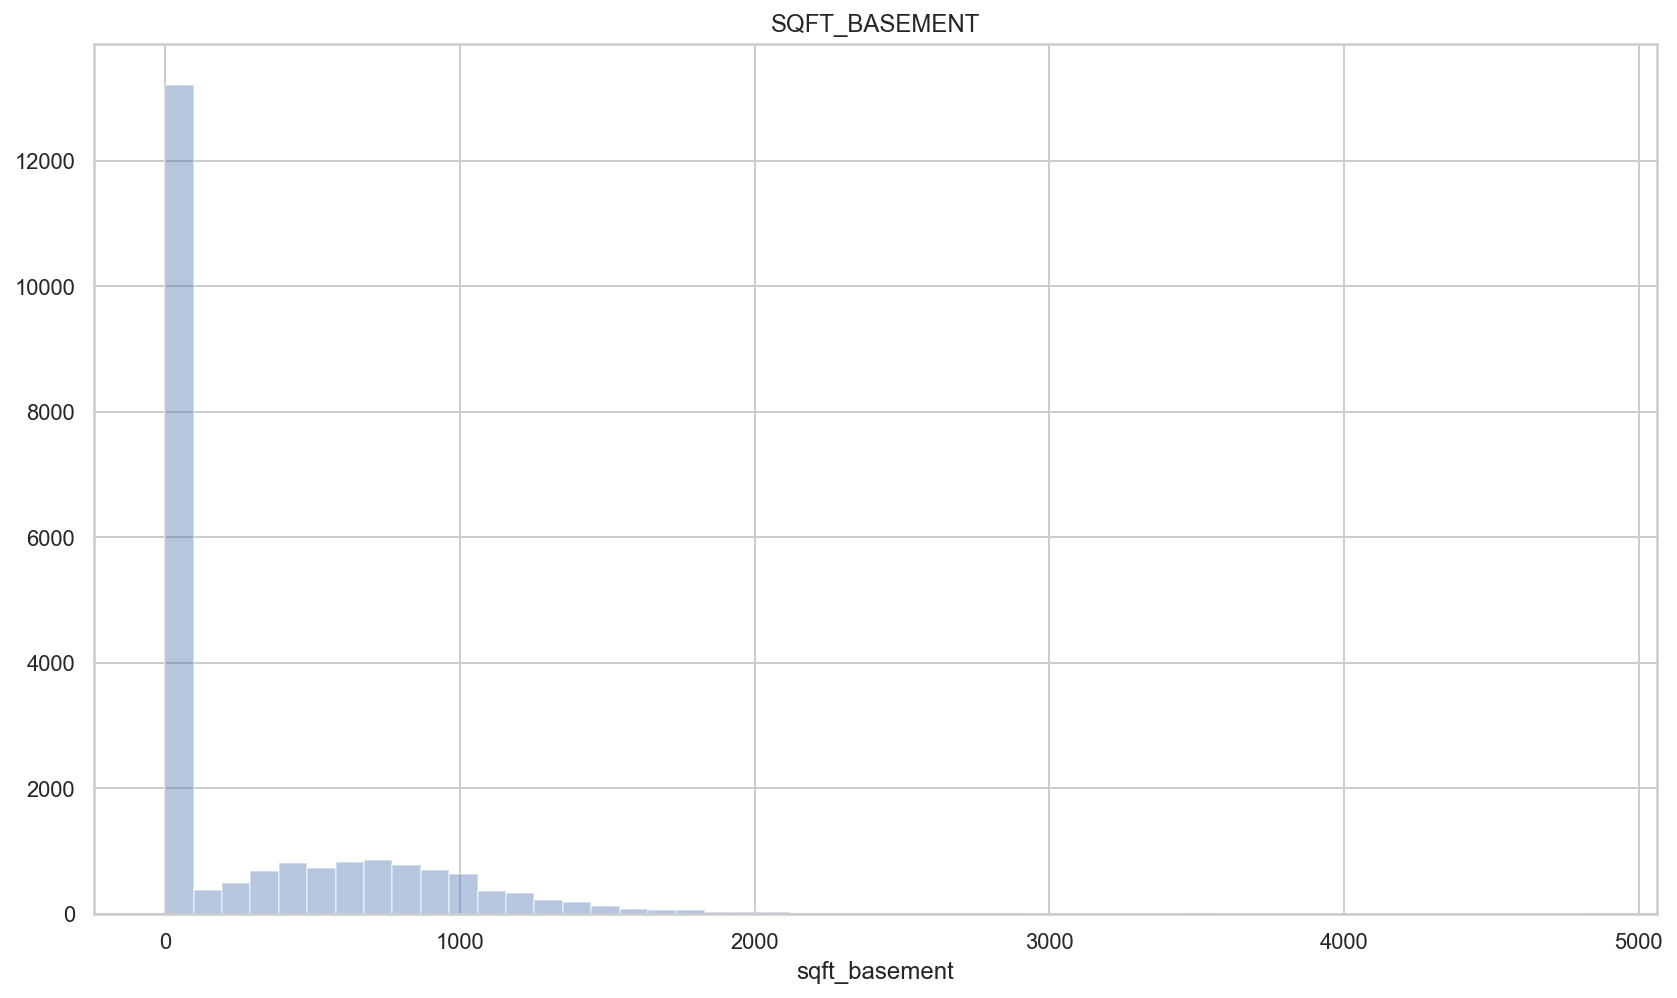

count    21613.000000
mean       291.509045
std        442.575043
min          0.000000
25%          0.000000
50%          0.000000
75%        560.000000
max       4820.000000
Name: sqft_basement, dtype: float64


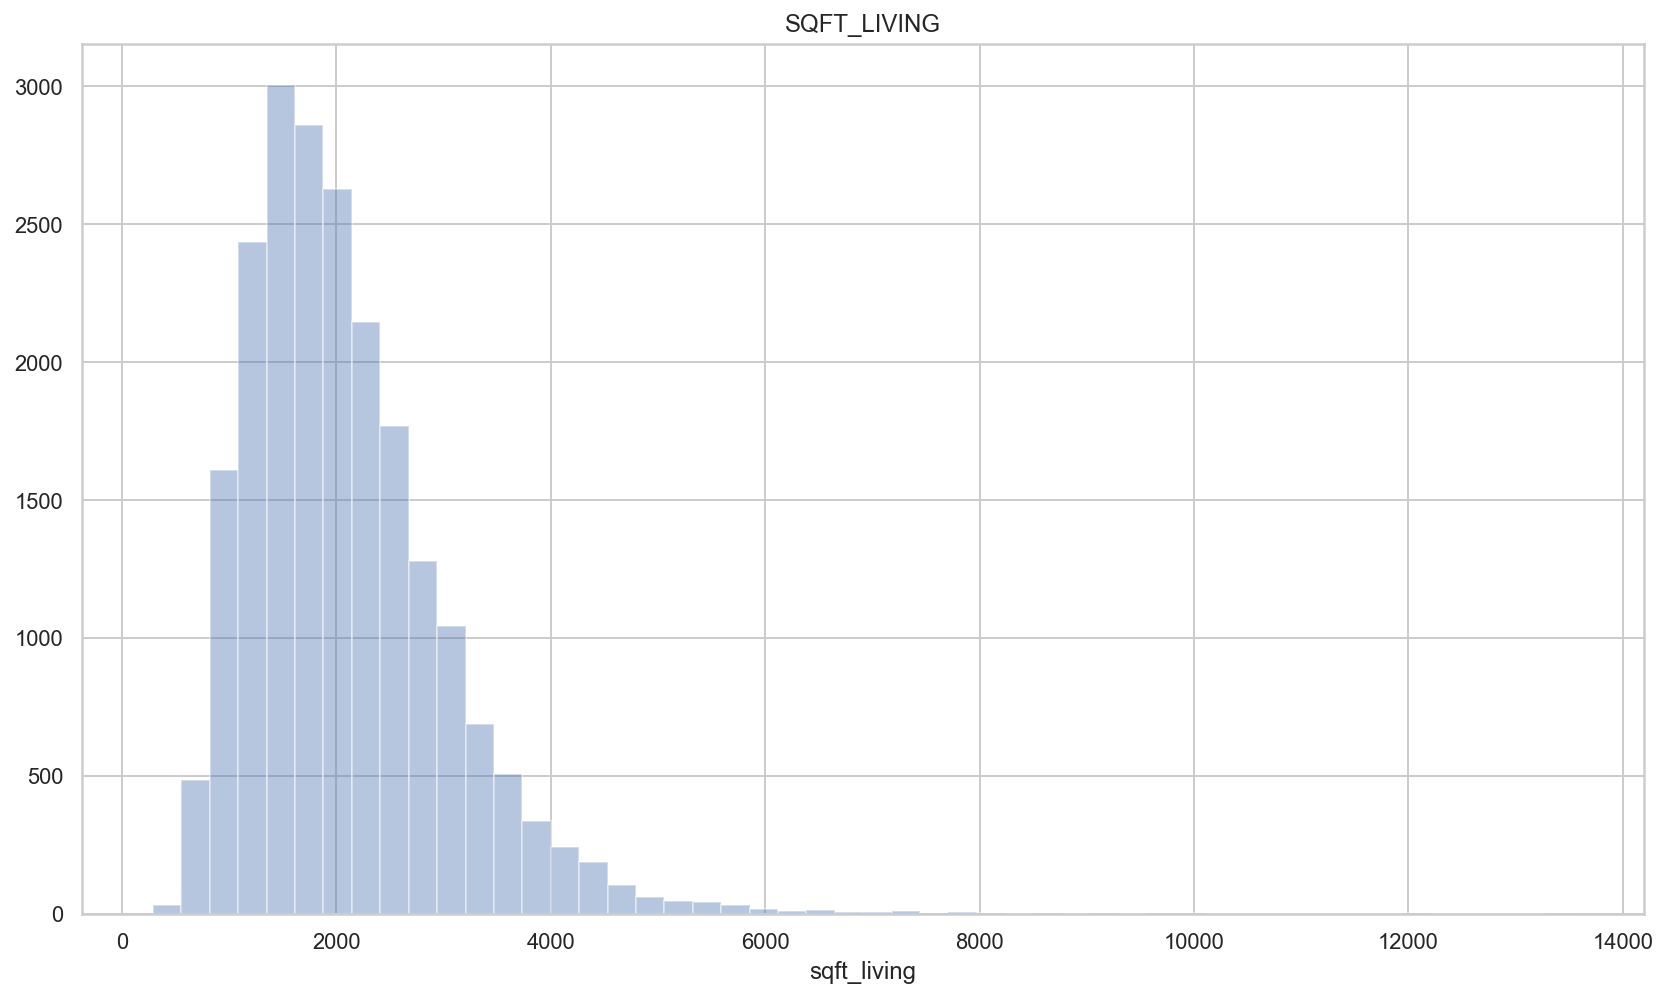

count    21613.000000
mean      2079.899736
std        918.440897
min        290.000000
25%       1427.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64


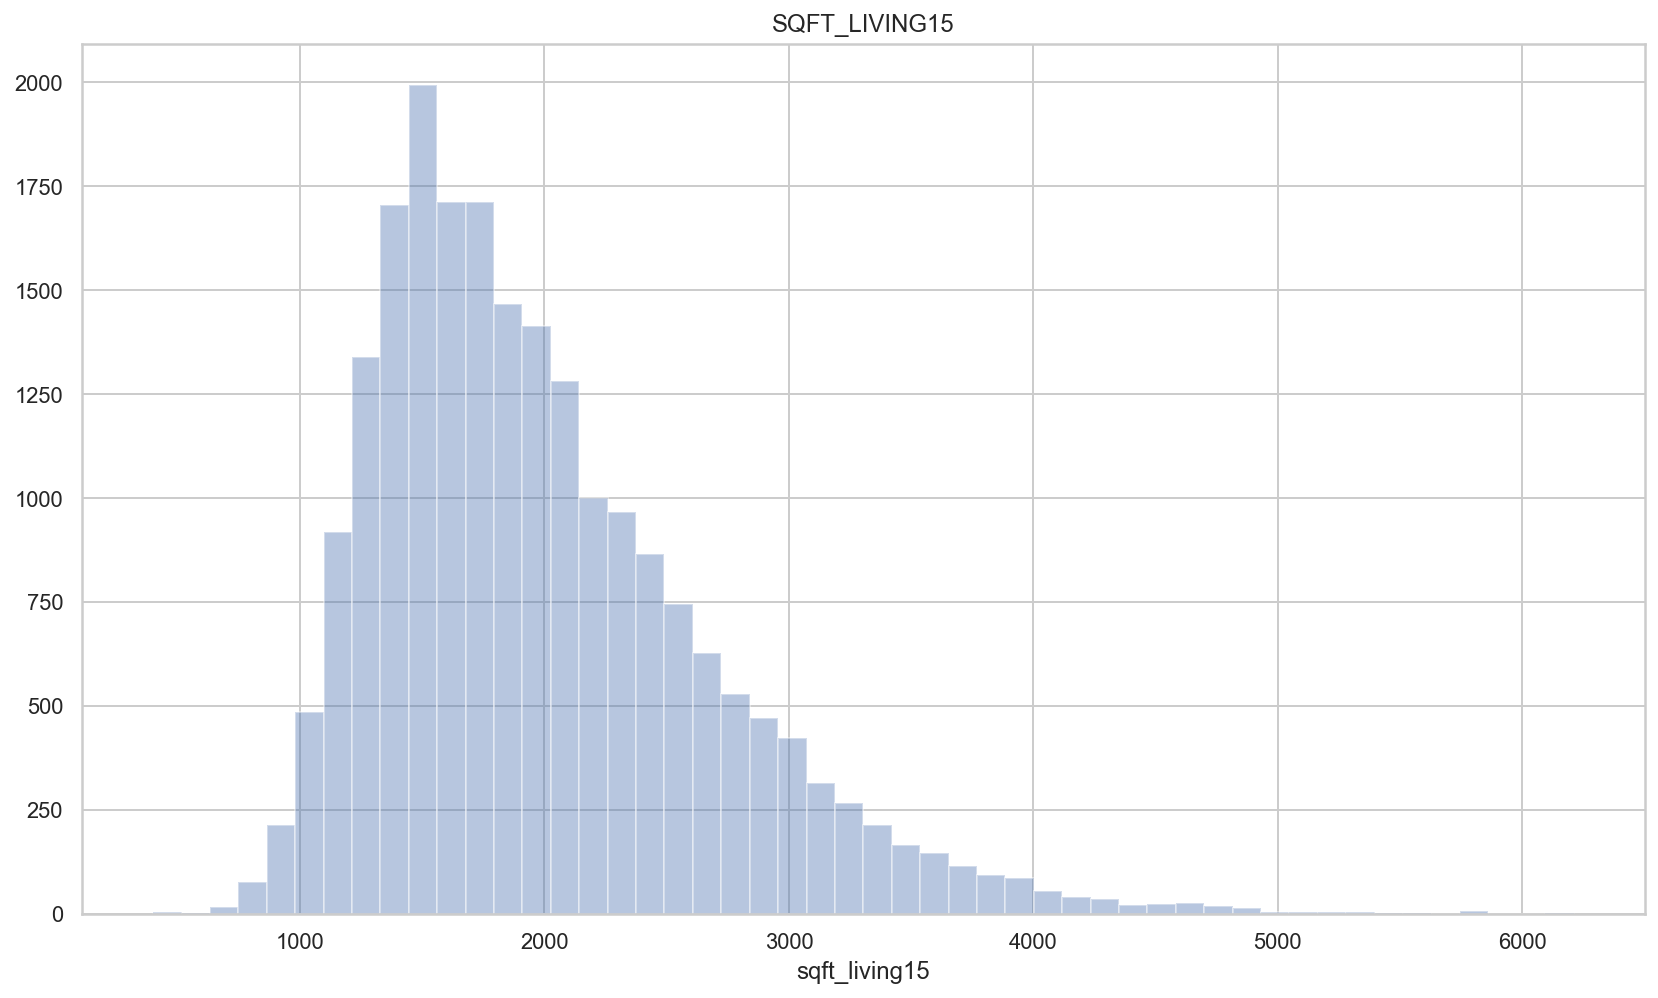

count    21613.000000
mean      1986.552492
std        685.391304
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64


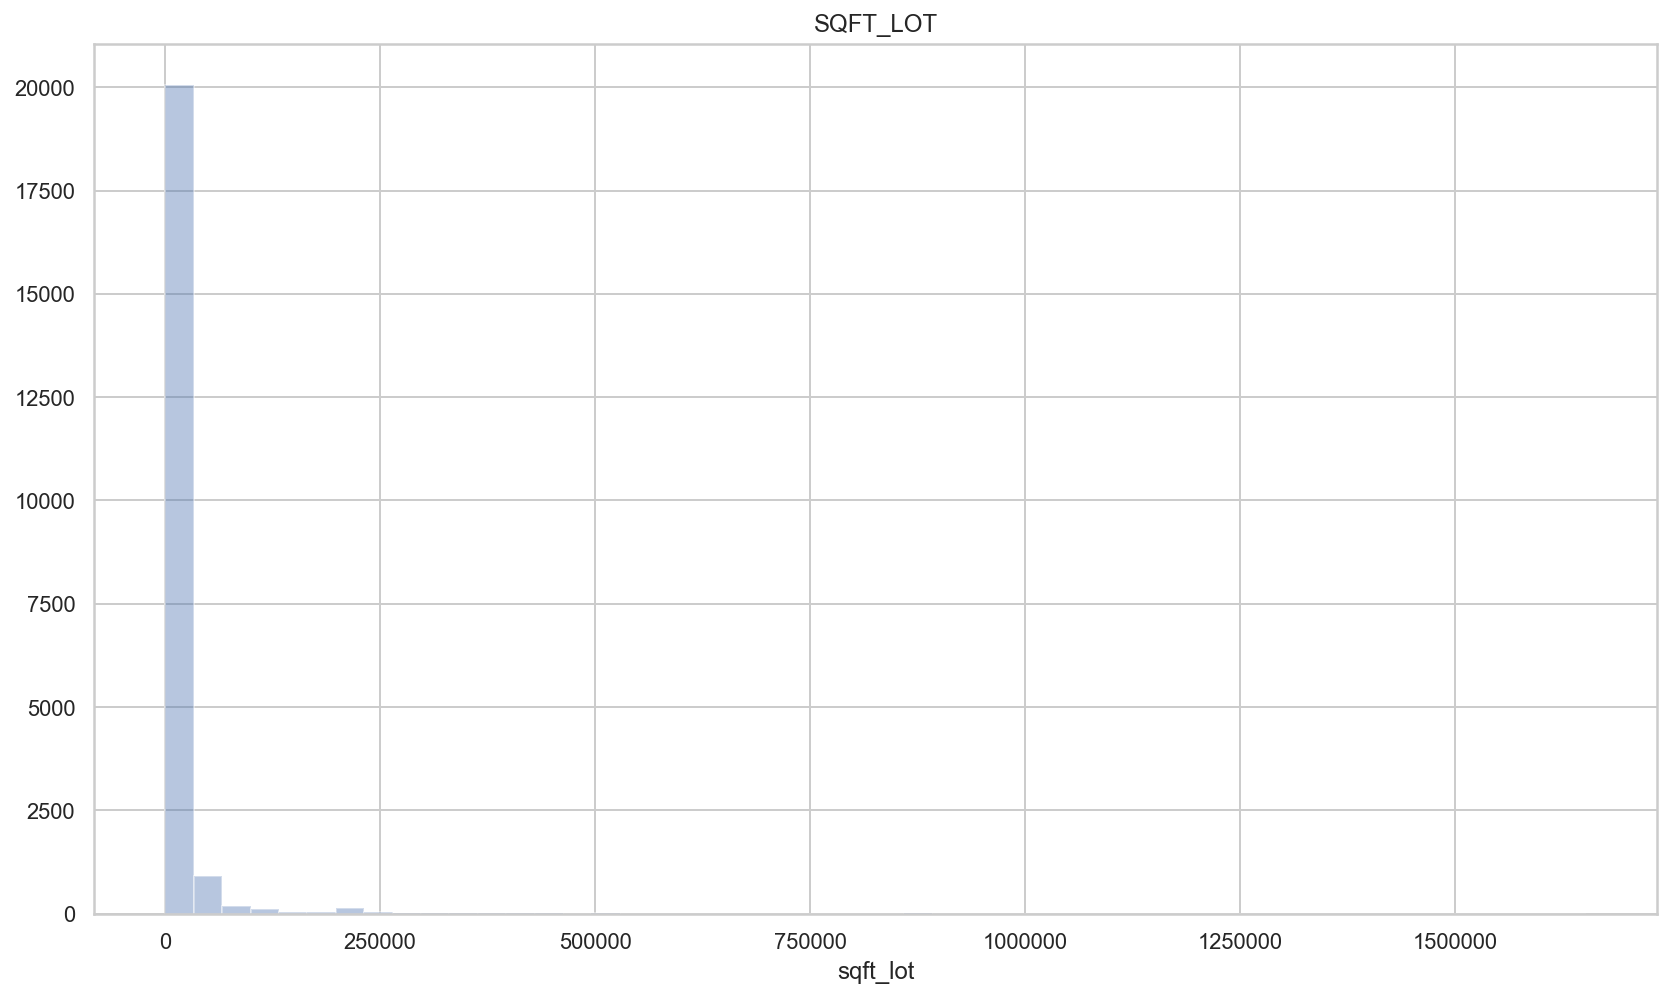

count    2.161300e+04
mean     1.510697e+04
std      4.142051e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068800e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64


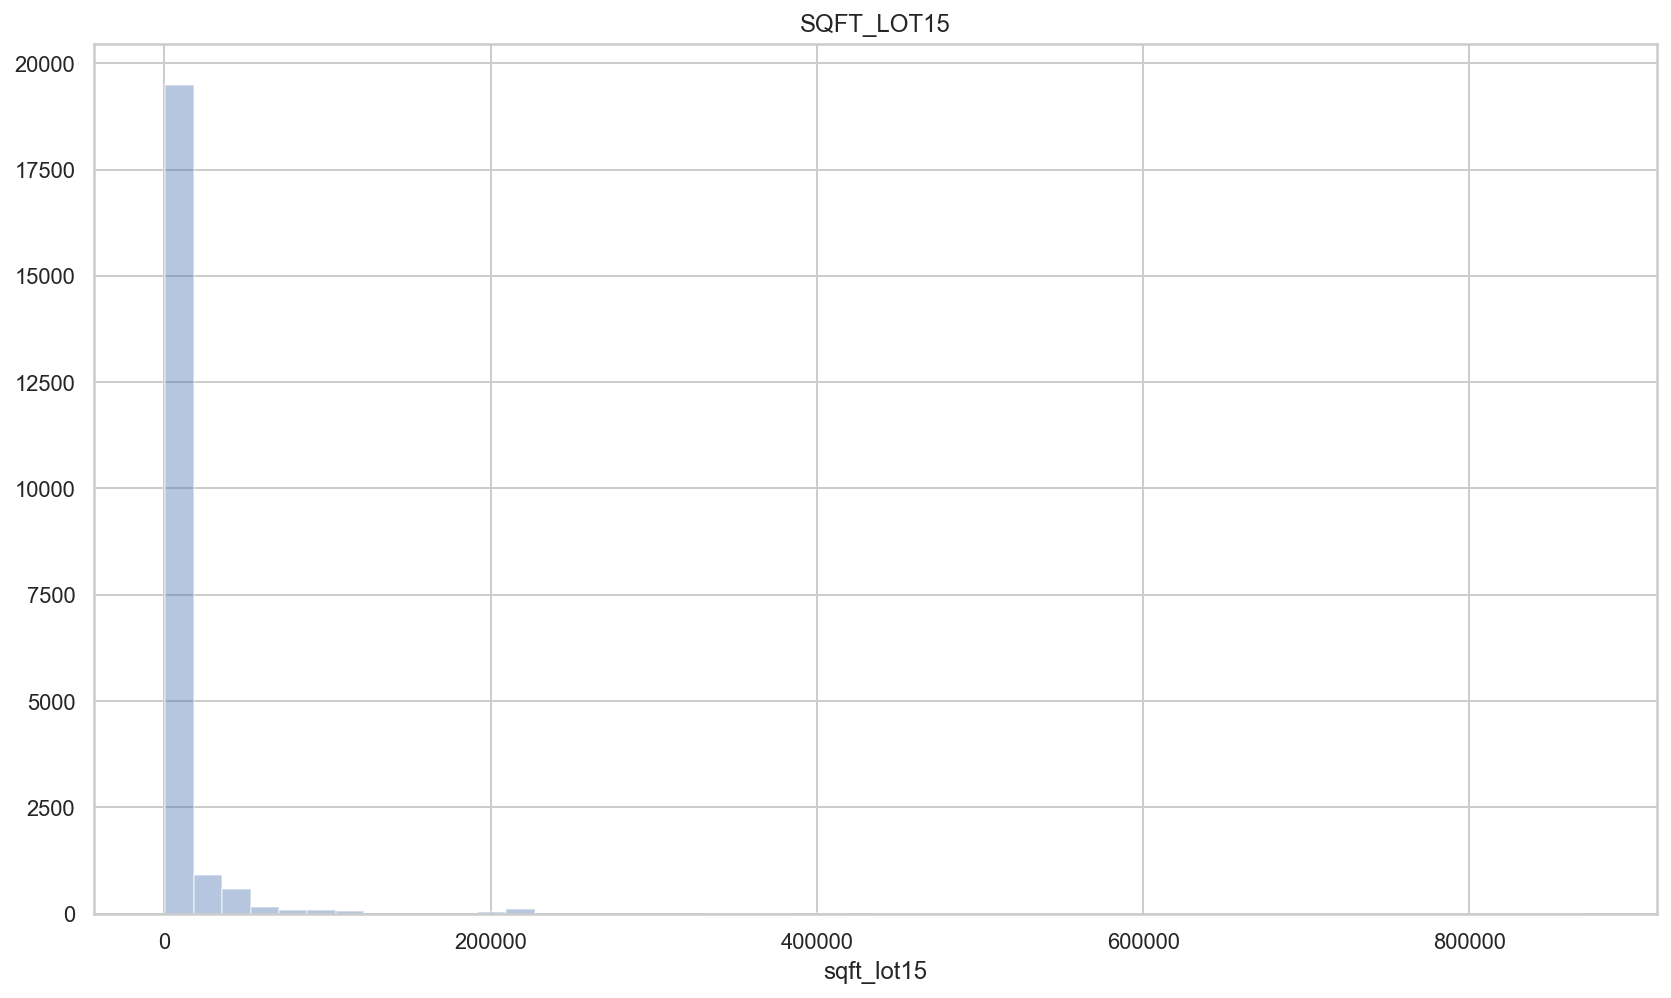

count     21613.000000
mean      12768.455652
std       27304.179631
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64


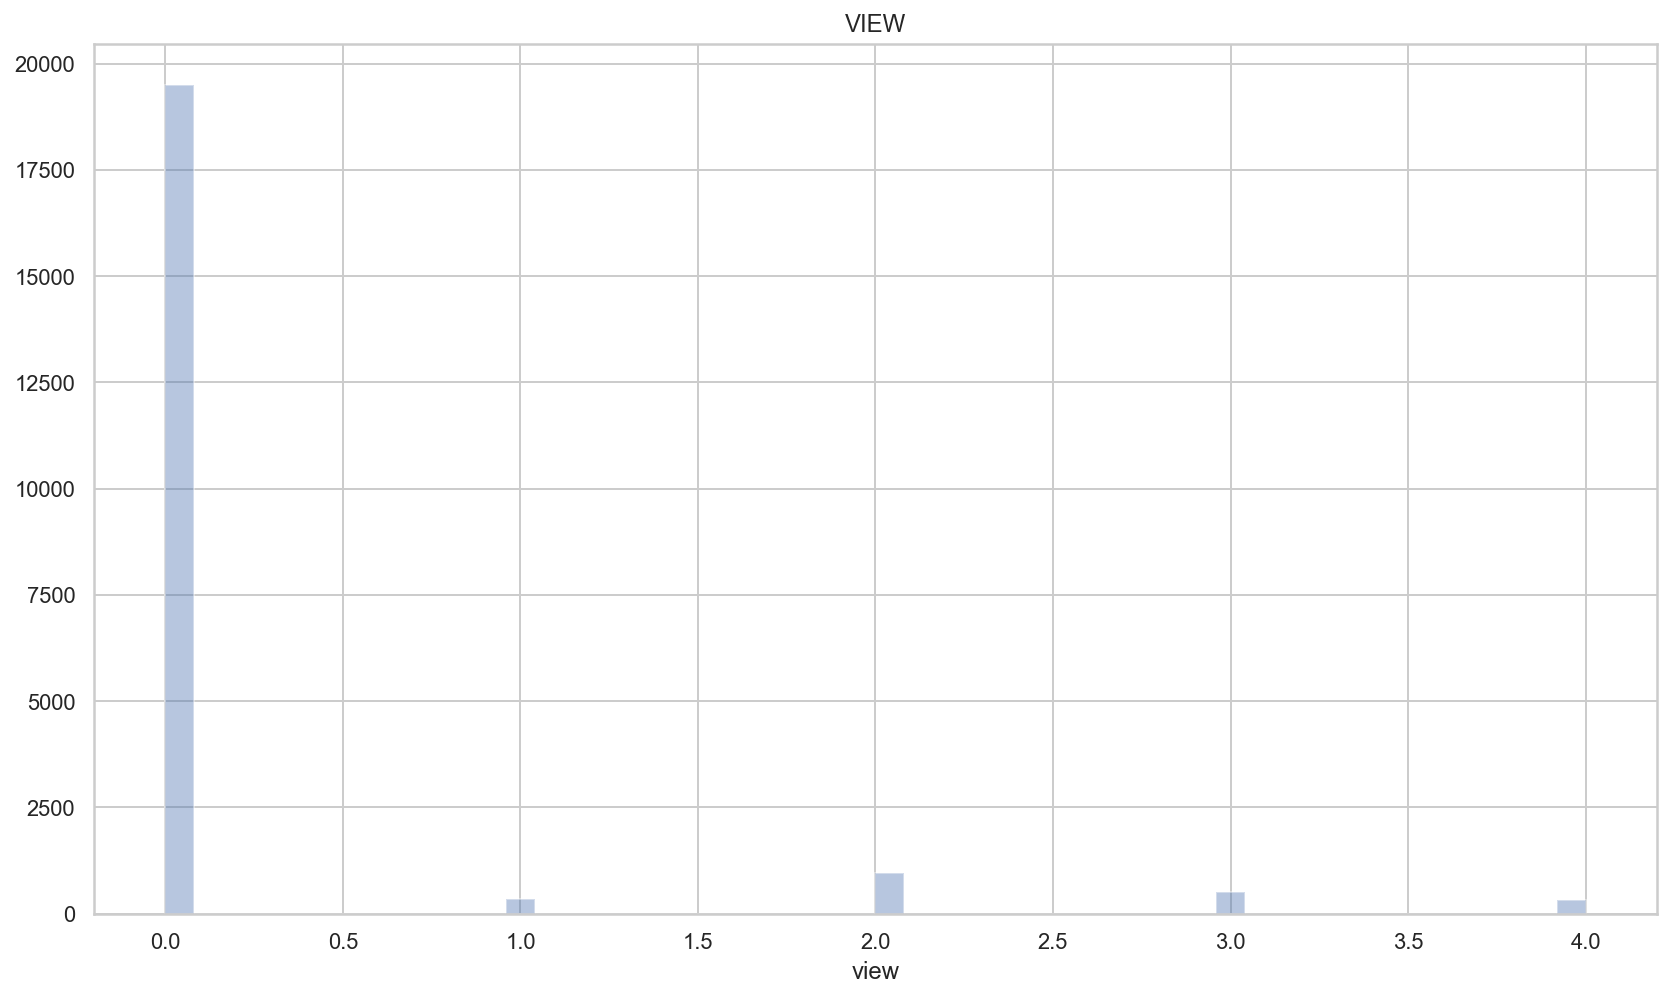

count    21613.000000
mean         0.234303
std          0.766318
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64


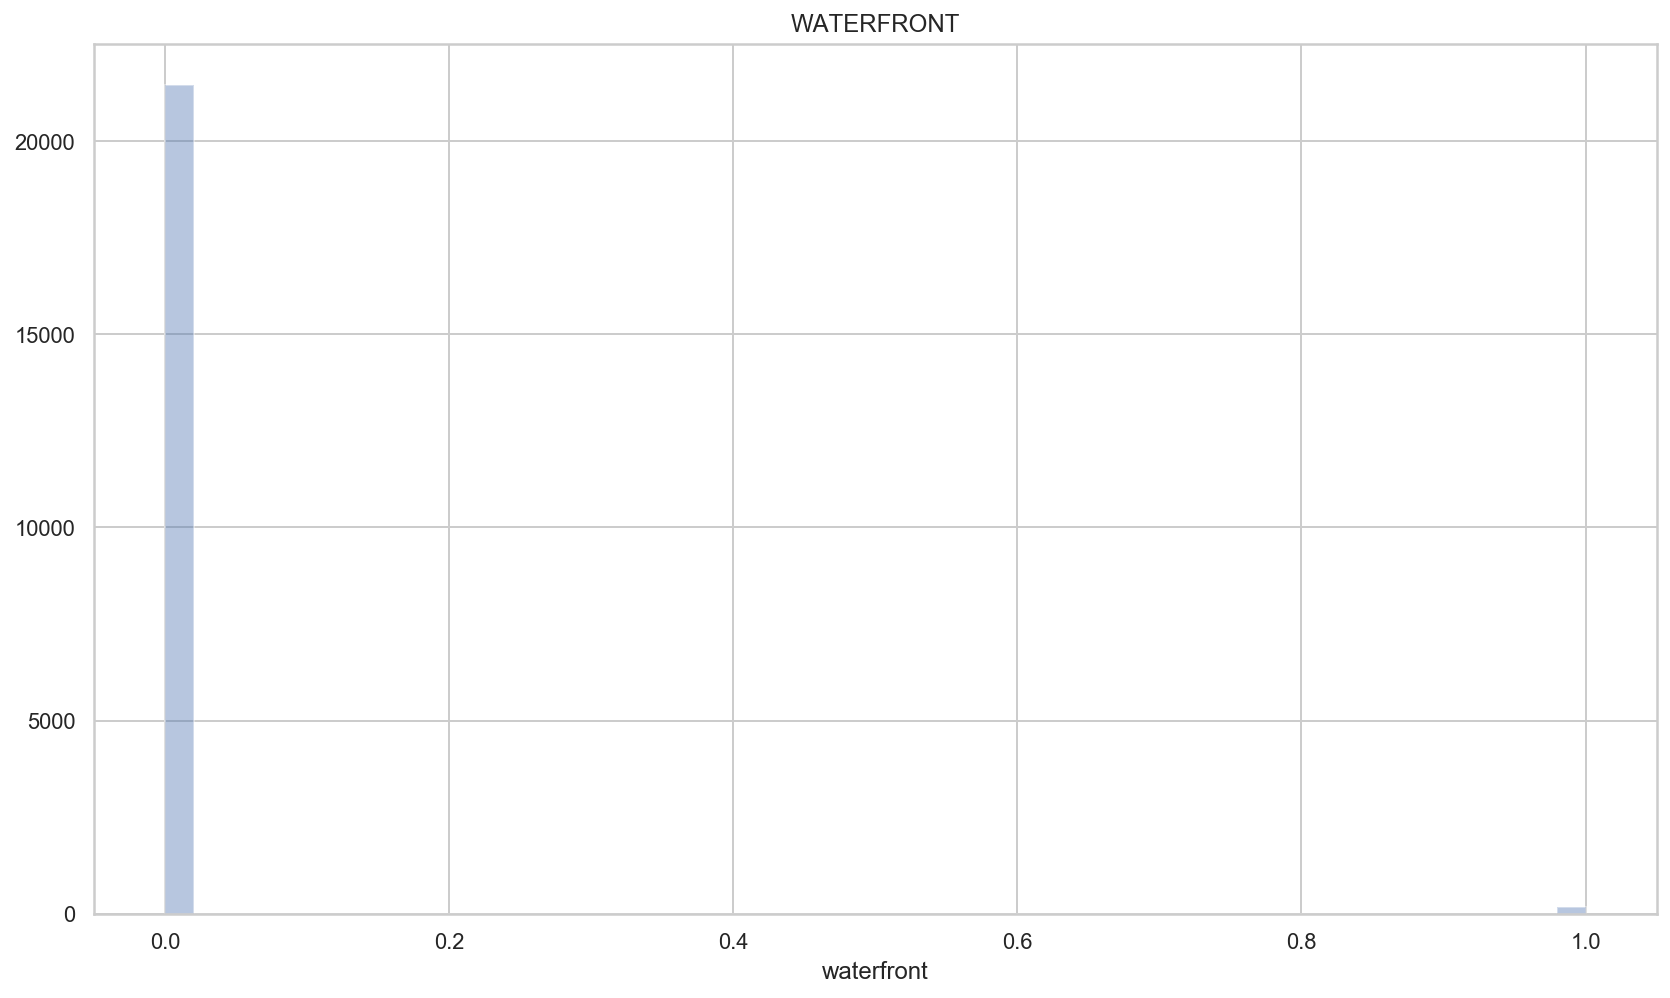

count    21613.000000
mean         0.007542
std          0.086517
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64


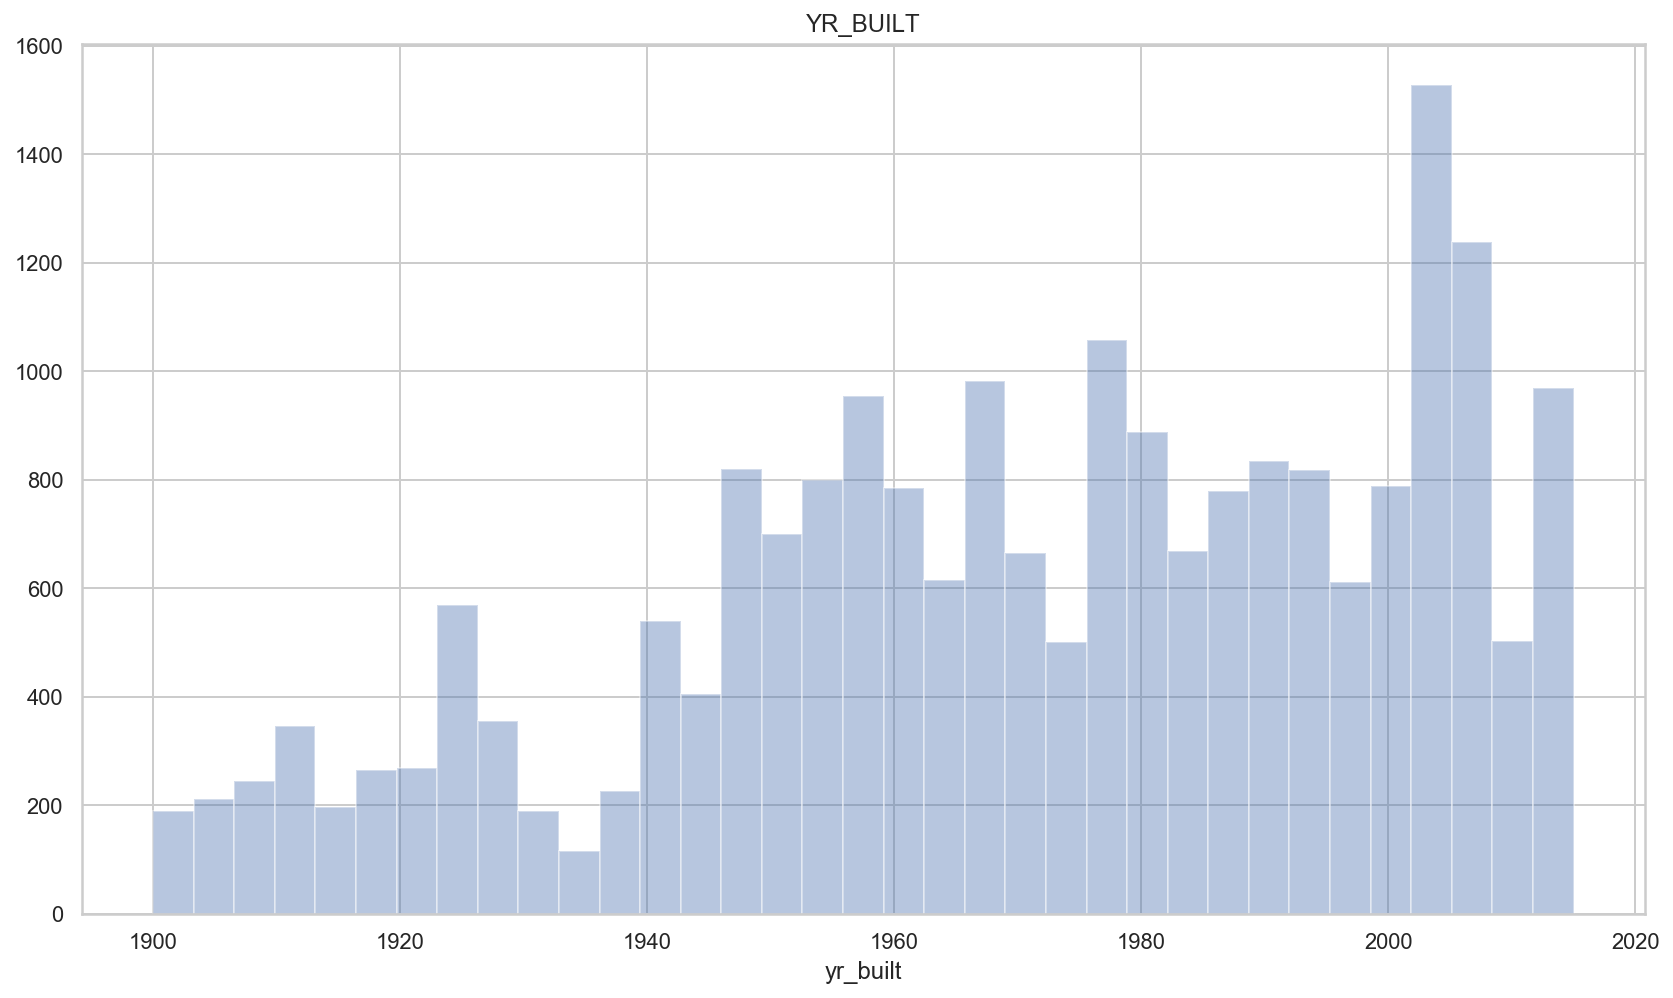

count    21613.000000
mean      1971.005136
std         29.373411
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64


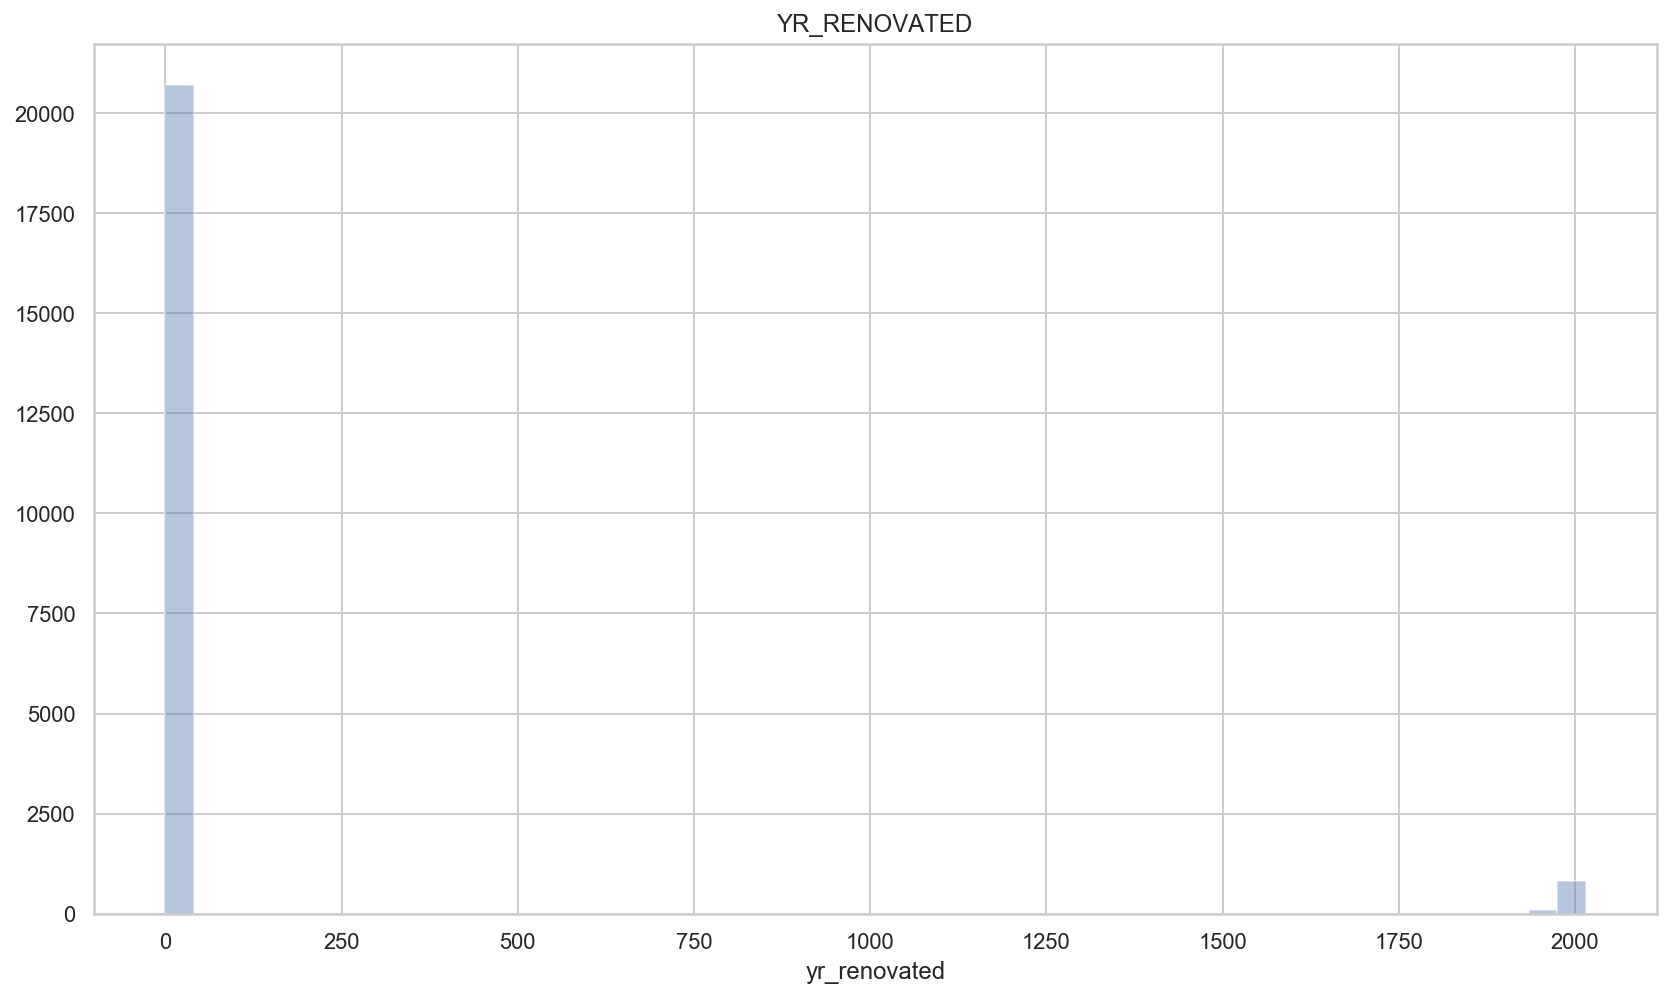

count    21613.000000
mean        84.402258
std        401.679240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64


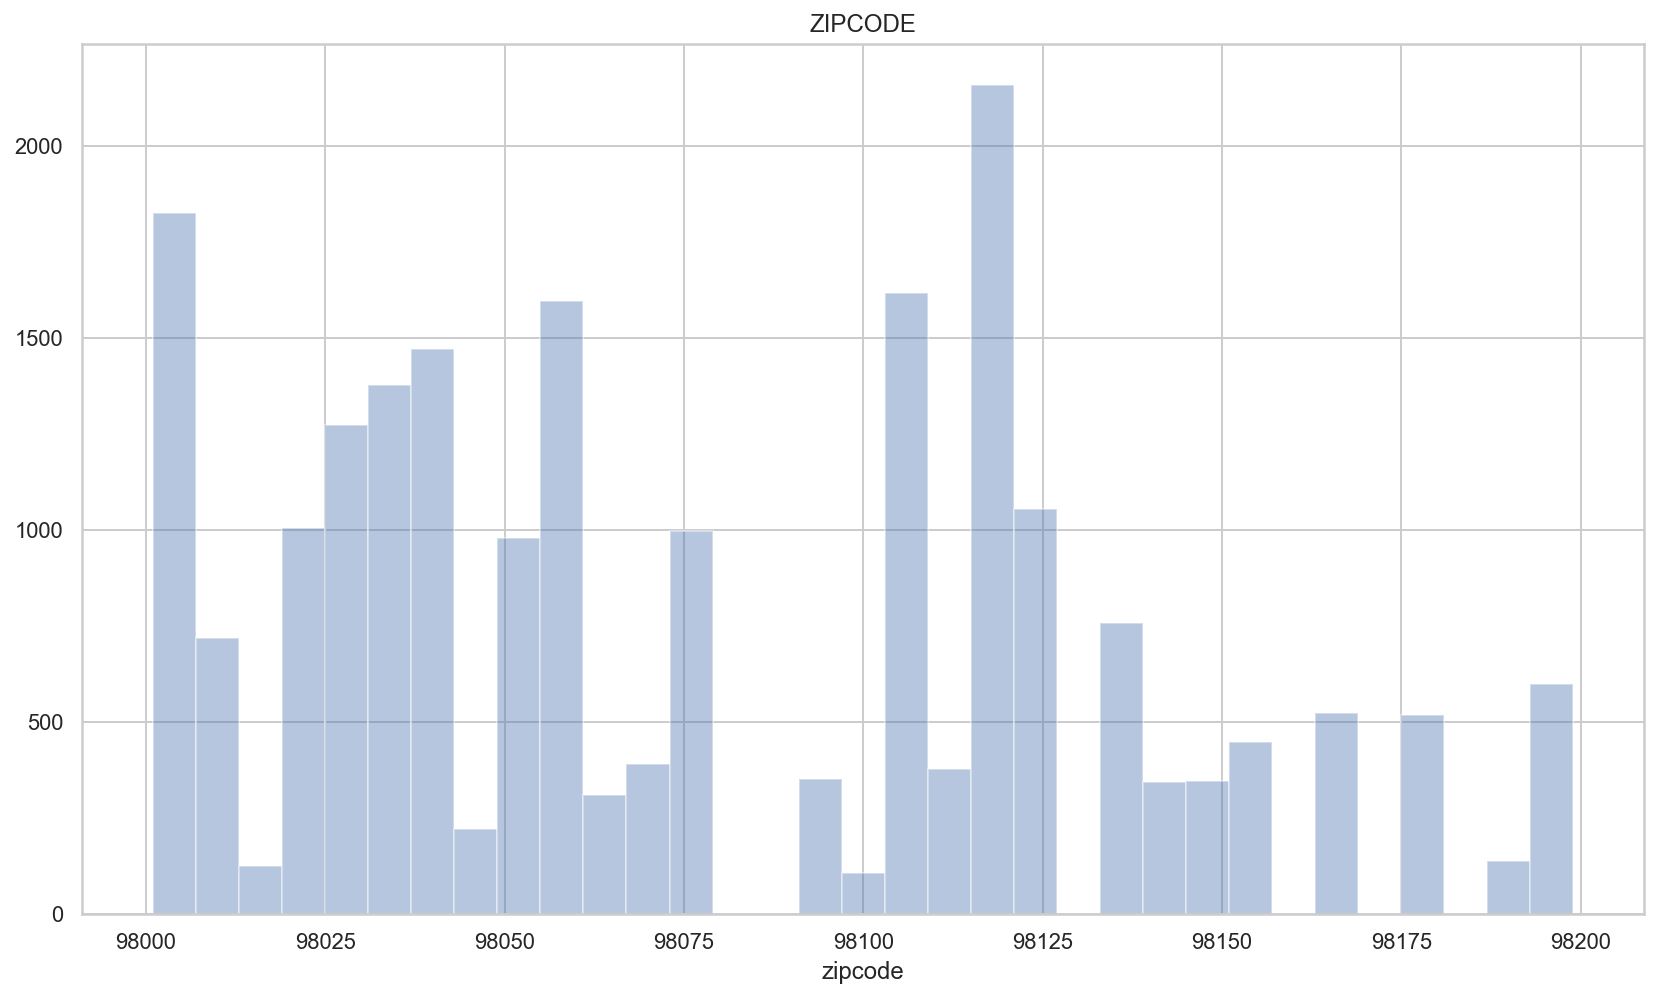

count    21613.000000
mean     98077.939805
std         53.505026
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64


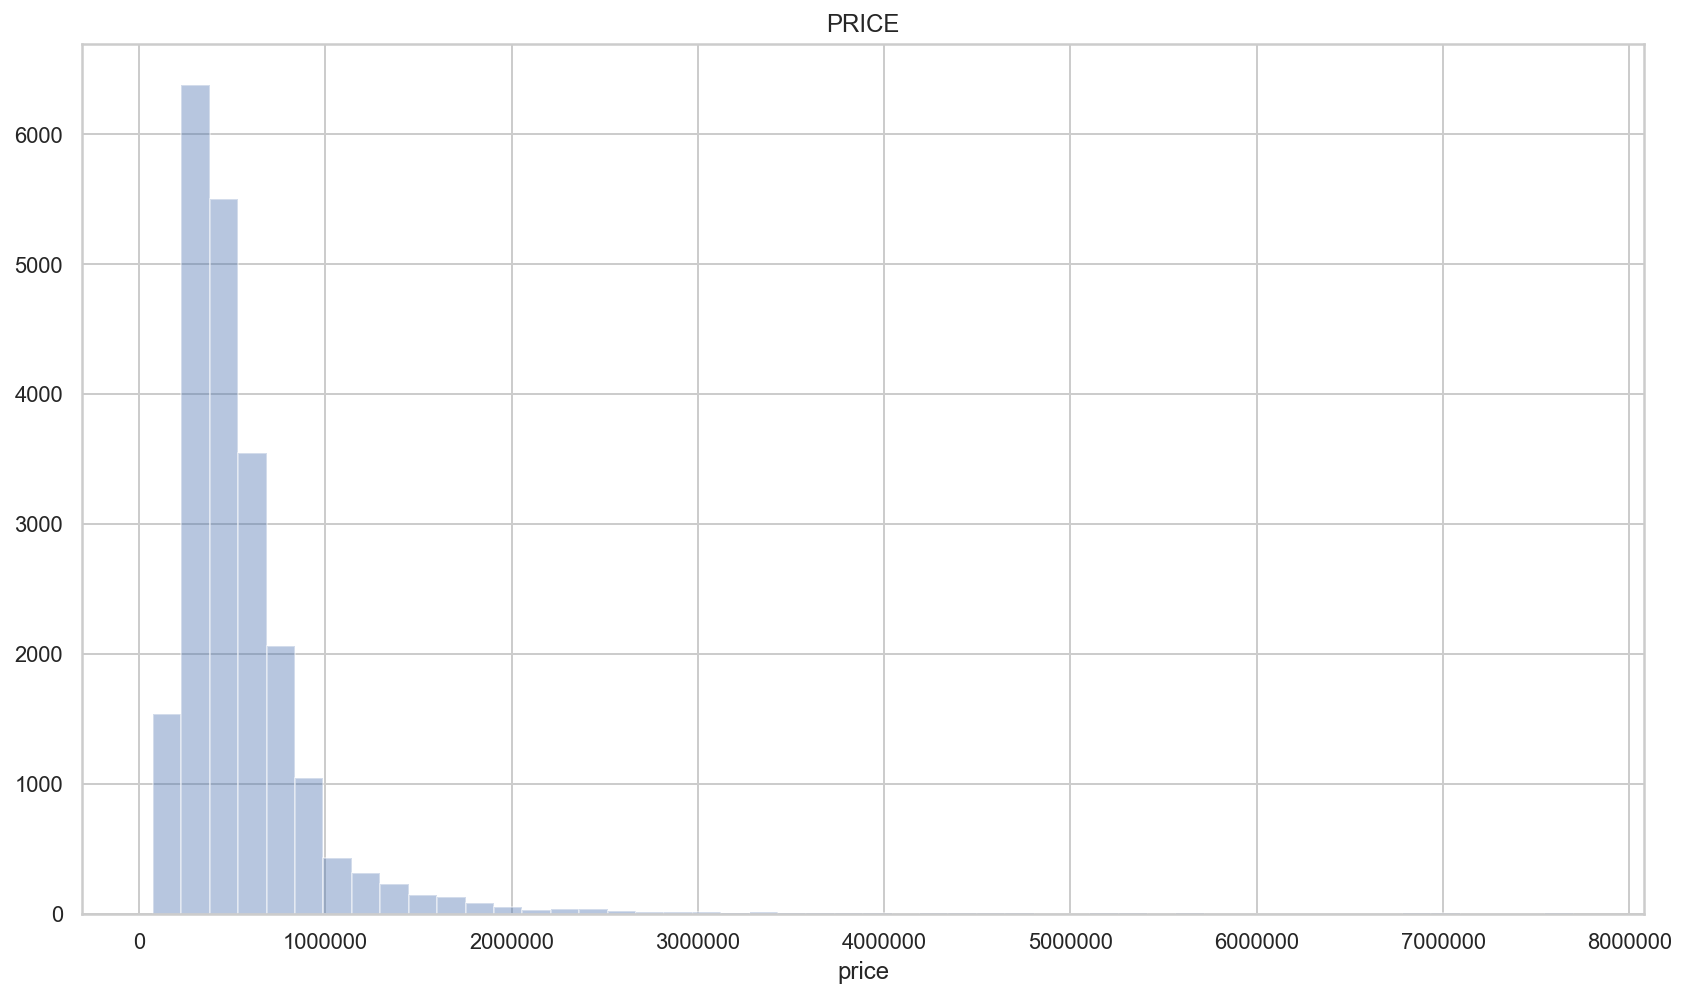

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


In [20]:
cols = list(df.columns)
cols.remove("date")

for col in cols:
    plt.figure(figsize=fs)
    sns.distplot(df[col], kde=False).set_title("{}".format(col.upper()))
    plt.savefig("figures/histograms/histogram_{}.png".format(col))
    plt.show()
    print(df[col].describe())

## 2.4 Y vs X Scatter Plots

In [16]:
y = "price"
x_cols = list(df.columns)
x_cols.remove(y)
x_cols.remove("date")

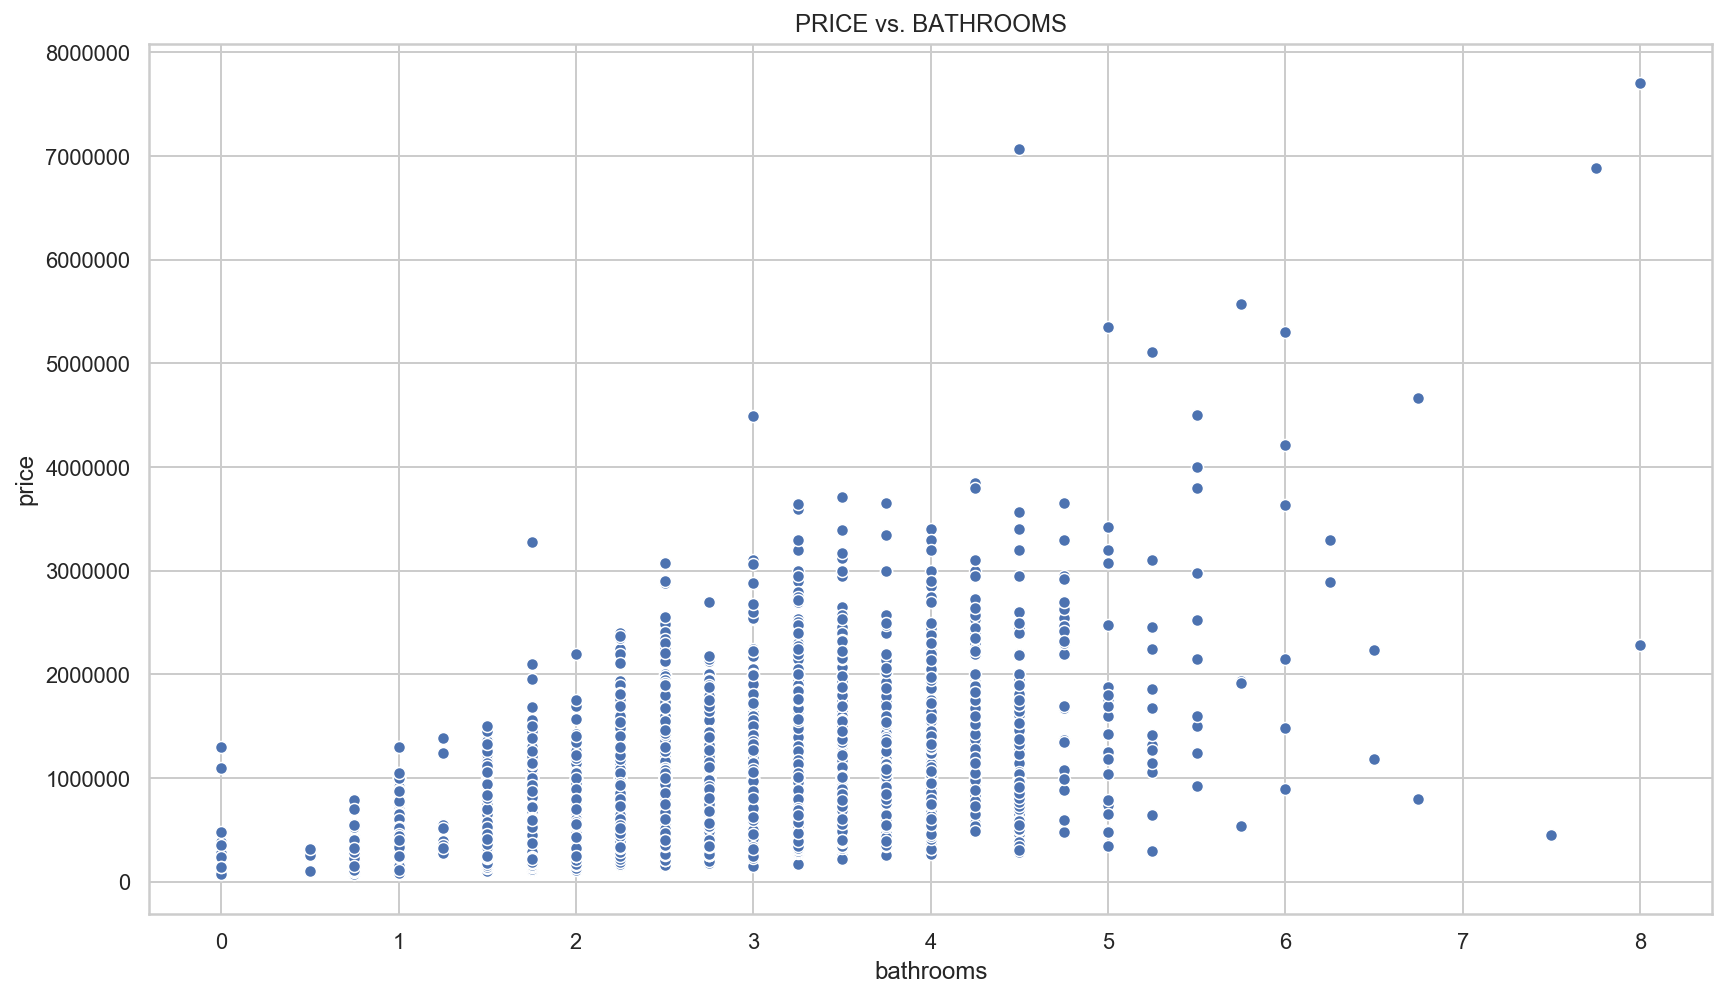

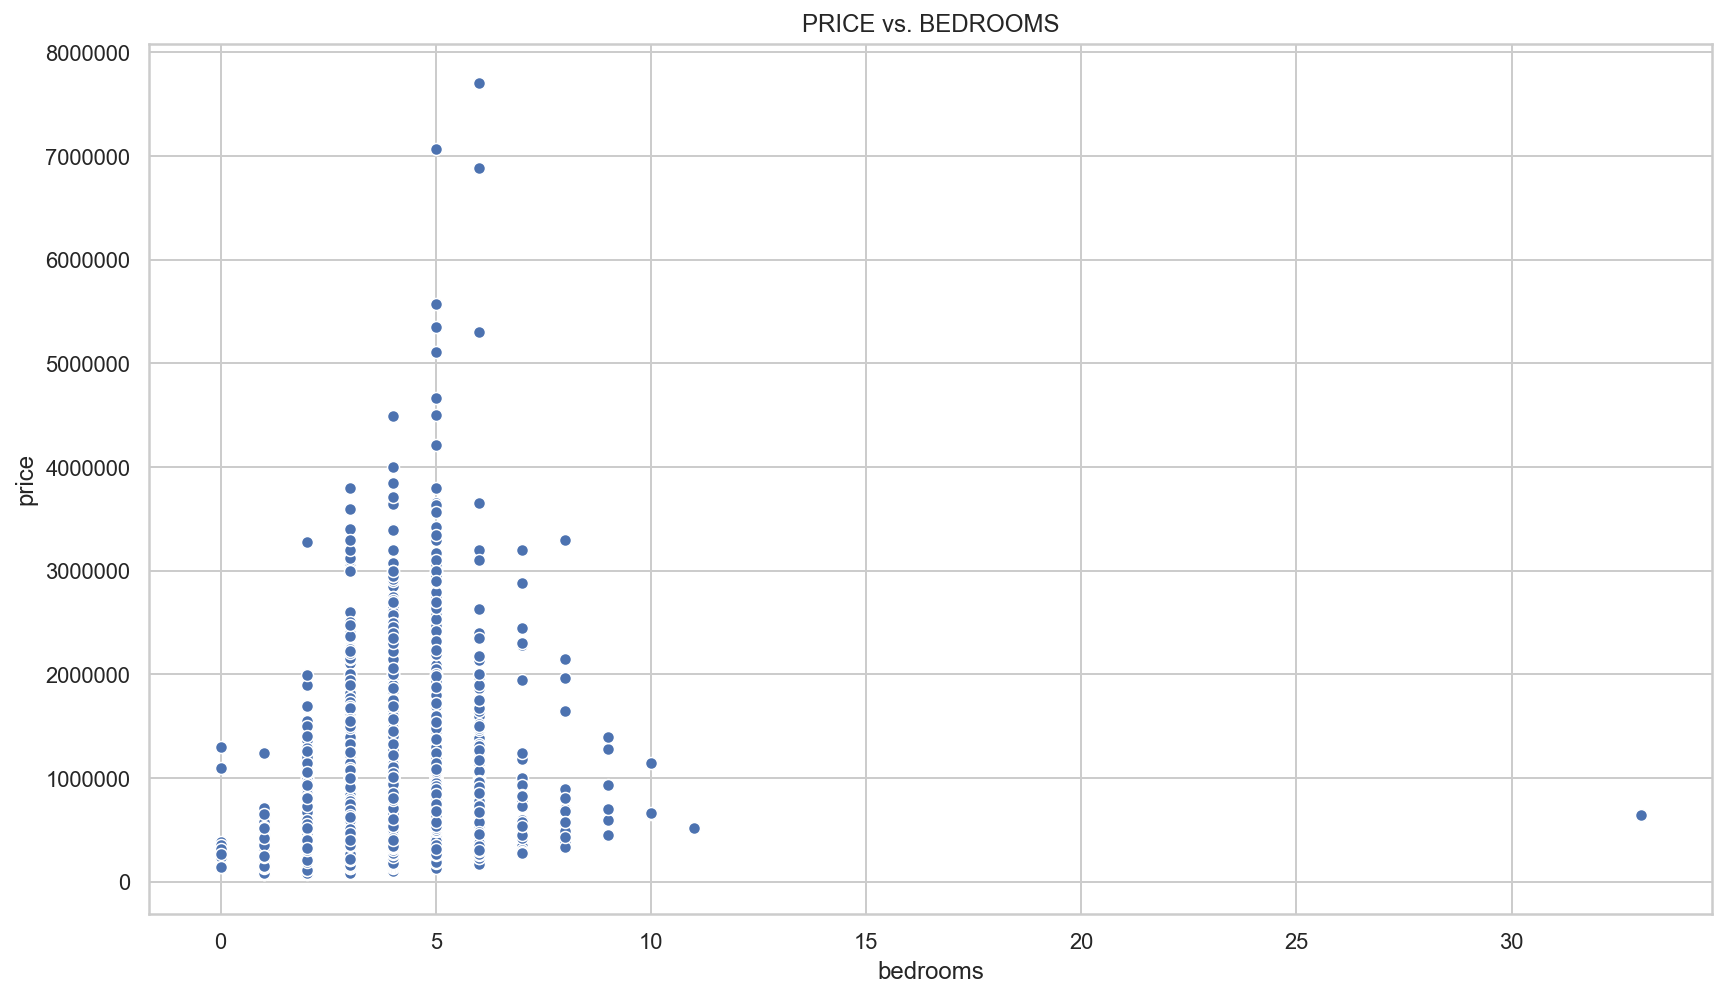

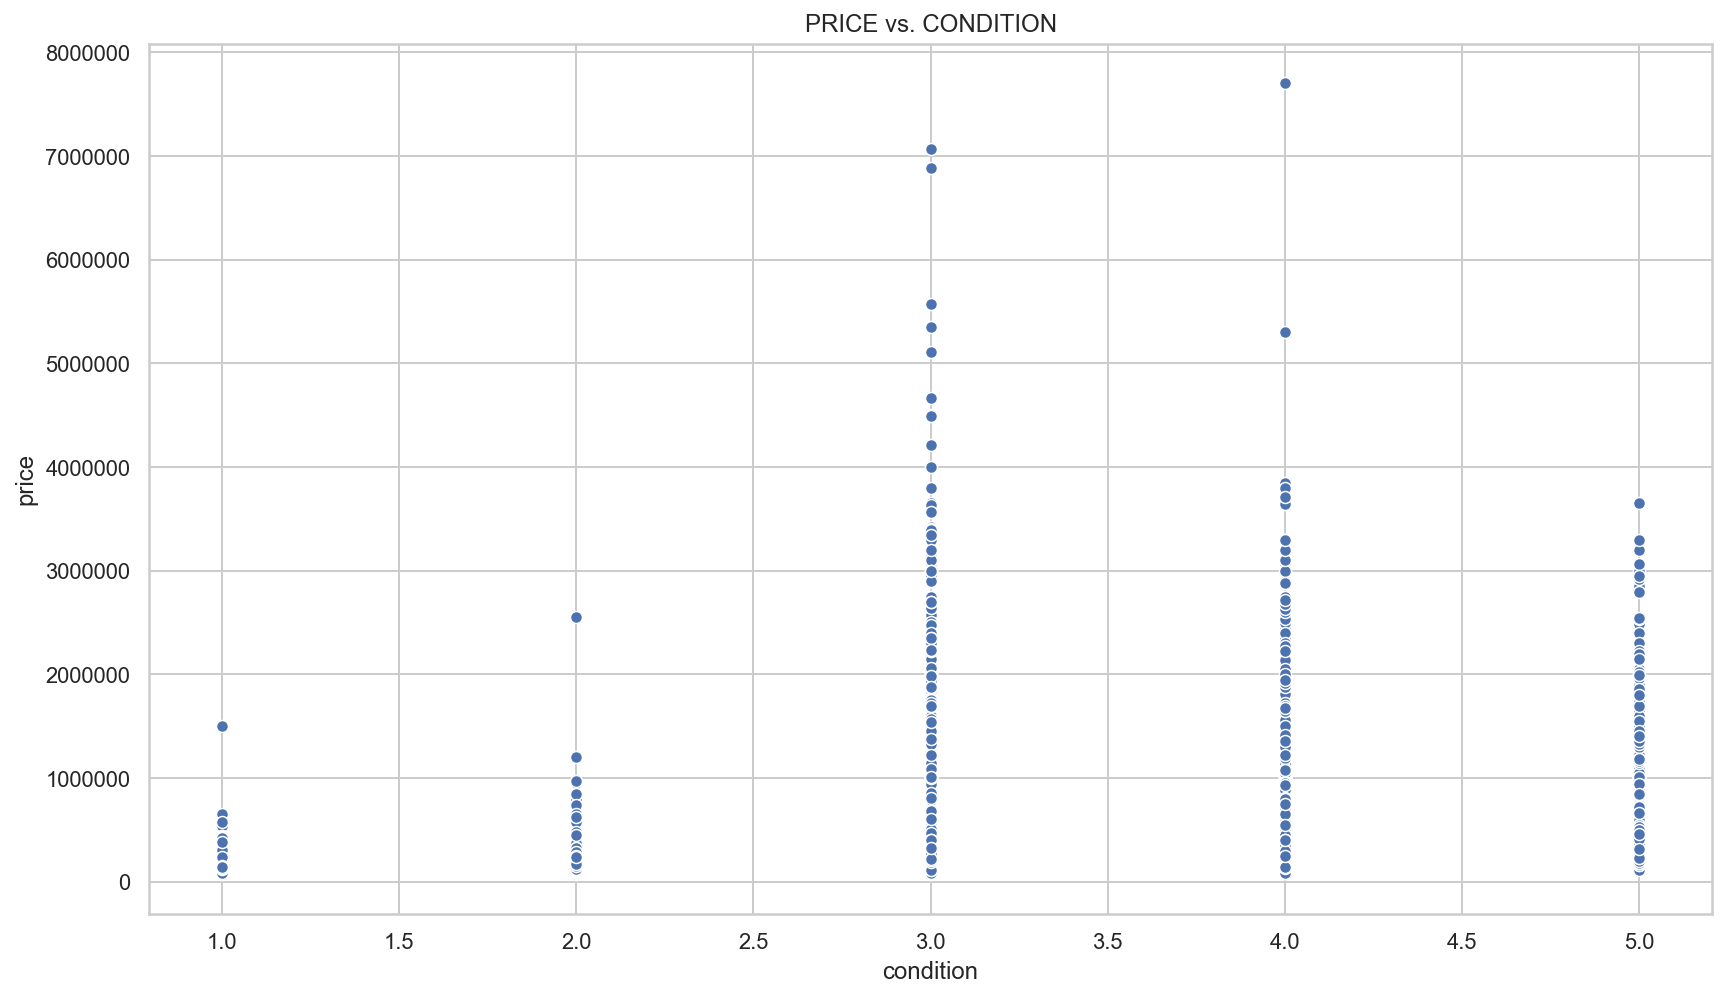

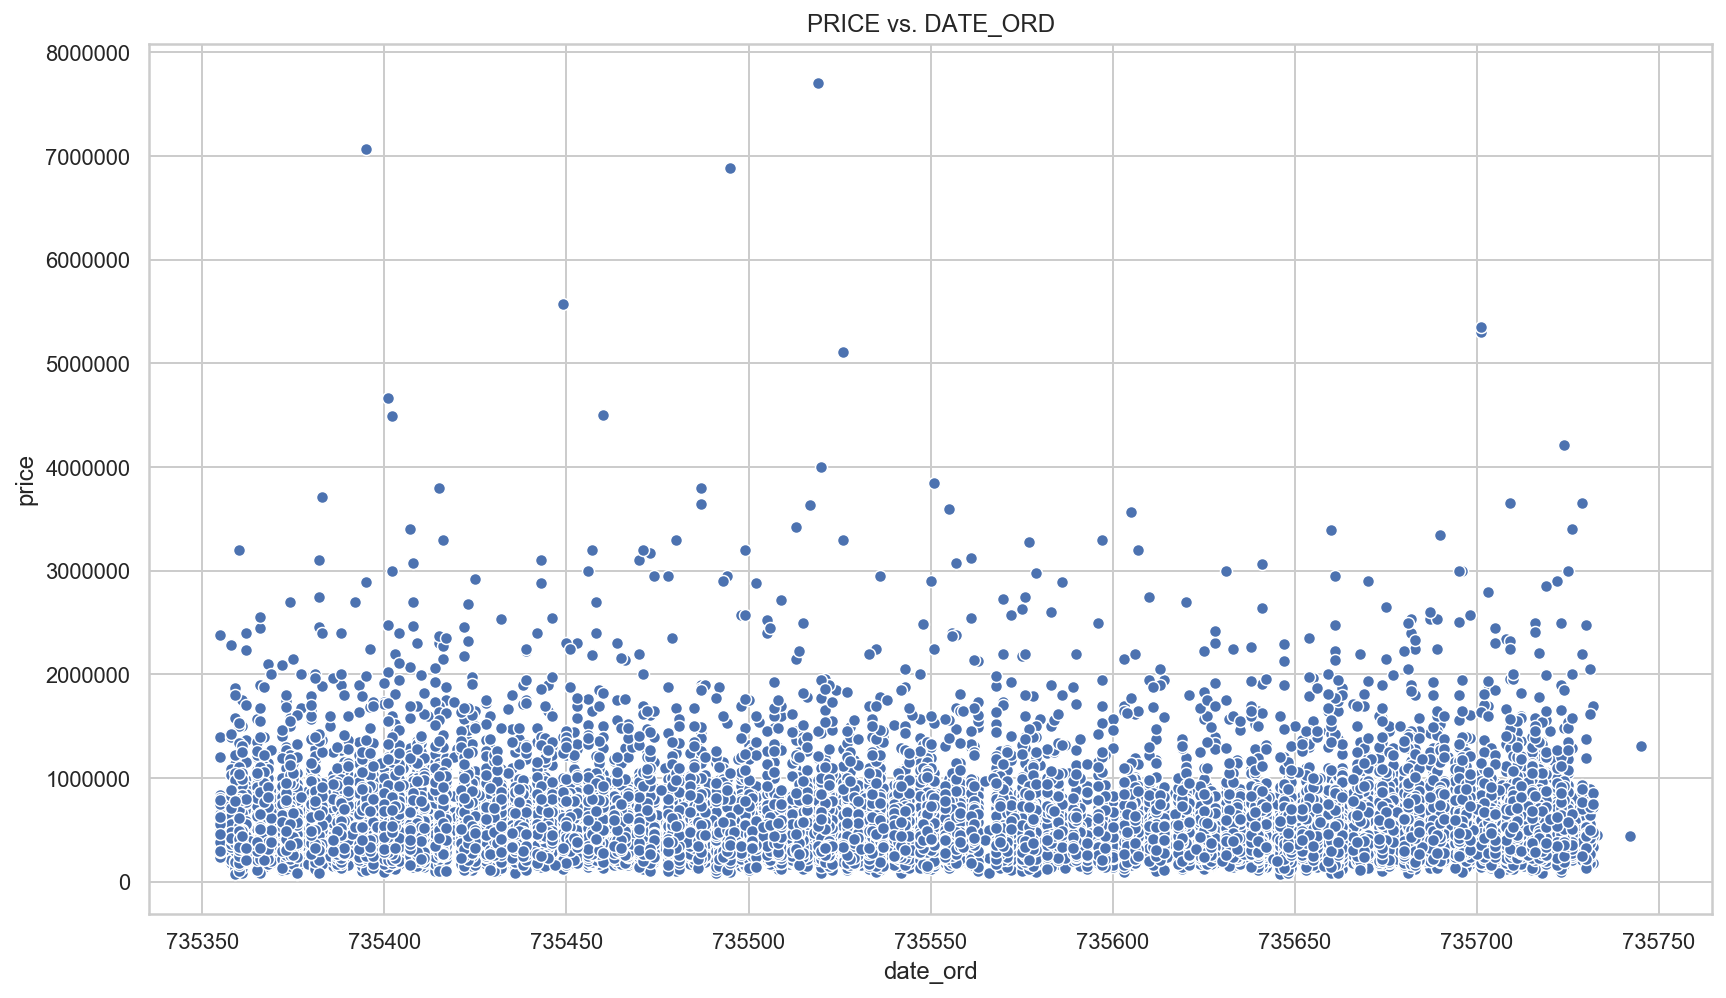

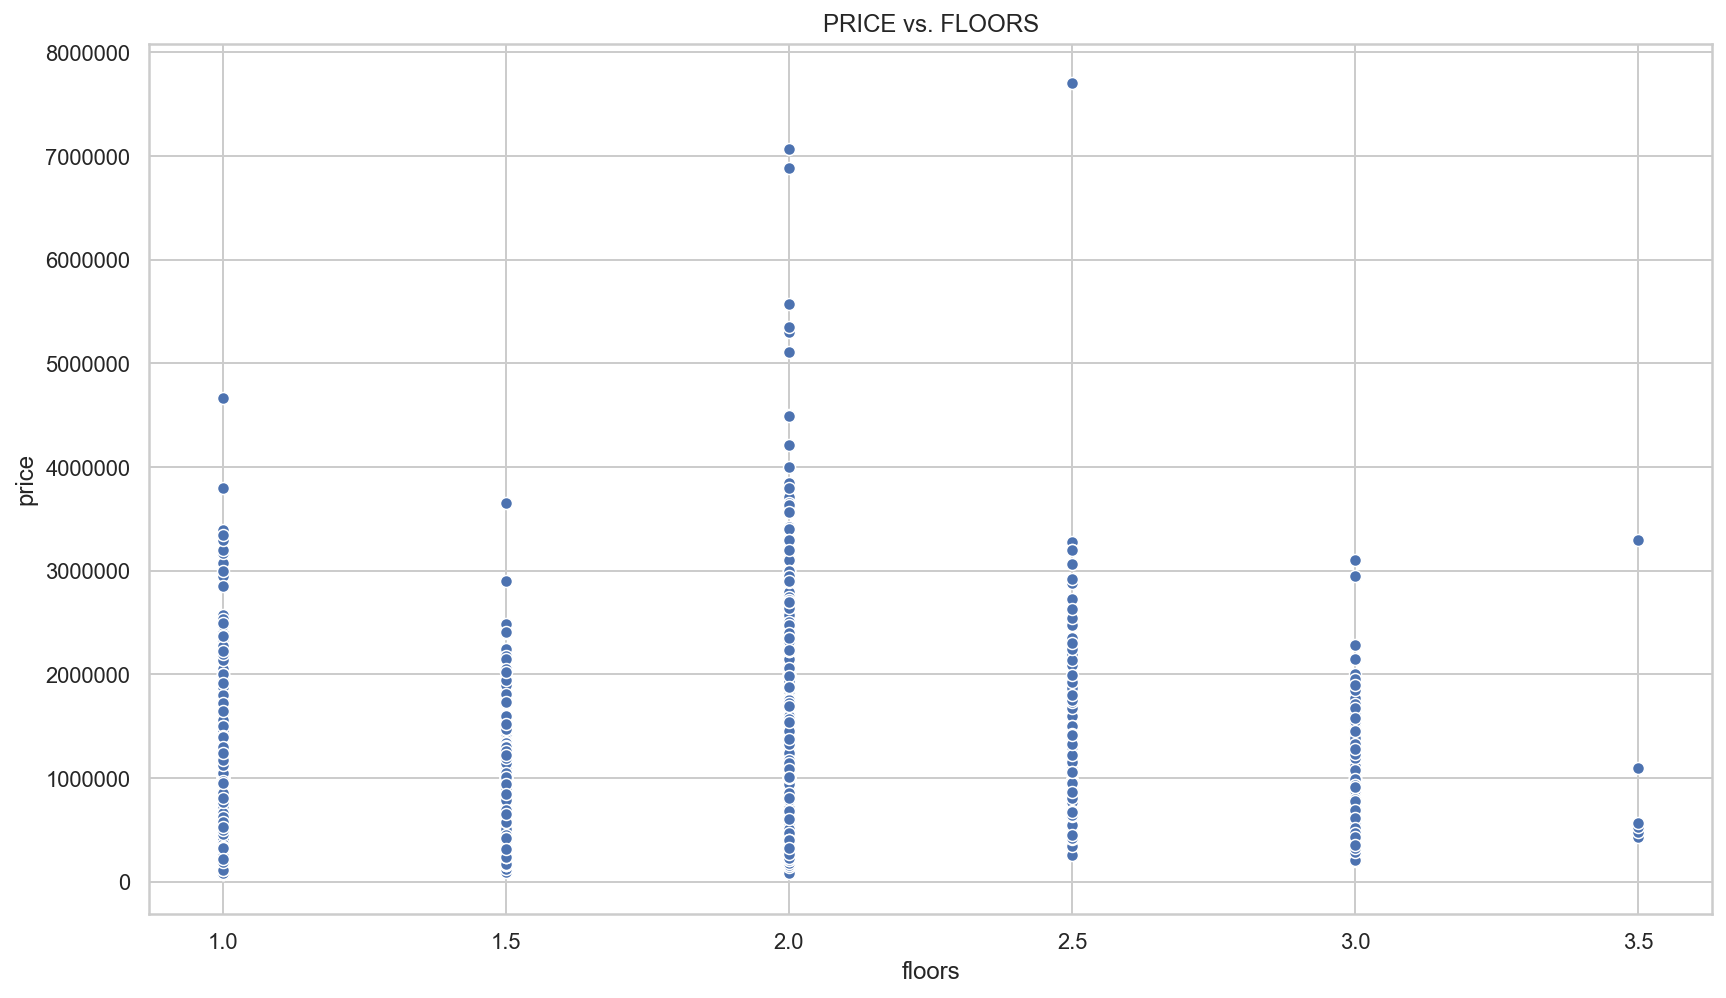

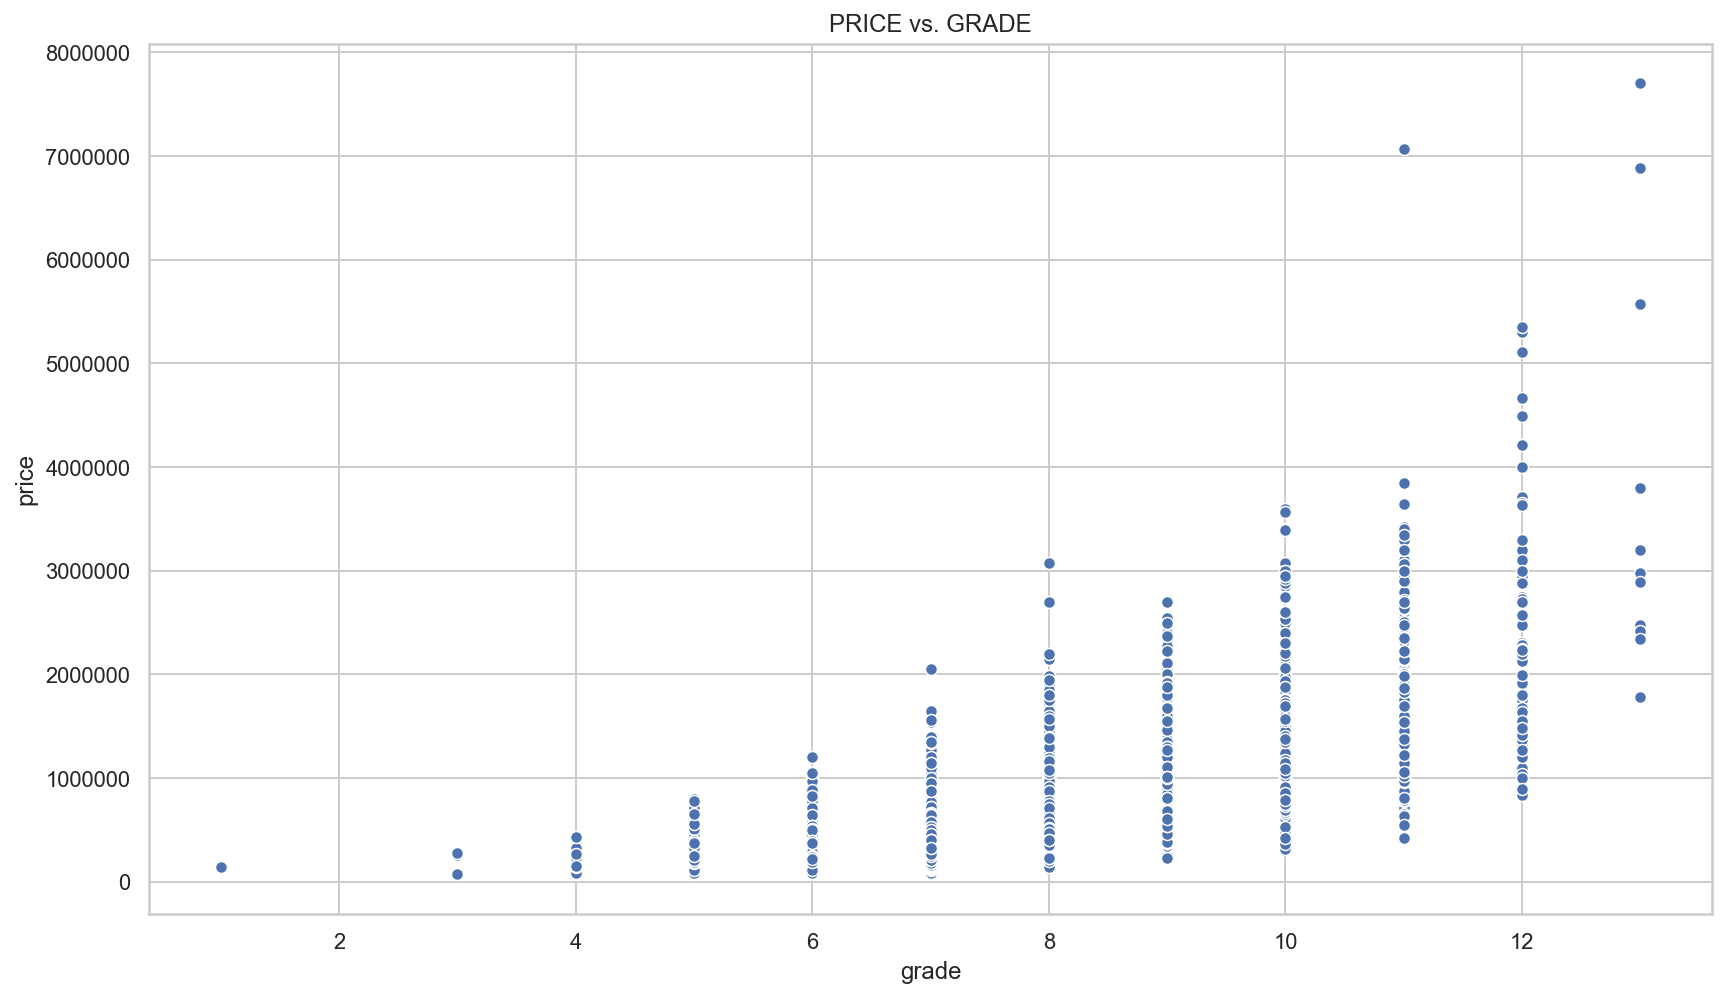

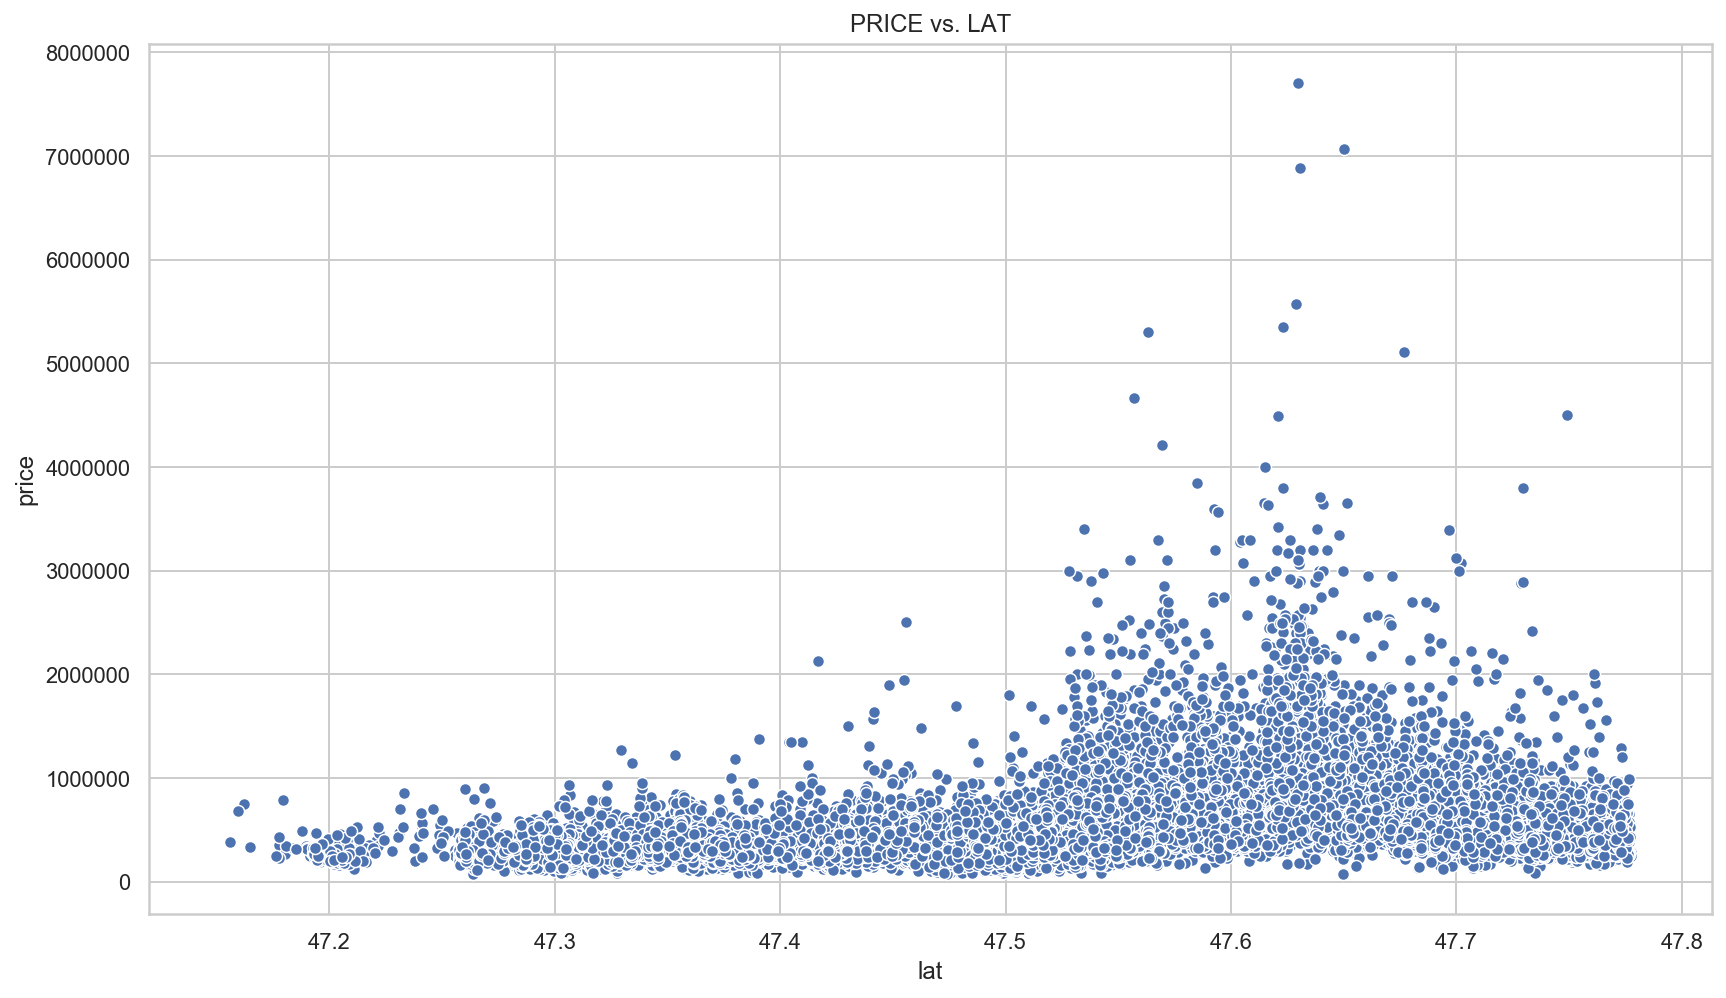

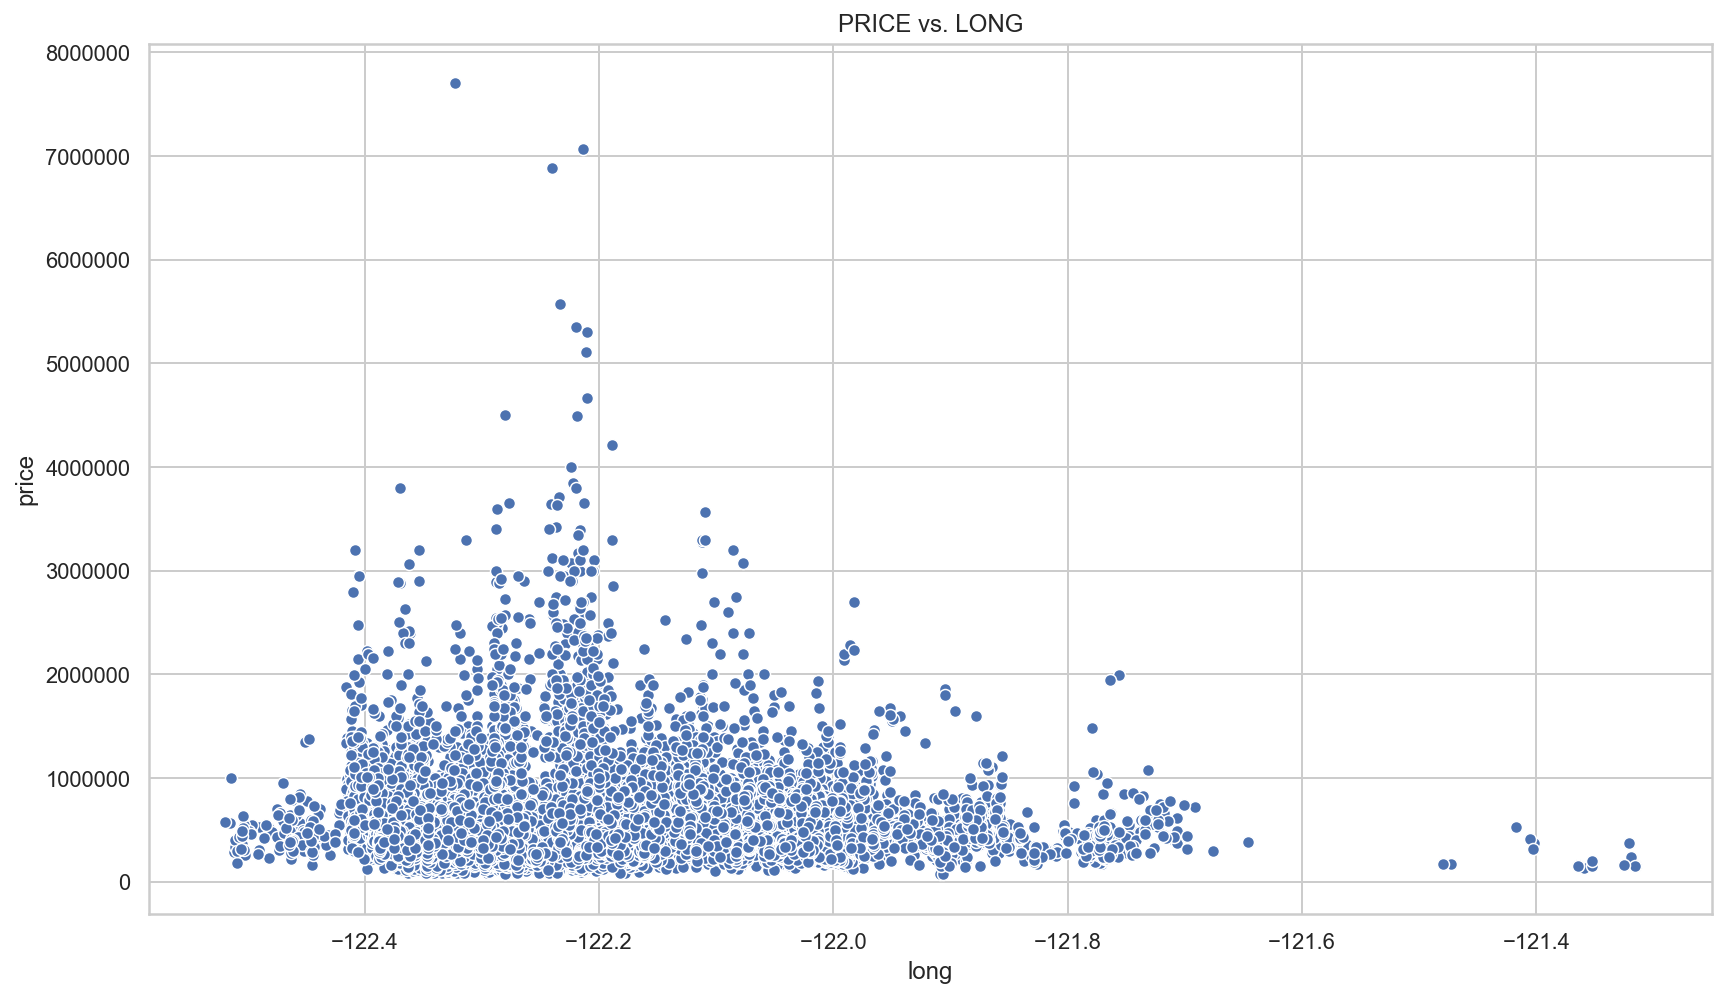

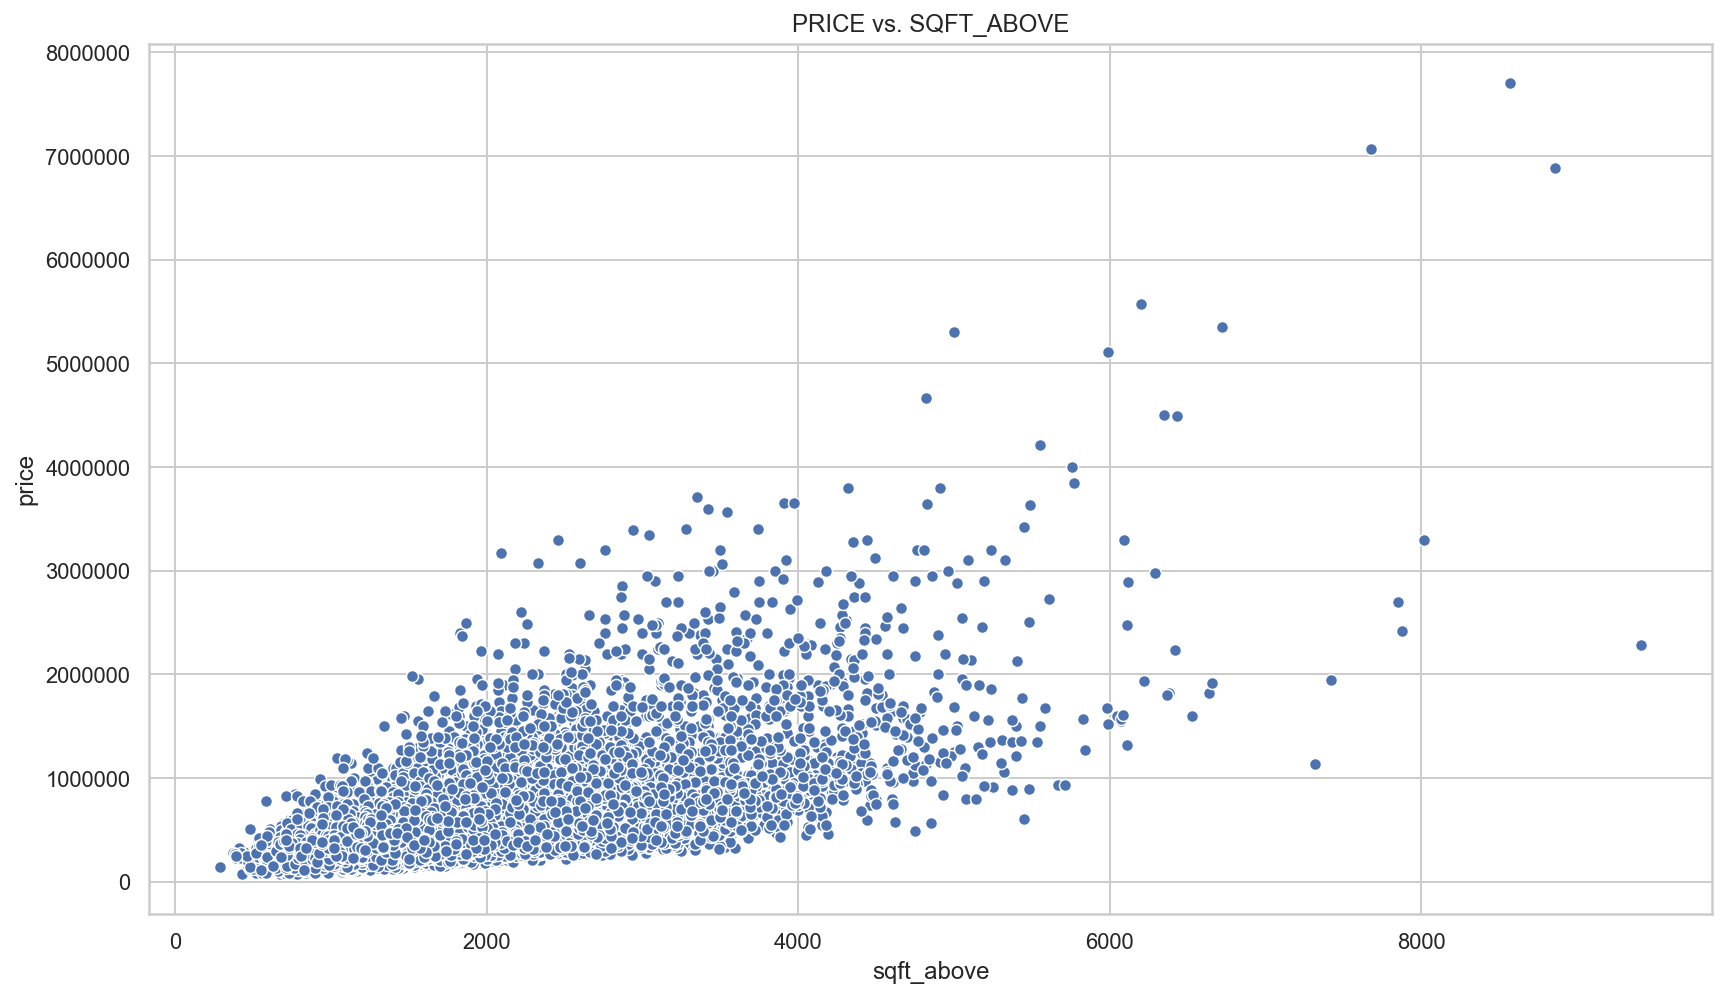

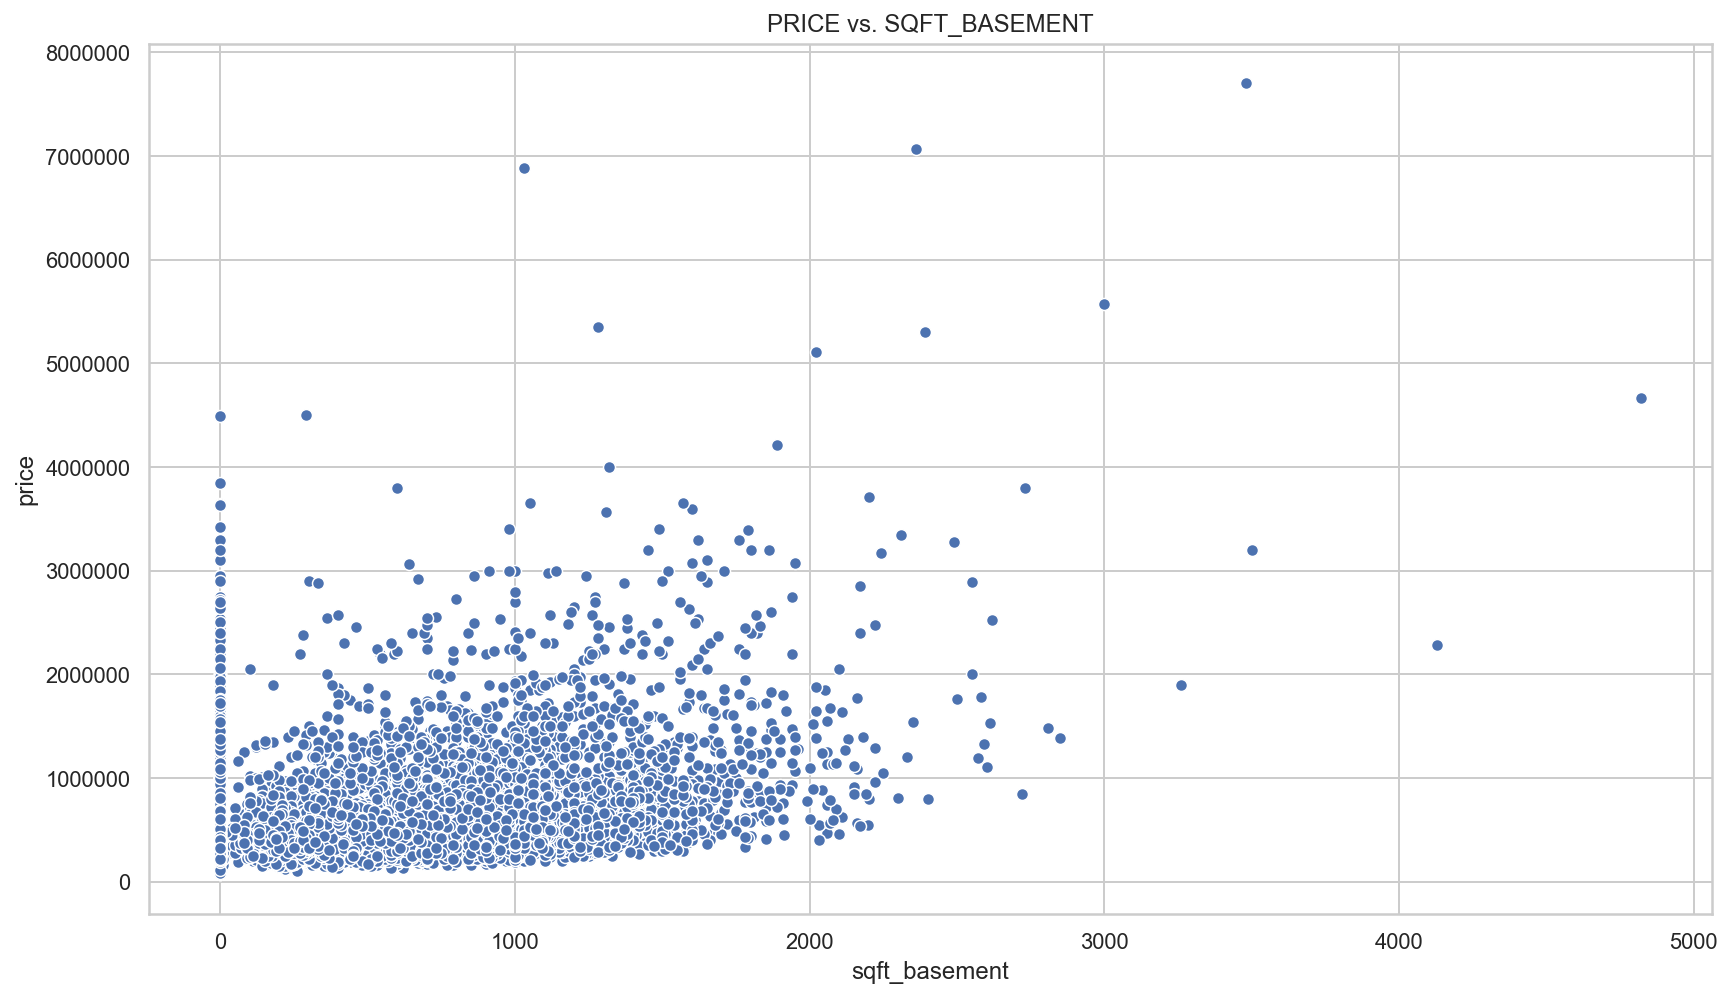

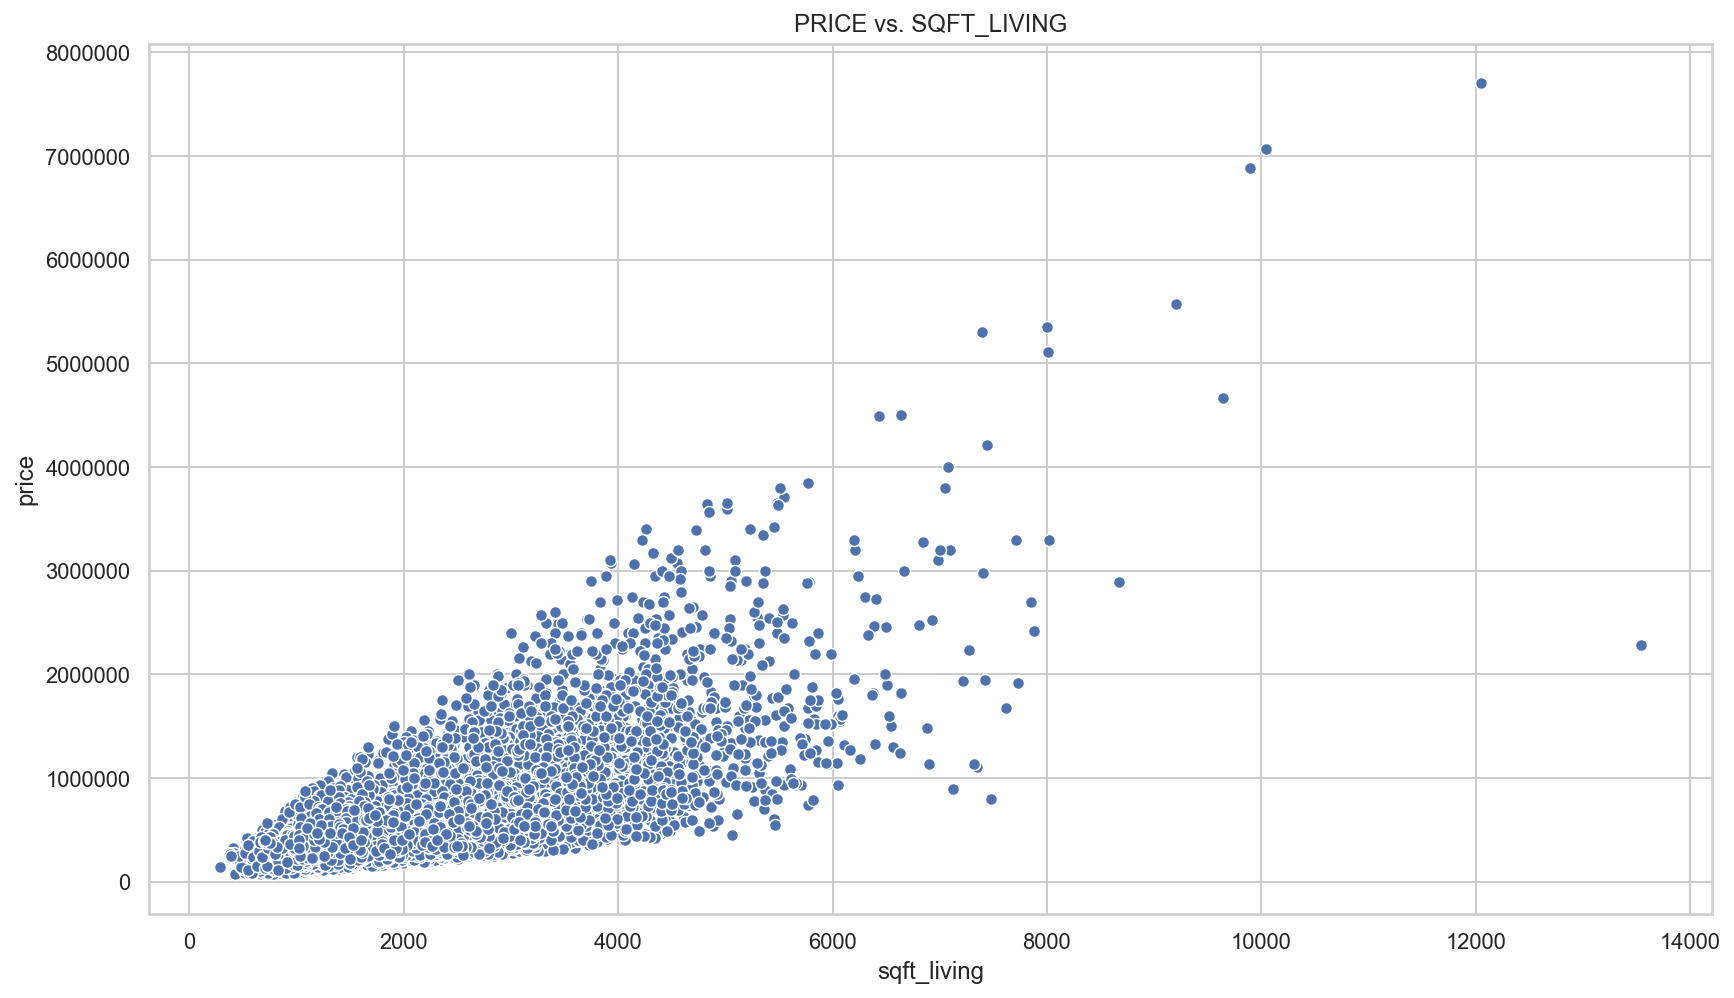

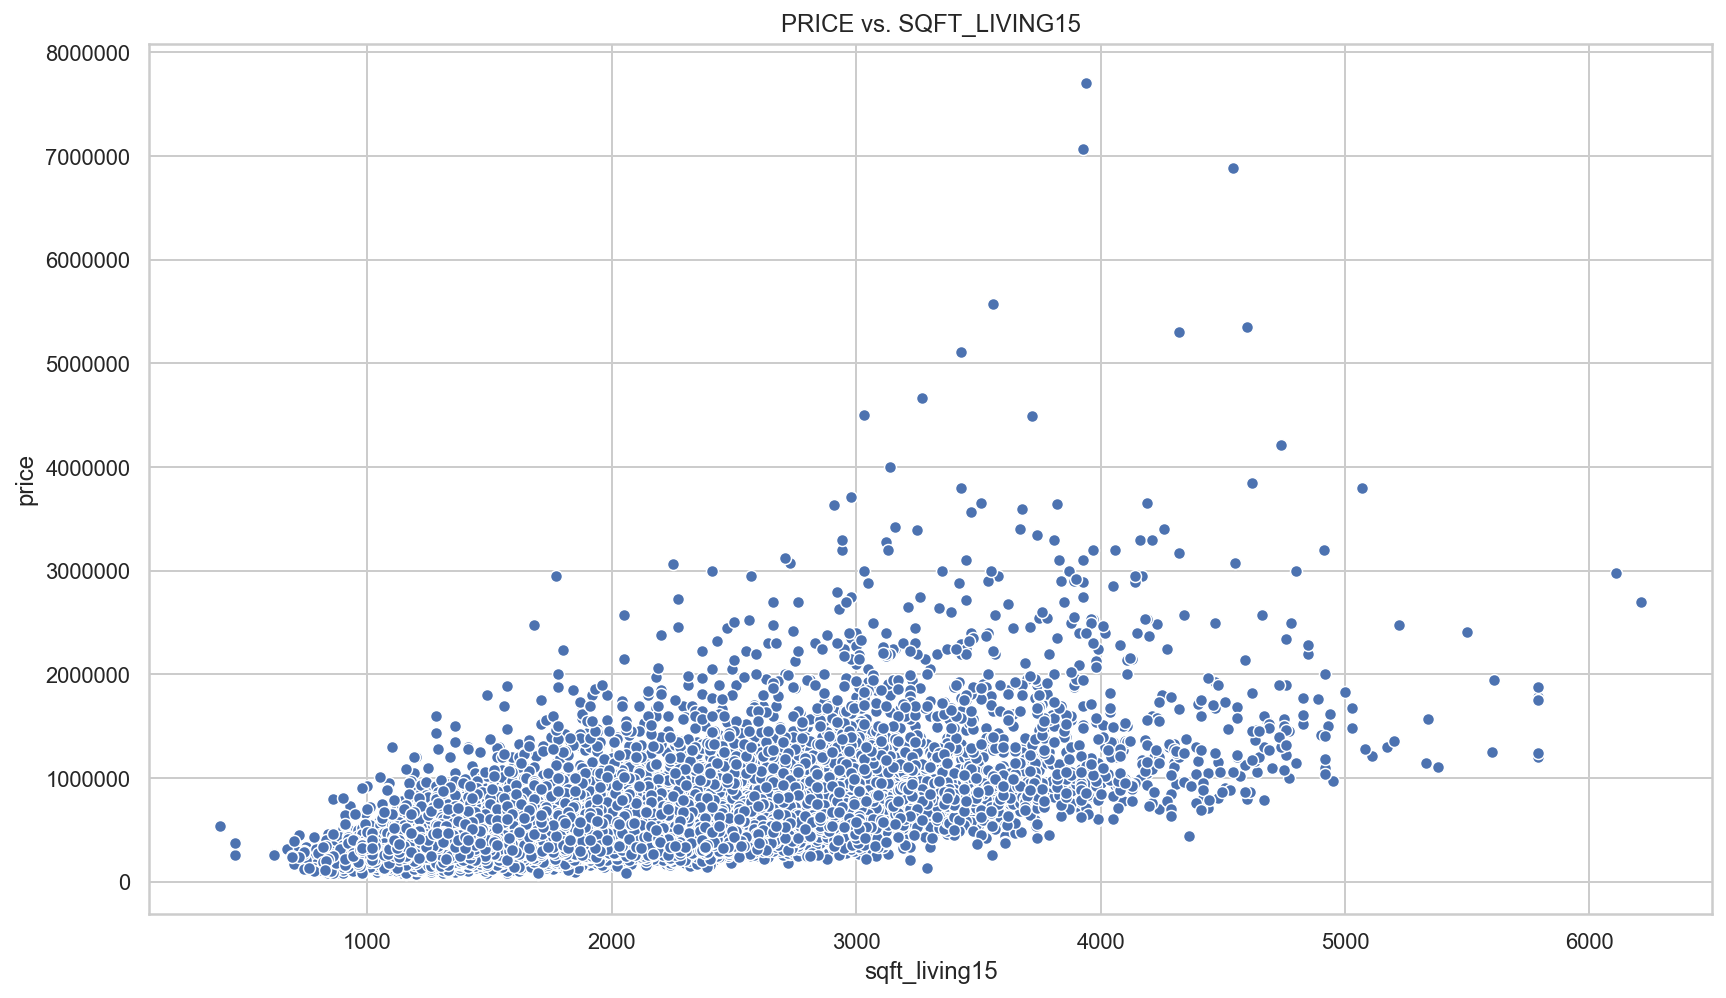

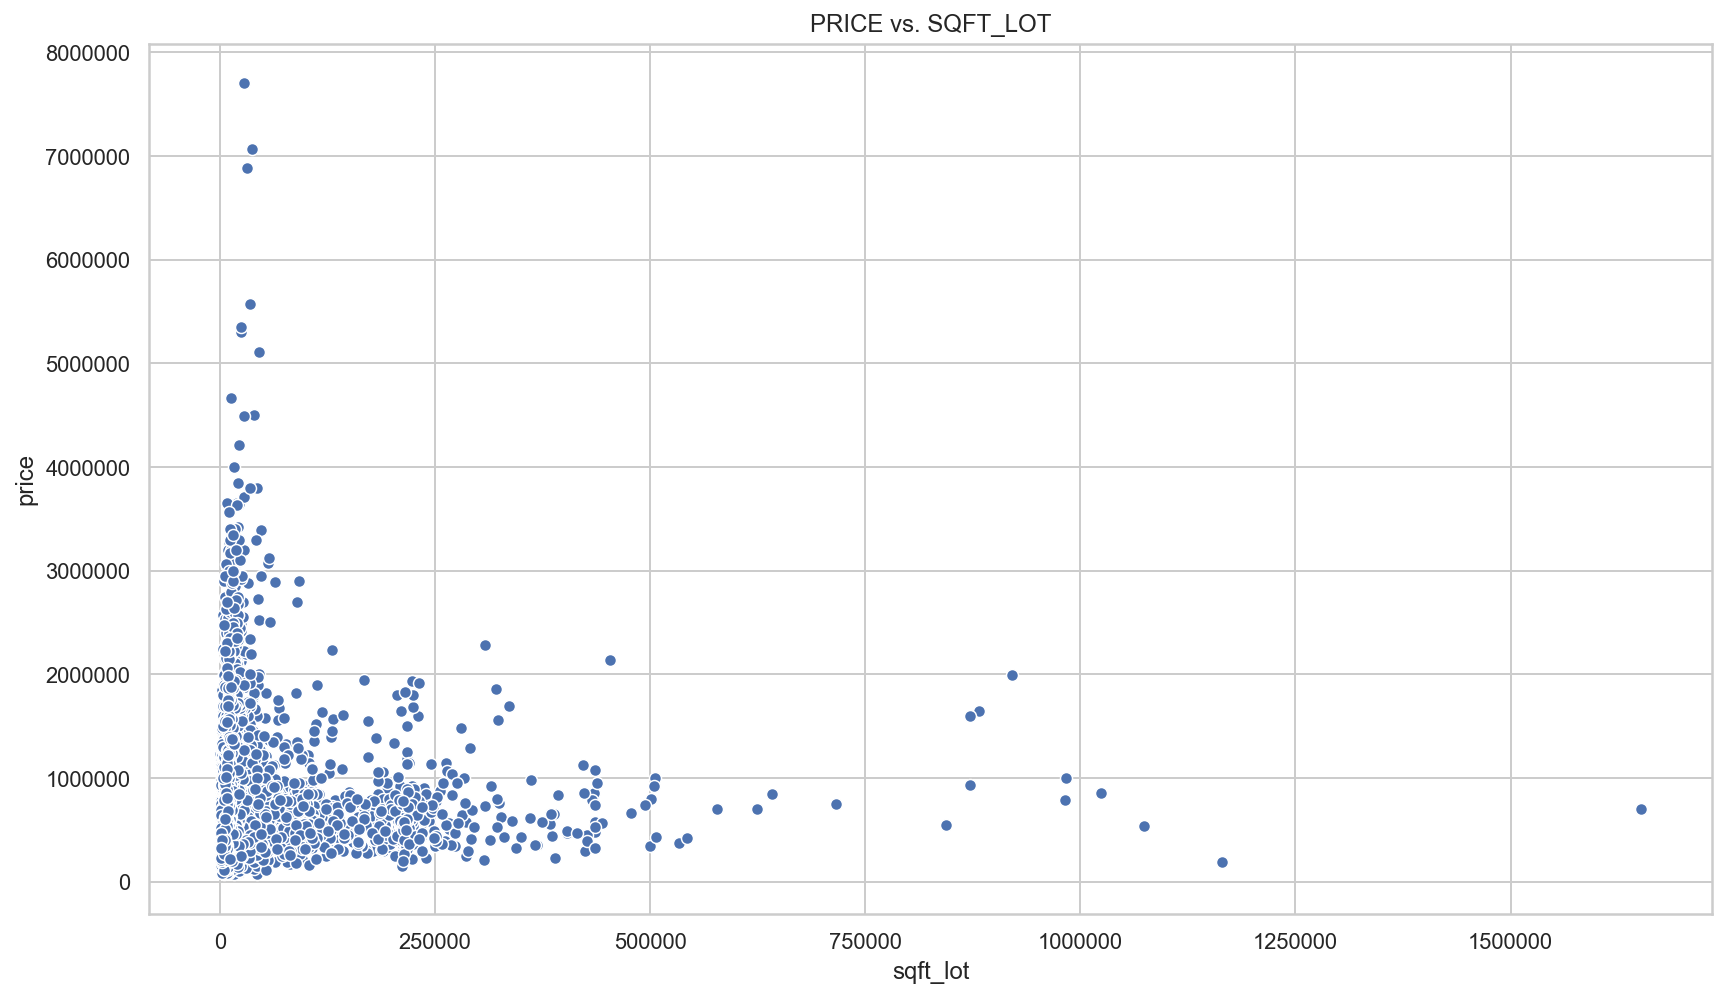

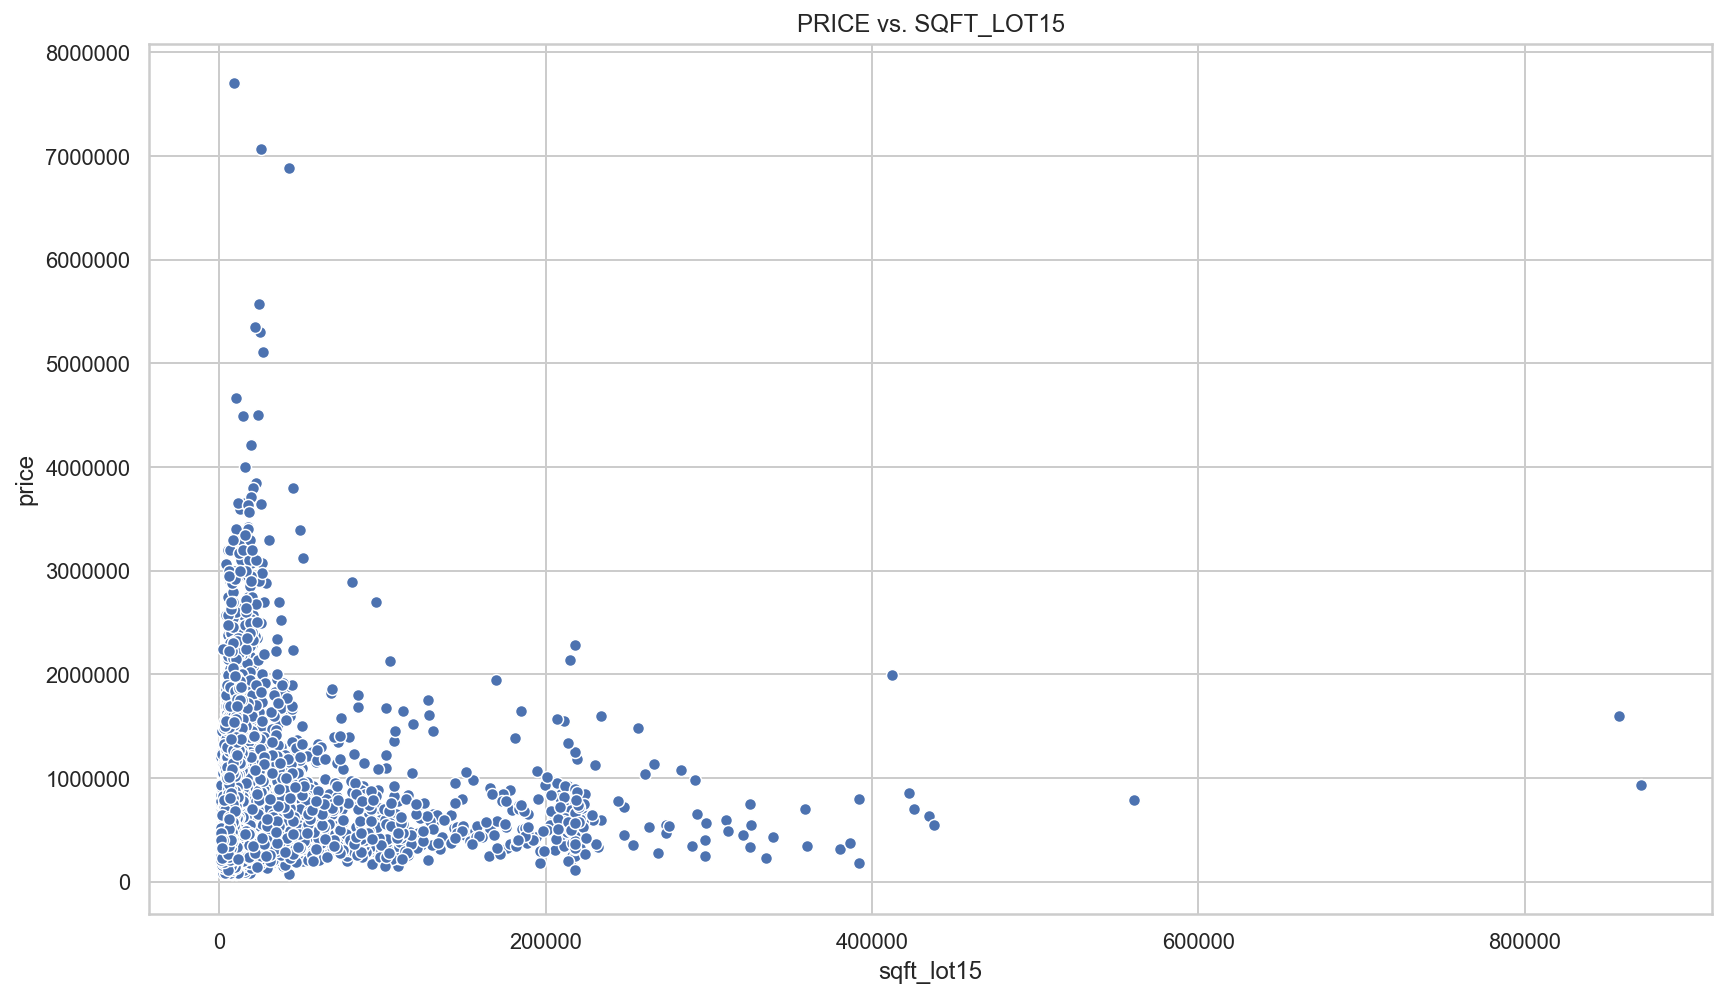

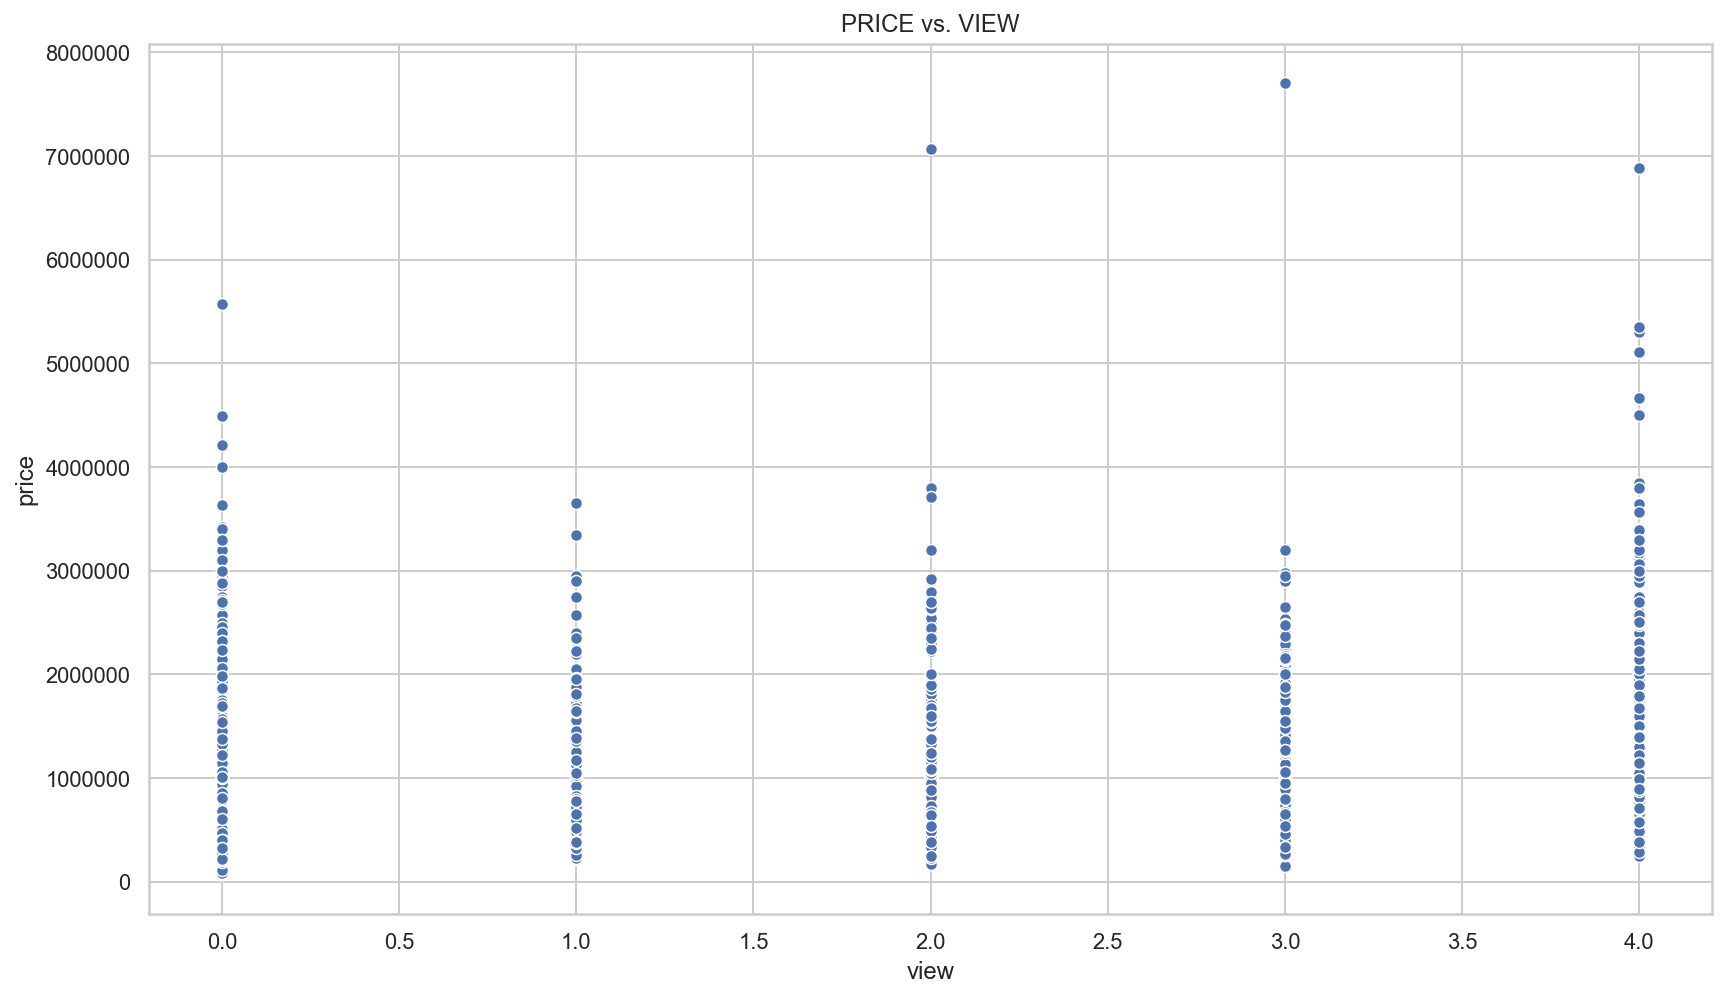

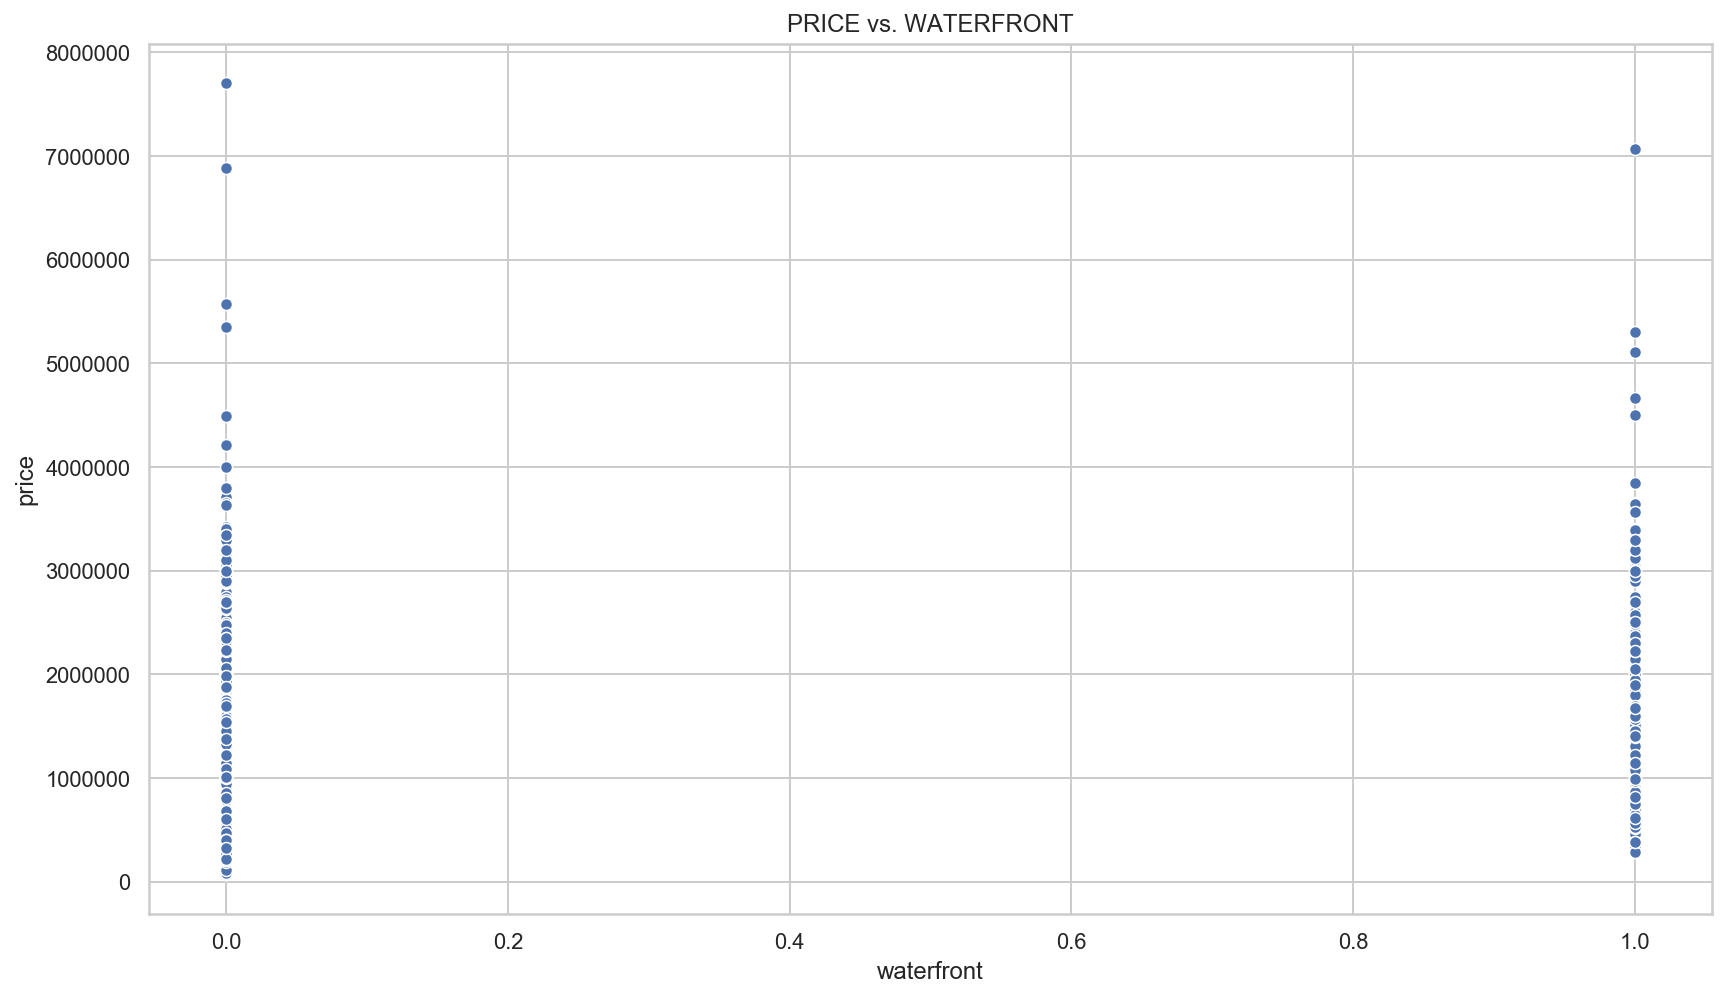

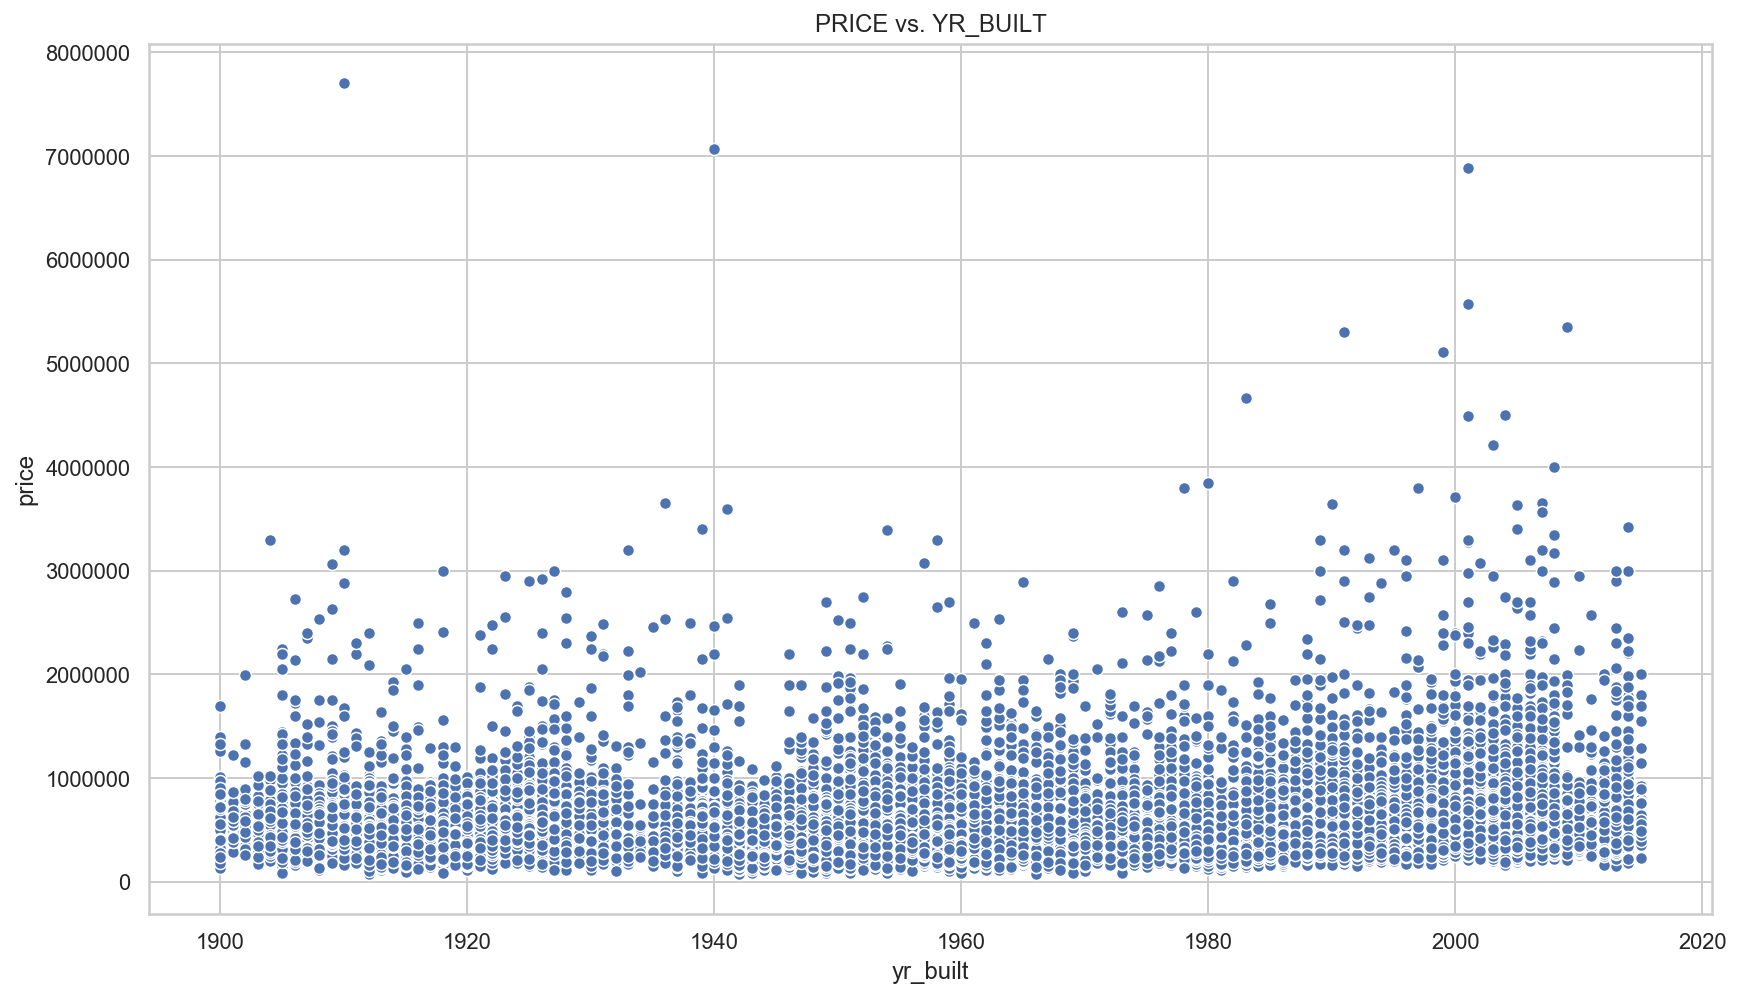

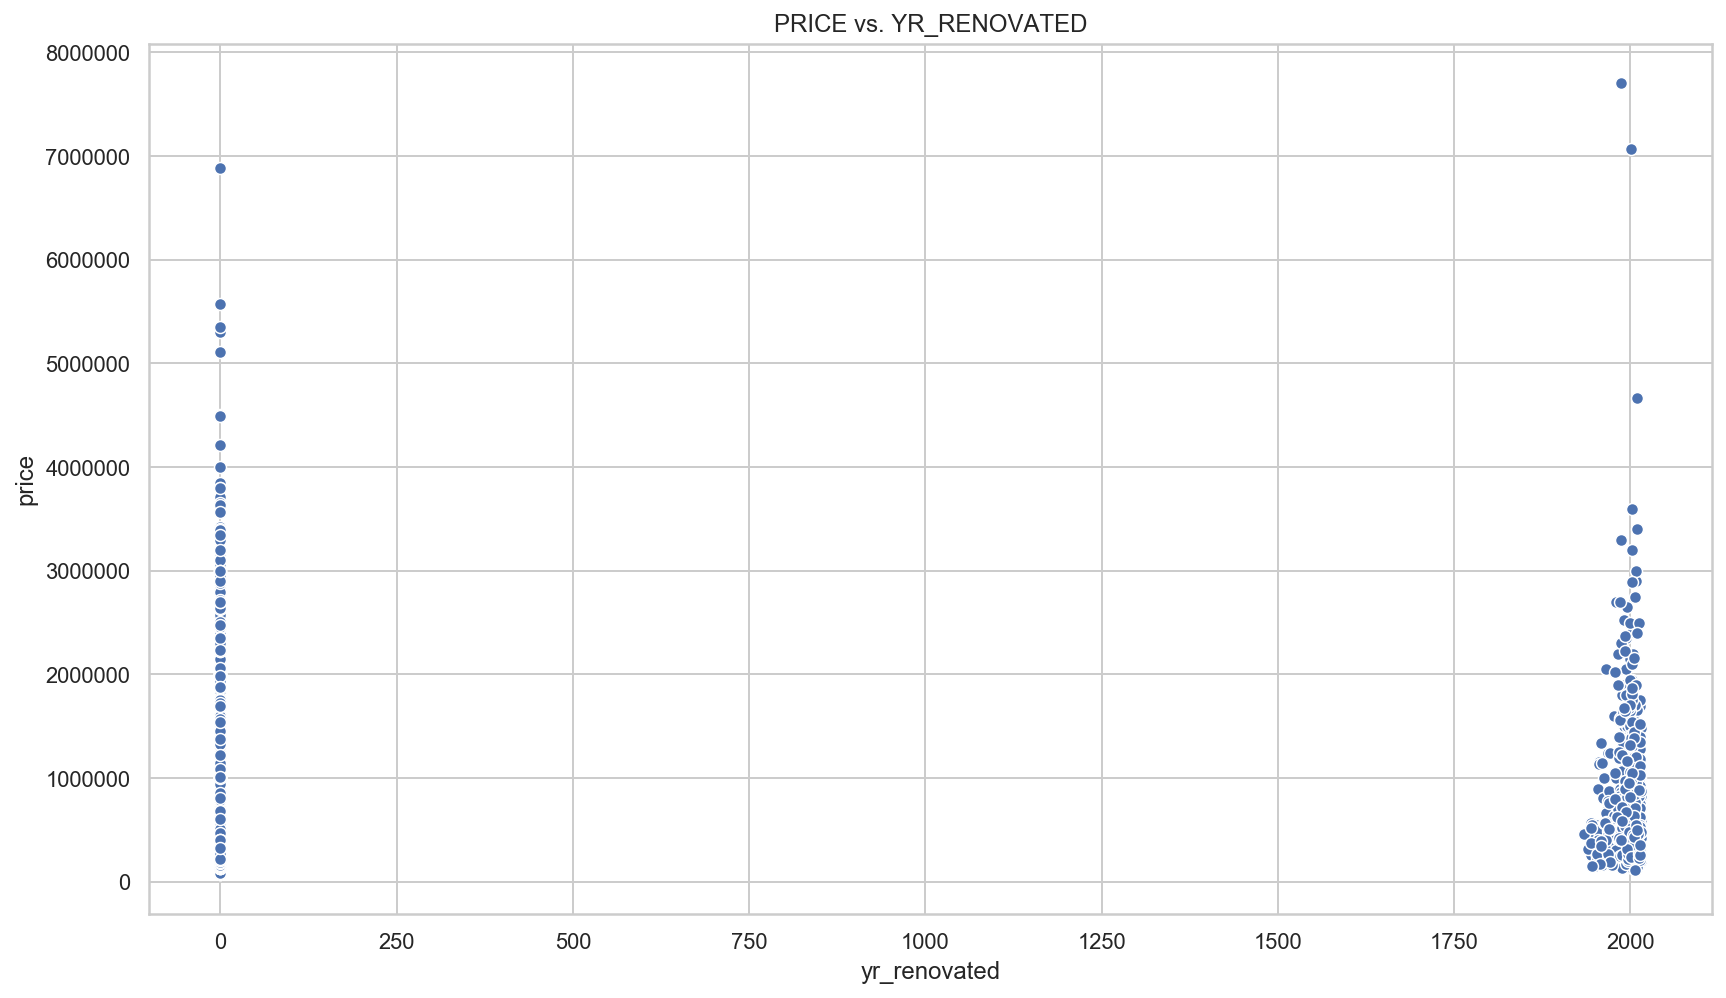

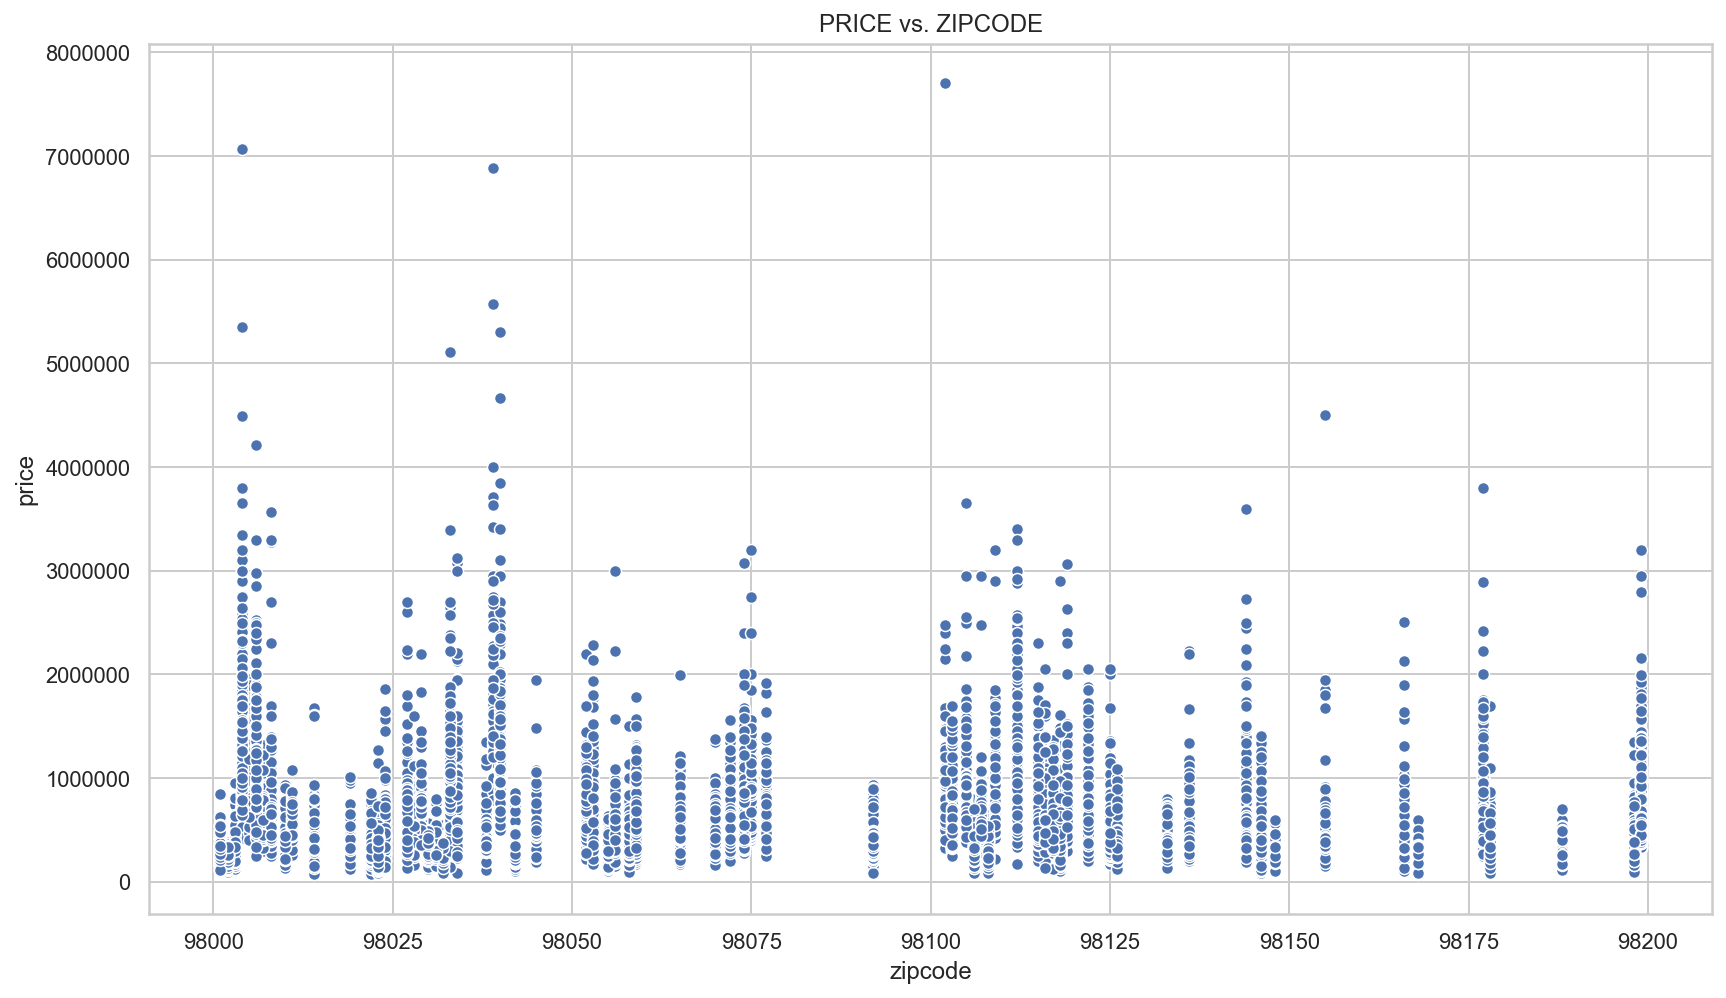

In [18]:
for x in x_cols:
    plt.figure(figsize=fs)
    sns.scatterplot(df[x], df[y]).set_title("{} vs. {}".format(y.upper(), x.upper()))
    plt.savefig("figures/scatterplots/scatter_{}_{}.png".format(y, x))
    plt.show()

- Comments
    - 각 feature와 price간의 상관관계를 자세히 확인


## 2.5 Preprocessing

### 변수간 다중공선성

- 다중공선성(multicollinearity)란 독립 변수의 일부가 다른 독립 변수의 조합으로 표현될 수 있는 경우를 말하며, 독립변수들이 서로 독립이 아니라 상호상관관계가 강한 경우 발생함
- 다중 공선성이 있으면 독립변수의 공분산 행렬의 조건수(conditional number)가 증가
- 상호의존적인 독립변수를 선택하는 방법으로는 VIF(Variance Inflation Factor)를 사용하며 숫자가 높을수록 다른 변수에 의존적임을 알 수 있음<br><br>
 $$
 \text{VIF}_i = \frac{\sigma^2}{(n-1)\text{Var}[X_i]}\cdot \frac{1}{1-R_i^2}
 $$

In [17]:
col_cat = [
    "condition",
    "floors",
    "waterfront",
    "zipcode",
    "grade",
    "view"
]

col_num = [
    "bedrooms",
    "bathrooms",
    "sqft_above",
    "sqft_basement",
    "sqft_living",
    "sqft_living15",
    "sqft_lot",
    "sqft_lot15",
    "yr_built",
    "yr_renovated",
]

In [18]:
x0 = df.drop("price", axis=1)
y = df.price

In [19]:
from patsy import dmatrix

f_num = ["scale(" + col + ")" for col in col_num]
formula = "+".join(col_cat + f_num)

dfX = dmatrix(formula, x0, return_type="dataframe")
dfy = pd.DataFrame(y, columns=["price"])

In [20]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

VIF Factor              features
0   1.147351e+00   scale(yr_renovated)
1   1.203243e+00            waterfront
2   1.246040e+00             condition
3   1.306180e+00               zipcode
4   1.419601e+00                  view
5   1.649619e+00       scale(bedrooms)
6   1.985198e+00                floors
7   2.091007e+00       scale(sqft_lot)
8   2.120834e+00     scale(sqft_lot15)
9   2.222699e+00       scale(yr_built)
10  2.899714e+00  scale(sqft_living15)
11  3.250774e+00                 grade
12  3.347965e+00      scale(bathrooms)
13  4.386414e+06             Intercept
14           inf  scale(sqft_basement)
15           inf     scale(sqft_above)
16           inf    scale(sqft_living)

- commnet
    - vif값이 높은 feature들을 모델에서 제거
        - sqft_above, sqft_basement, sqft_living

### 이상값 제거(anomaly)

In [21]:
idx1 = df[df.bathrooms == 0].index
idx2 = df[df.bedrooms == 0].index
df = df.drop(idx1, errors="ignore")
df = df.drop(idx2, errors="ignore")
idx = np.where(df.bedrooms == 33)
df.bedrooms.iloc[idx] = 3

In [23]:
# idx1 = list(np.where(df.sqft_living15==1330)[0])
# idx2 = list(np.where(df.bedrooms==33)[0])
# idx = list(set(idx1) - set(idx2))
# np.mean(df.bedrooms.iloc[idx])

2.8688524590163933

- comment
    - bathroom과 bedroom이 0인 데이터 drop
    - bedroom값이 33개인 데이터 3으로 변경
        - 면적이 같은 집들의 평균 bedroom 값으로 대체

### 카테고리 변수

- Zipcode
    - Groupby, 70개의 type
- Latitude, Longitude 대체,

In [24]:
temp = df[["price", "zipcode"]]
temp = temp.groupby(by=["zipcode"], sort=False).mean()
temp["zipcode"] = temp.index
temp = temp.sort_values(by="price", ascending=False)
temp = temp.reset_index(drop=True)

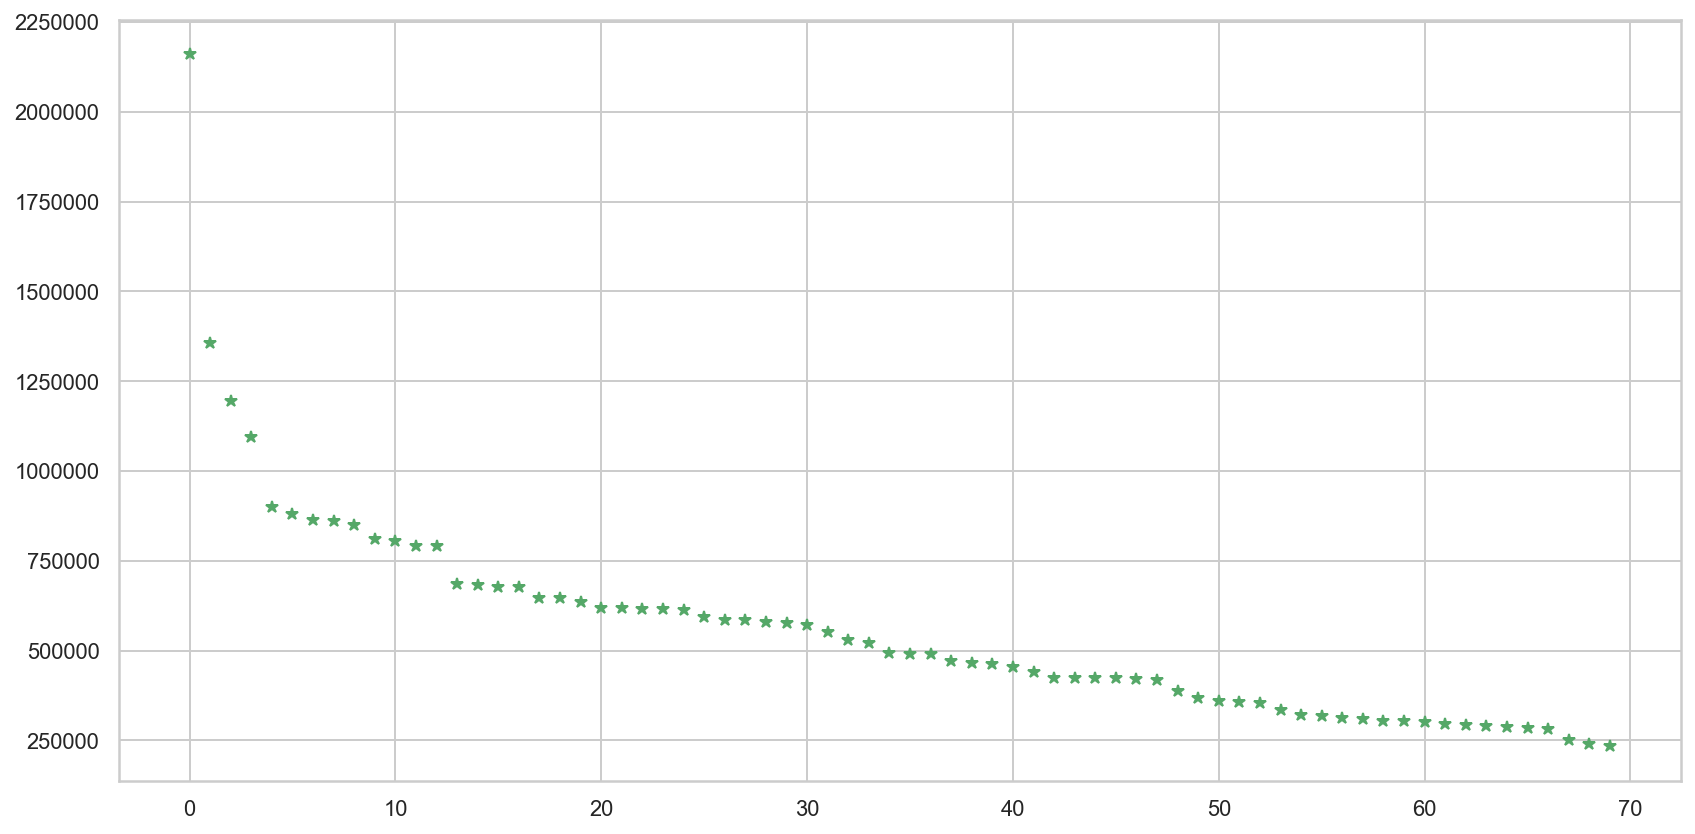

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(temp.index, temp.price, "g*")
plt.show()

- comments
    - zipcode VS. 평균 집값
    - 지역에 따른 집값 차이가 있음을 확인

# 3. Model Testing

### Model_1

In [26]:
x0 = df.drop("price", axis=1)
y = df.price

In [27]:
col_cat = [
    "waterfront",
    "condition",
    "zipcode",
    "view",
    "grade"
]

col_num = [
    "bedrooms",
    "bathrooms",
    "sqft_living15",
    "sqft_lot",
    "sqft_lot15",
    "yr_built",
    "yr_renovated",
]

In [28]:
f_cat = ["C(" + col +")" for col in col_cat]
f_num = ["scale(" + col + ")" for col in col_num]
formula = "price ~ " + " + ".join(f_cat + f_num) + " + 0"
formula

'price ~ C(waterfront) + C(condition) + C(zipcode) + C(view) + C(grade) + scale(bedrooms) + scale(bathrooms) + scale(sqft_living15) + scale(sqft_lot) + scale(sqft_lot15) + scale(yr_built) + scale(yr_renovated) + 0'

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x0, y, test_size=0.3, random_state=1)

In [30]:
model = sm.OLS.from_formula(formula, data=pd.concat([x_train, y_train], axis=1))
result = model.fit()

In [31]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     659.5
Date:                Wed, 10 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:02:29   Log-Likelihood:            -2.0295e+05
No. Observations:               15117   AIC:                         4.061e+05
Df Residuals:                   15021   BIC:                         4.068e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(waterfront)[0]      2.828e+05 

- comments
    - Numerical변수의 p-value값이 0.05보다 높은 변수 제거
    
    

In [32]:
y_predict = result.predict(x_test)

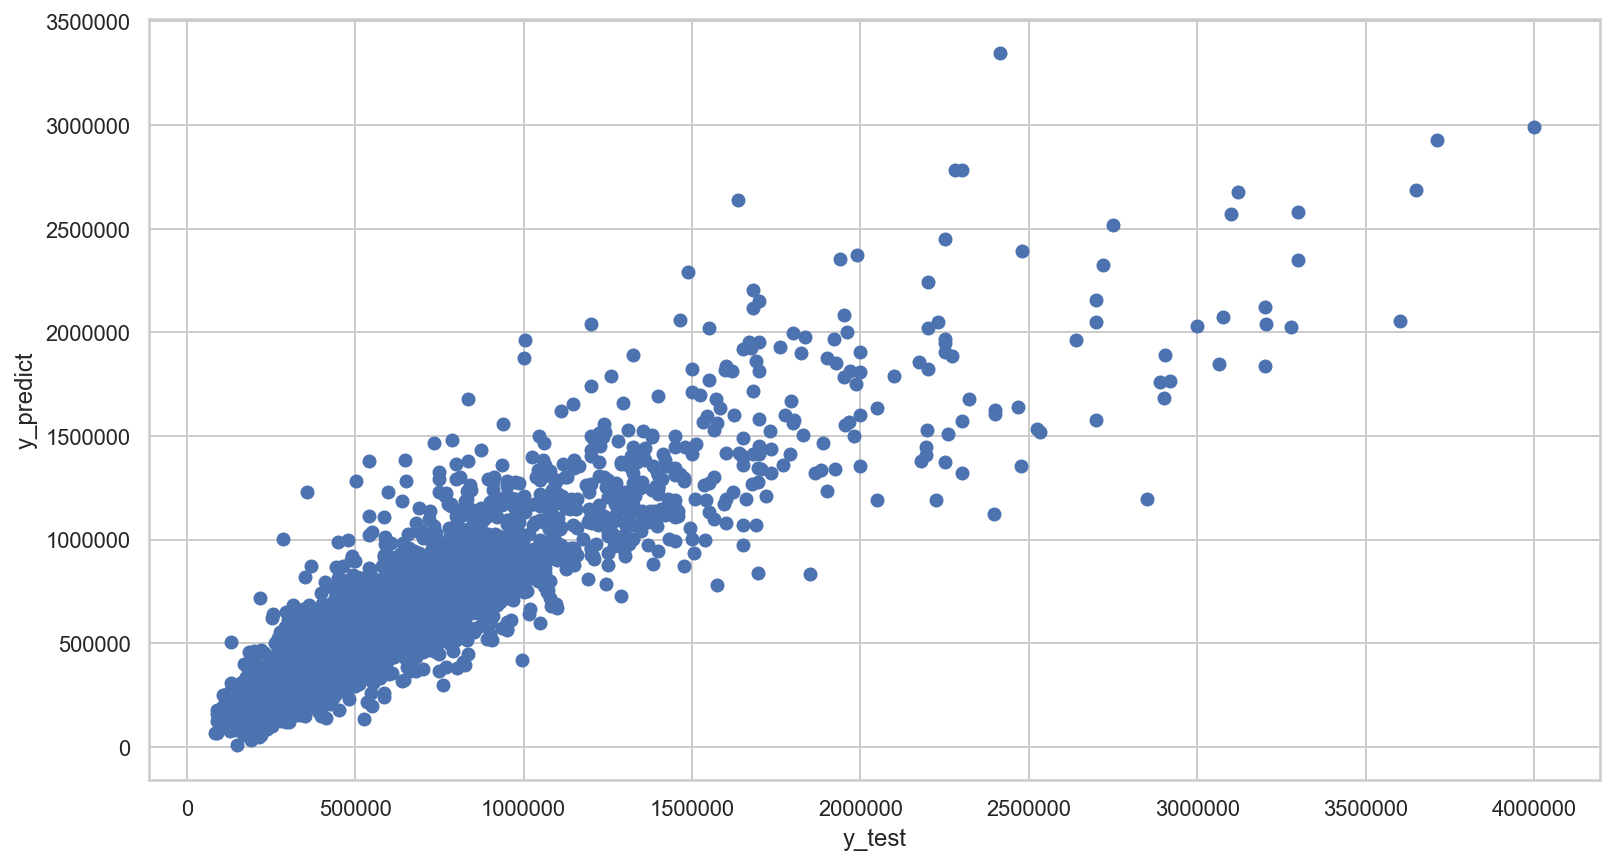

In [33]:
plt.figure(figsize=fs)
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.scatter(y_test, y_predict)
plt.show()

In [34]:
r2_score(y_test, y_predict)

0.8161989418392456

- comments
    - test결과 확인

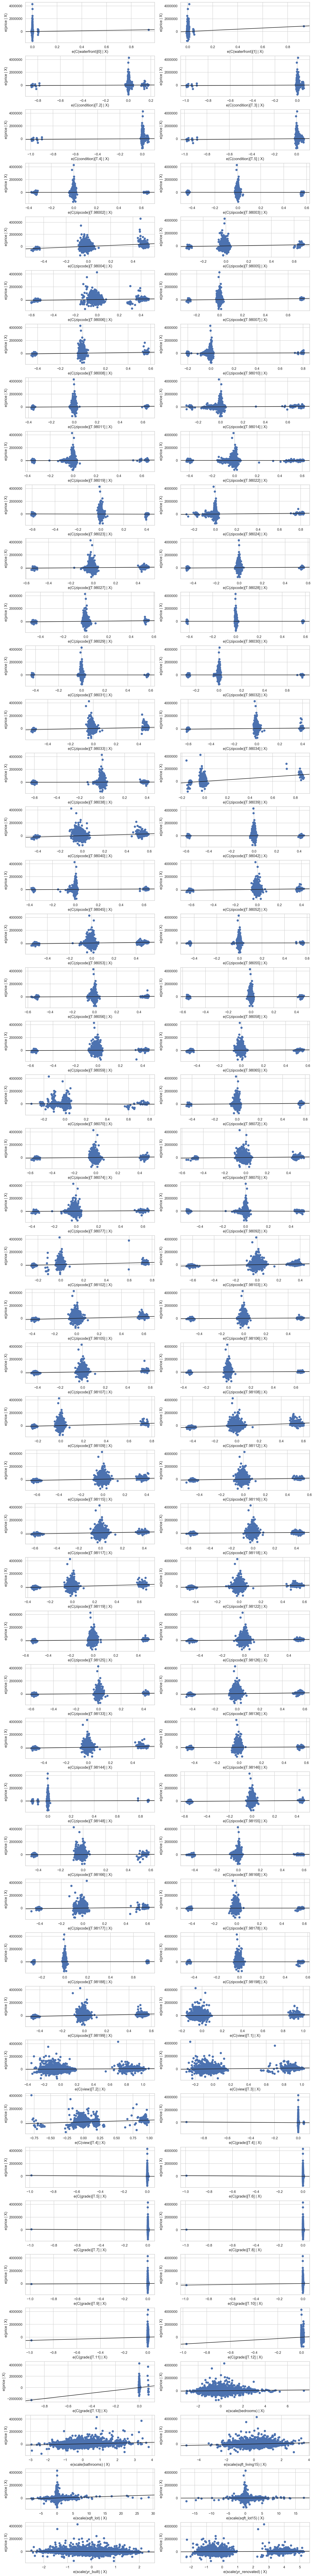

In [35]:
fig = plt.figure(figsize=(14, 120))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

- comments
    - 부분회귀결과 상관관계가 없는 변수 제거
        - sqft_lot15, yr_built, yr_renovated

---

### Model_2

In [36]:
formula = "np.log(price) ~ scale(np.log(bathrooms)) + scale(np.log(bedrooms)) + \
scale(np.log(sqft_living15)) + scale(np.log(sqft_lot)) + C(condition) + \
C(grade) + C(zipcode) + C(view) + 0"

In [37]:
x0 = df.drop("price", axis=1)
y = df.price

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x0, y, test_size=0.3, random_state=1)

In [39]:
model2 = sm.OLS.from_formula(formula, data=pd.concat([x_train, y_train], axis=1))
result2 = model2.fit()

In [40]:
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1006.
Date:                Wed, 10 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:06:12   Log-Likelihood:                 3056.4
No. Observations:               15117   AIC:                            -5929.
Df Residuals:                   15025   BIC:                            -5227.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
C(condition)[1] 

- comments
    - 부분회귀결과를 반영후 성능향상
    - numerical 변수는 p-value가 0이므로 모두 유의미한 변수임

In [41]:
y_predict2 = result2.predict(x_test).apply(np.exp)

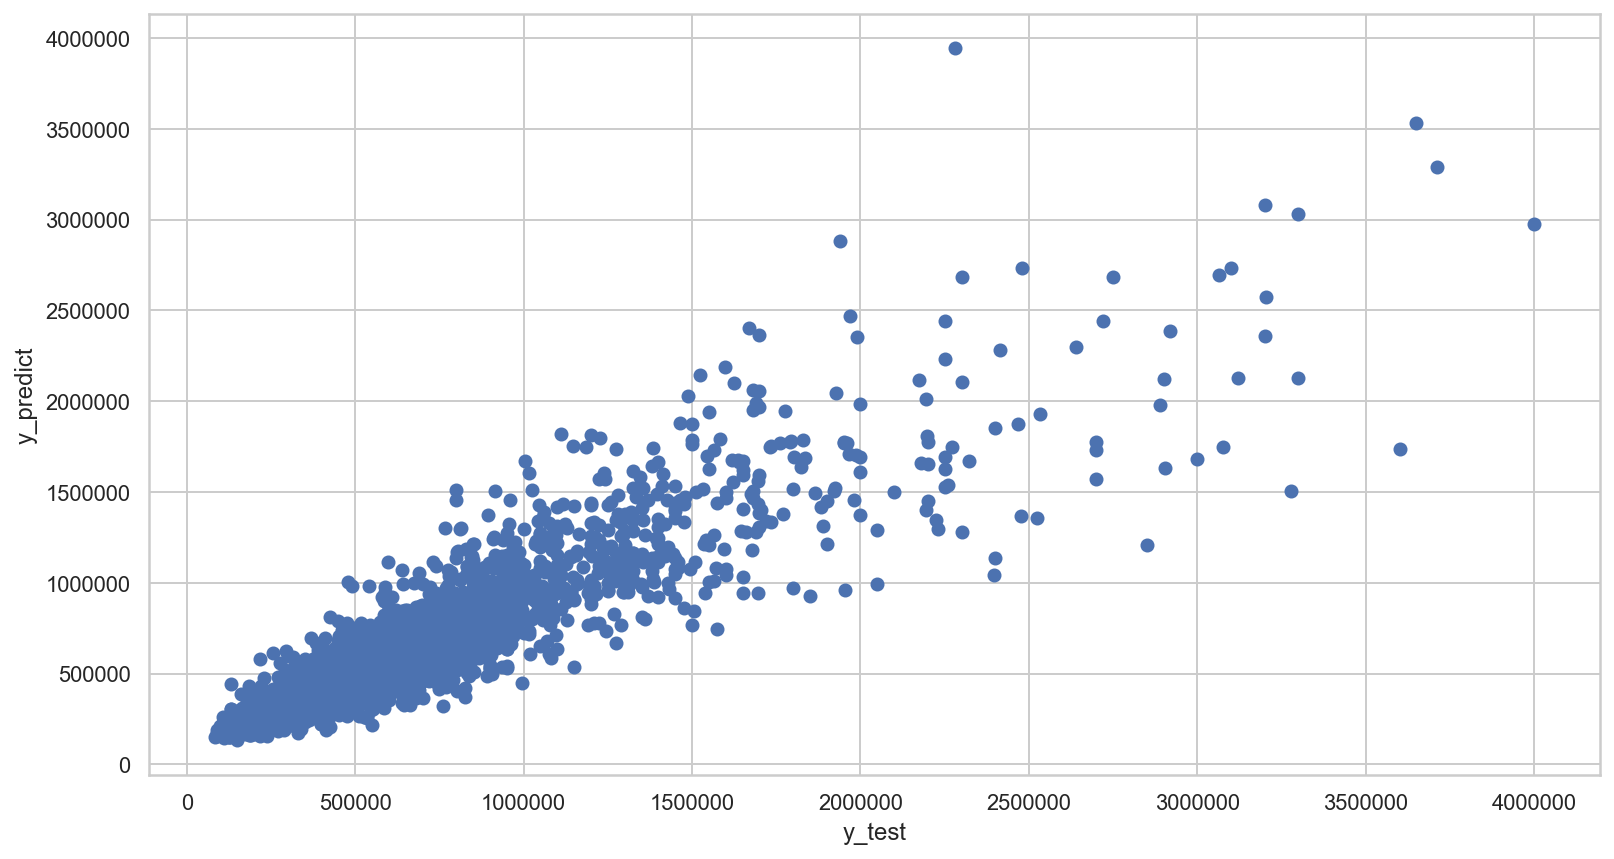

In [42]:
plt.figure(figsize=fs)
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.scatter(y_test, y_predict2)
plt.show()

In [43]:
r2_score(y_test, y_predict2)

0.8379459892098651

- comments
    - test결과 확인